<a href="https://colab.research.google.com/github/zeepdolgin/Projects-in-Programming/blob/main/Arseniy_Dolgin_Assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NYPD Crime Reports Dataset

You are asked to analyze the dataset with all the valid felony, misdemeanor, and violation crimes reported to the New York City Police Department (NYPD) from 2006 to the end of 2016.

The dataset is available at:
https://data.cityofnewyork.us/Public-Safety/NYPD-Complaint-Data-Historic/qgea-i56i

It is a big dataset with ~5.5 million crimes reported to NYPD.

## Attribute Description

Below you can find the description of the attributes, and their datatypes.

| Column | Description | Data Type
|--------|-------------------|----|
| CMPLNT_NUM | Randomly generated persistent ID for each complaint  | bigint(20) |
| CMPLNT_FR | Exact datetime of occurrence for the reported event (or starting date of occurrence, if CMPLNT_TO_DT exists) | datetime |
| CMPLNT_TO | Ending datetime of occurrence for the reported event, if exact time of occurrence is unknown | datetime
| RPT_DT | Date event was reported to police  | date
| KY_CD | Three digit offense classification code | char(3)
| OFNS_DESC | Description of offense corresponding with key code | varchar(80)
| PD_CD | Three digit internal classification code (more granular than Key Code) | char(3)
| PD_DESC | Description of internal classification corresponding with PD code (more granular than Offense Description) | varchar(60)
| CRM_ATPT_CPTD_CD | Indicator of whether crime was successfully completed or attempted, but failed or was interrupted prematurely | enum('COMPLETED','ATTEMPTED')
| LAW_CAT_CD | Level of offense: felony, misdemeanor, violation  | enum('FELONY','MISDEMEANOR','VIOLATION')
| JURIS_DESC | Jurisdiction responsible for incident. Either internal, like Police, Transit, and Housing; or external, like Correction, Port Authority, etc. | varchar(80)
| BORO_NM | The name of the borough in which the incident occurred | varchar(20)
| ADDR_PCT_CD | The precinct in which the incident occurred | char(3)
| LOC_OF_OCCUR_DESC | Specific location of occurrence in or around the premises; inside, opposite of, front of, rear of | enum('FRONT OF','INSIDE','OPPOSITE OF','OUTSIDE','REAR OF')
| PREM_TYP_DESC | Specific description of premises; grocery store, residence, street, etc. | varchar(80)
| PARKS_NM | Name of NYC park, playground or greenspace of occurrence, if applicable (state parks are not included) | varchar(80)
| HADEVELOPT | Name of NYCHA housing development of occurrence, if applicable | varchar(80)
| X_COORD_CD | X-coordinate for New York State Plane Coordinate System, Long Island Zone, NAD 83, units feet (FIPS 3104) | char(9)
| Y_COORD_CD | Y-coordinate for New York State Plane Coordinate System, Long Island Zone, NAD 83, units feet (FIPS 3104) | char(9)
| Latitude | Latitude coordinate for Global Coordinate System, WGS 1984, decimal degrees (EPSG 4326)  | double
| Longitude | Longitude coordinate for Global Coordinate System, WGS 1984, decimal degrees (EPSG 4326) | double

Additional Notes: https://www1.nyc.gov/assets/nypd/downloads/pdf/analysis_and_planning/incident_level_data_footnotes.pdf

In [ ]:
!pip install geopandas sqlalchemy
!apt-get install python3-mysqldb

     |████████████████████████████████| 972kB 4.8MB/s 
     |████████████████████████████████| 10.9MB 14.6MB/s 
     |████████████████████████████████| 14.8MB 238kB/s 
Reading package lists... Done
Building dependency tree       
Reading state information... Done
Suggested packages:
  default-mysql-server | virtual-mysql-server python-egenix-mxdatetime
  python3-mysqldb-dbg
The following NEW packages will be installed:
  python3-mysqldb
0 upgraded, 1 newly installed, 0 to remove and 21 not upgraded.
Need to get 46.0 kB of archives.
After this operation, 183 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 python3-mysqldb amd64 1.3.10-1build1 [46.0 kB]
Fetched 46.0 kB in 1s (66.4 kB/s)
Selecting previously unselected package python3-mysqldb.
(Reading database ... 144611 files and directories currently installed.)
Preparing to unpack .../python3-mysqldb_1.3.10-1build1_amd64.deb ...
Unpacking python3-mysqldb (1.3.10-1build1) ...
Setting up

## MySQL Database

For your convenience, the dataset is stored in the `nypd_complaints` database on the MySQL Server `db.ipeirotis.org`. You can connect and see the dataset using your standard username and password (`student`, `dwdstudent2015`).

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import pandas as pd
from sqlalchemy import create_engine
import geopandas as gpd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

In [ ]:
conn_string = 'mysql://{user}:{password}@{host}:{port}/{db}?charset={encoding}'.format(
    user='student',
    password='dwdstudent2015',
    host = 'db.ipeirotis.org',
    port=3306,
    db='nypd_complaints',
    encoding = 'utf8'
)
engine = create_engine(conn_string)

# Make the graphs a bit prettier, and bigger
matplotlib.style.use(['seaborn-talk', 'seaborn-ticks', 'seaborn-whitegrid'])
plt.rcParams['figure.figsize'] = (15, 7)

# Questions

You are asked to analyze the dataset and provide answers for the questions below. You can answer the questions using Python, SQL, or a combination of them. You are *strongly* encouraged though to push most of the aggregation calculation to happen with SQL. Fetching the whole dataset in memory and doing _all_ the aggregation calculations in Pandas may cause significant problems, as you may often run out of memory.

## Question 1: Composition of crimes

* **Question 1a**: How many total reported crimes are in the dataset?
* **Question 1b**: Analyze the column `LAW_CAT_CD` and provide the breakdown of the reported crimes among `FELONY`,`MISDEMEANOR`, and `VIOLATION`, i.e., report the number of felonies, misdemeanors, and violations.
* **Question 1c**: Across **felonies**, report the number of crimes, broken down by  offense description (as reported in the `OFNS_DESC` column)

In [ ]:
# Question 1a: How many total reported crimes are in the dataset?
query = '''
SELECT COUNT(DISTINCT CMPLNT_NUM) FROM nypd
'''
total_crimes = pd.read_sql(query, con=engine)
print(total_crimes)


   COUNT(DISTINCT CMPLNT_NUM)
0                     5580035


In [ ]:
# Question 1b: Analyze the column LAW_CAT_CD and report the number of felonies, misdemeanors, and violations.
query = '''
SELECT COUNT(LAW_CAT_CD), LAW_CAT_CD
FROM nypd
GROUP BY LAW_CAT_CD
ORDER BY COUNT(LAW_CAT_CD) DESC
'''

types_crimes = pd.read_sql(query, con=engine)
print(types_crimes)

   COUNT(LAW_CAT_CD)   LAW_CAT_CD
0            3180644  MISDEMEANOR
1            1717265       FELONY
2             682126    VIOLATION


In [ ]:
# Question 1c: Across felonies, report the number of crimes, broken down by offense description (as reported in the OFNS_DESC column)

query = '''
SELECT COUNT(OFNS_DESC), OFNS_DESC
FROM nypd
WHERE LAW_CAT_CD = 'FELONY'
GROUP BY OFNS_DESC
ORDER BY COUNT(OFNS_DESC) DESC
'''

felonies_description = pd.read_sql(query, con=engine)
print(felonies_description)


    COUNT(OFNS_DESC)                        OFNS_DESC
0             473457                    GRAND LARCENY
1             214271                          ROBBERY
2             204904                   FELONY ASSAULT
3             204396                         BURGLARY
4             123576          MISCELLANEOUS PENAL LAW
5             108387   GRAND LARCENY OF MOTOR VEHICLE
6              82378   CRIMINAL MISCHIEF & RELATED OF
7              67426                  DANGEROUS DRUGS
8              61557                      THEFT-FRAUD
9              56027                DANGEROUS WEAPONS
10             55585                          FORGERY
11             15228                             RAPE
12             14760                            ARSON
13             12163                       SEX CRIMES
14              9881    POSSESSION OF STOLEN PROPERTY
15              4909  MURDER & NON-NEGL. MANSLAUGHTER
16              4443     NYS LAWS-UNCLASSIFIED FELONY
17              2437    KIDN

## Question 2: Is crime increasing or decreasing in NYC?

Use the column `CMPLNT_FR` that reports the date/time of the crime. You are asked to analyze the crimes that happened between January 1st 2006 and December 31st 2016.

* **Question 2a**: Create a plot that shows the *total* number of **all** reported crimes *per month*.
* **Question 2b**: Create a plot that shows the *total* number of **all** reported crimes *per year*.
* **Question 2c**: Create a plot that shows the *total* number of reported **felonies** *per month*.
* **Question 2d**: Create a plot that shows the *total* number of reported **felonies** *per year*.

**Hint 1**: Be aware that comparisons with dates in MySQL are tricky. You will want to use the format `2006-01-01` for a date, so that it gets properly interpreted by MySQL.

**Hint 2**: You can use the `MONTH()` and `YEAR()` commands in SQL, or the  `resample` command in Pandas, to compute statistics on a per-month and per-year basis. If you use resample, understand the difference between `resample(...).sum()` and `resample(...).mean()`. The `mean()` vs `sum()` can generate very different results, especially when the timestamp variable has a very fine granularity (as happens in our case with `CMPLNT_FR`).

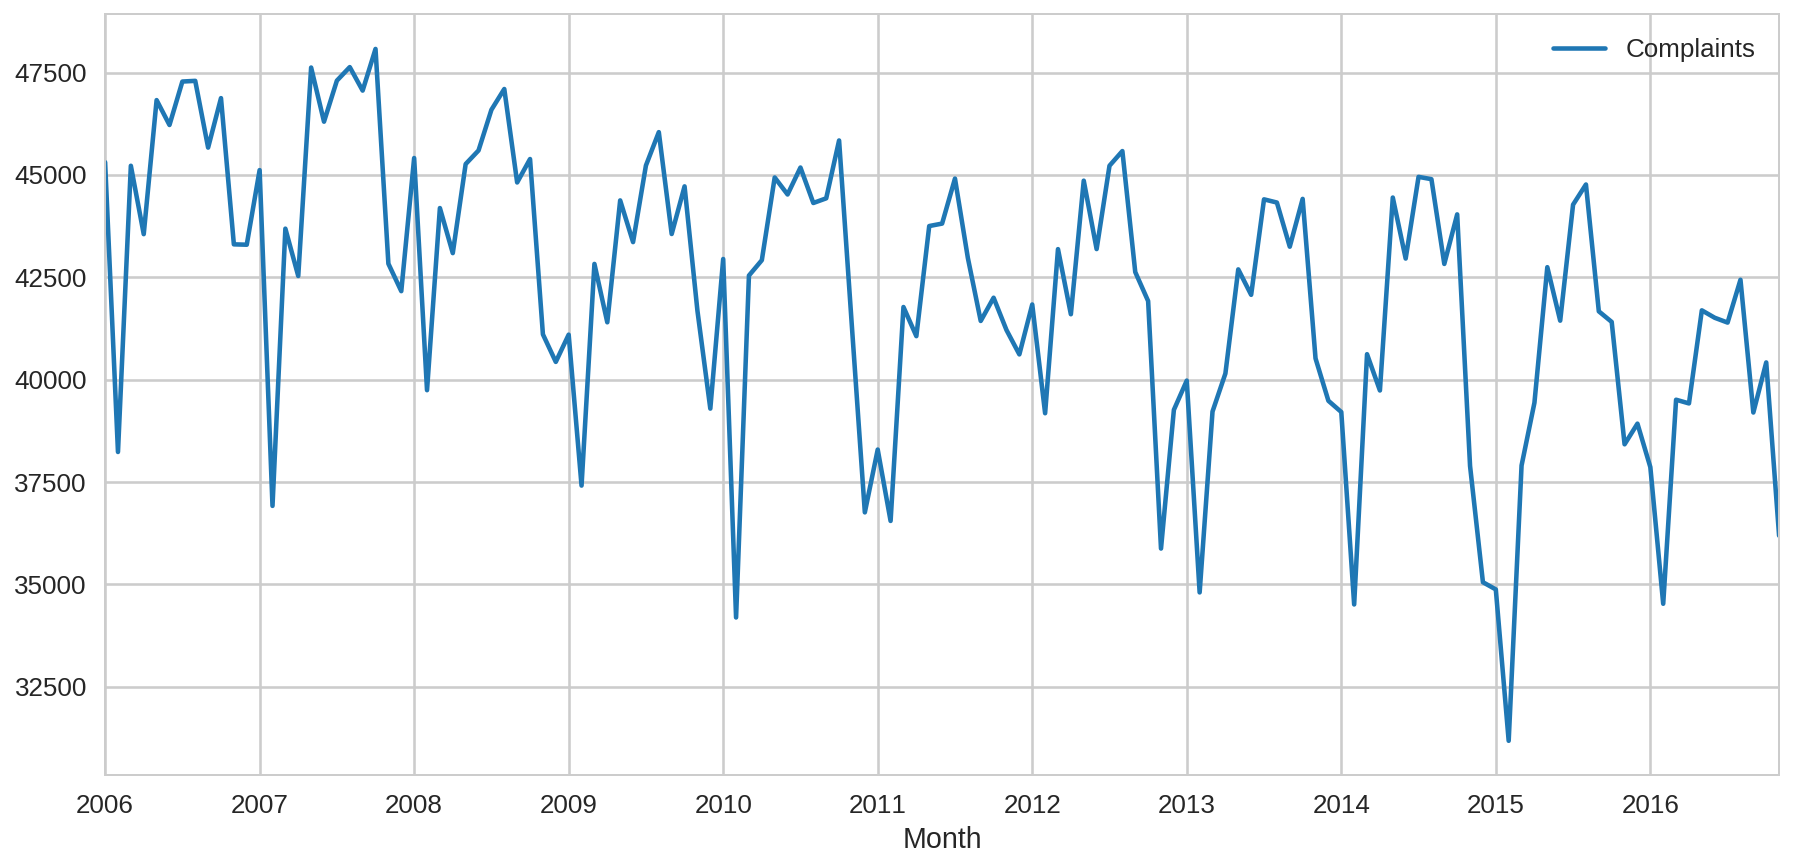

In [ ]:
# Question 2a: Create a plot that shows the total number of all reported crimes per month

query = '''
SELECT CMPLNT_FR as Month, COUNT(CMPLNT_NUM) as Complaints
FROM nypd
WHERE CMPLNT_FR BETWEEN '2006-01-01' AND '2016-11-31'
GROUP BY CMPLNT_FR;
'''
crimes_time = pd.read_sql(query, con=engine)
crimes_time.set_index("Month", inplace=True)
monthly_crimes = crimes_time.resample('1M').sum()

monthly_crimes.plot()

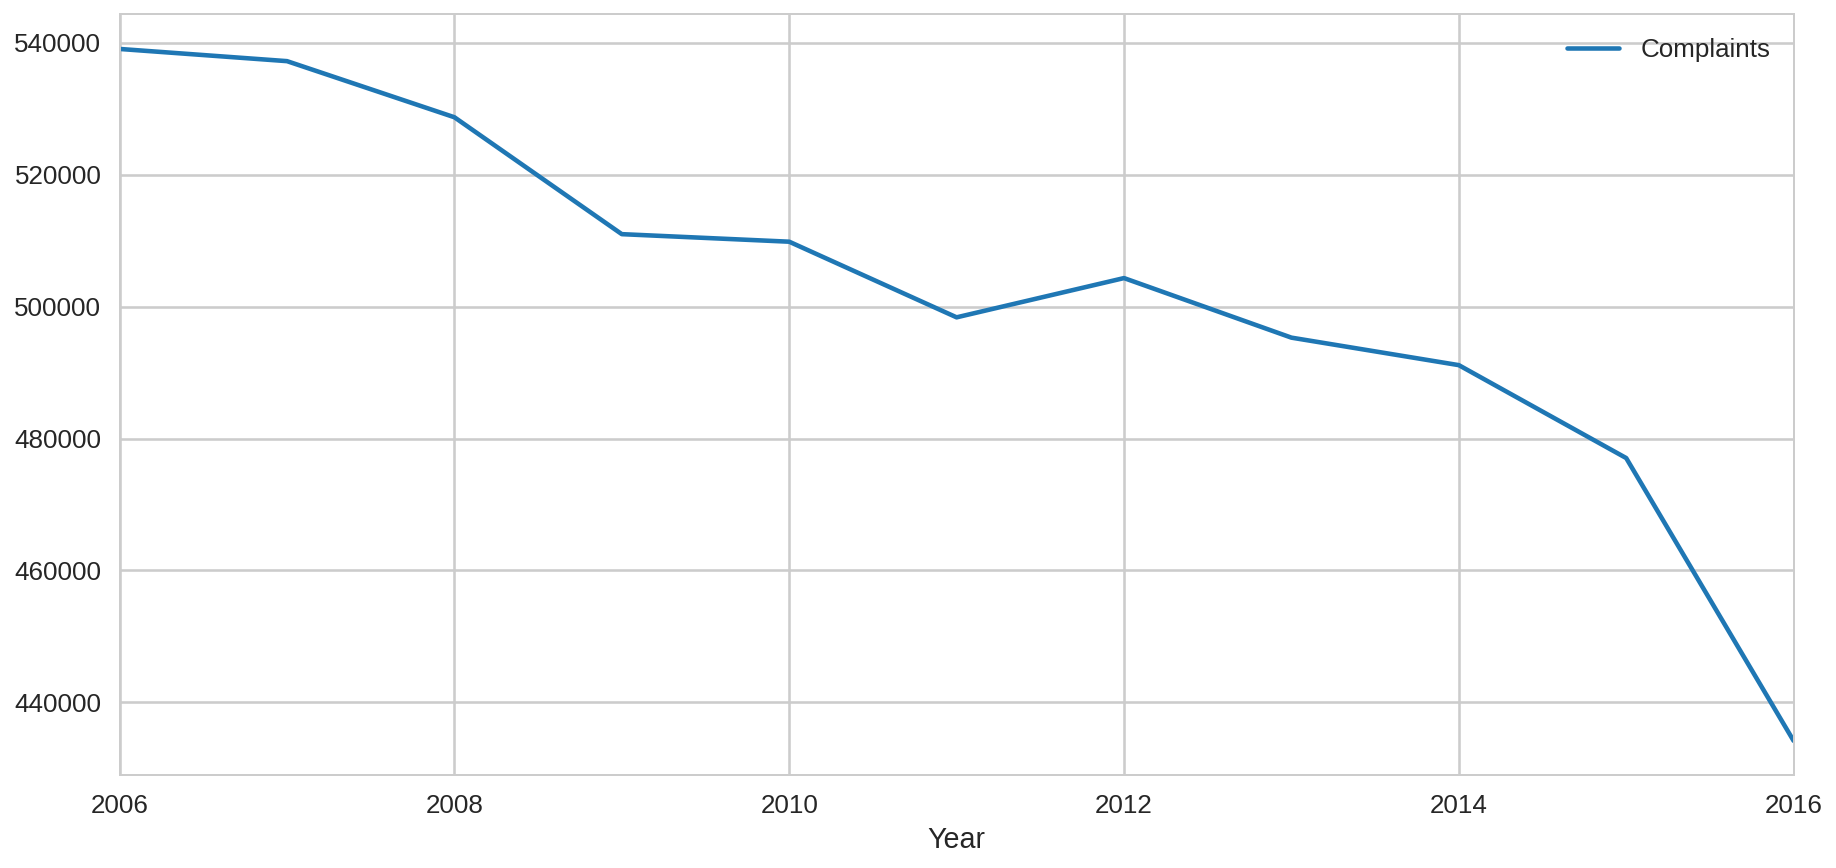

In [ ]:
# Question 2b: Create a plot that shows the total number of all reported crimes per year.

query = '''
SELECT CMPLNT_FR as Year, COUNT(CMPLNT_NUM) as Complaints
FROM nypd
WHERE CMPLNT_FR BETWEEN '2006-01-01' AND '2016-11-31'
GROUP BY CMPLNT_FR;
'''
crimes_time = pd.read_sql(query, con=engine)
crimes_time.set_index("Year", inplace=True)
yearly_crimes = crimes_time.resample('1Y').sum()

yearly_crimes.plot()


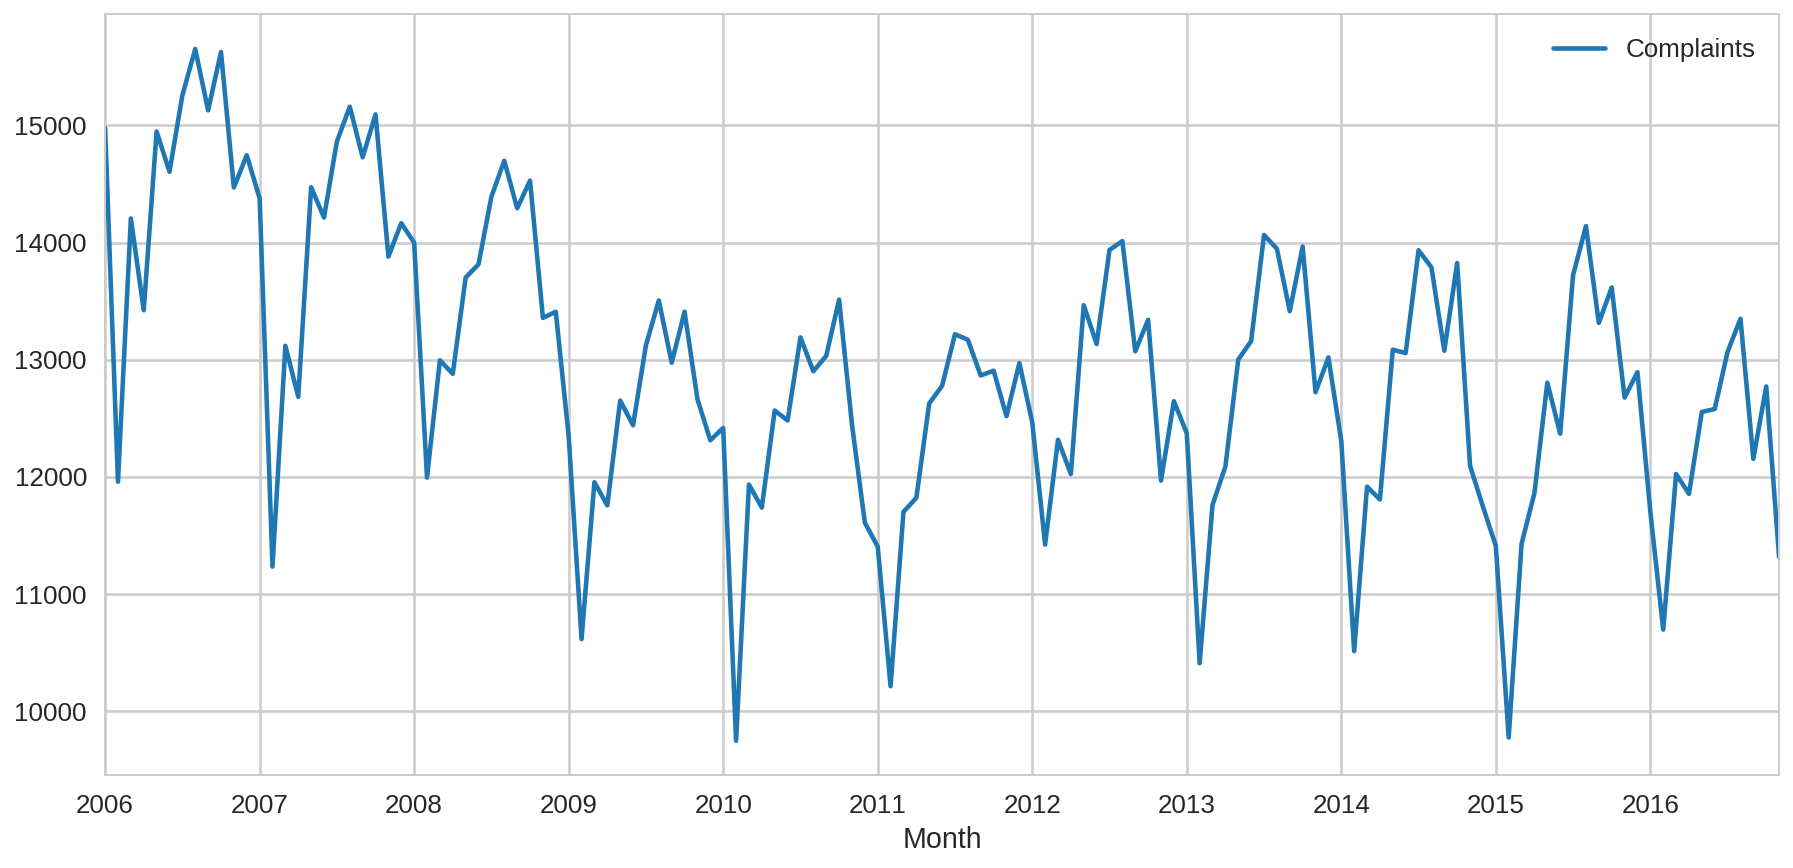

In [ ]:
# Question 2c: Create a plot that shows the total number of reported felonies per month.

query = '''
SELECT CMPLNT_FR as Month, COUNT(CMPLNT_NUM) as Complaints
FROM nypd
WHERE CMPLNT_FR BETWEEN '2006-01-01' AND '2016-11-31' AND LAW_CAT_CD = 'FELONY'
GROUP BY CMPLNT_FR;
'''
crimes_time = pd.read_sql(query, con=engine)
crimes_time.set_index("Month", inplace=True)
monthly_felonies = crimes_time.resample('1M').sum()

monthly_felonies.plot()


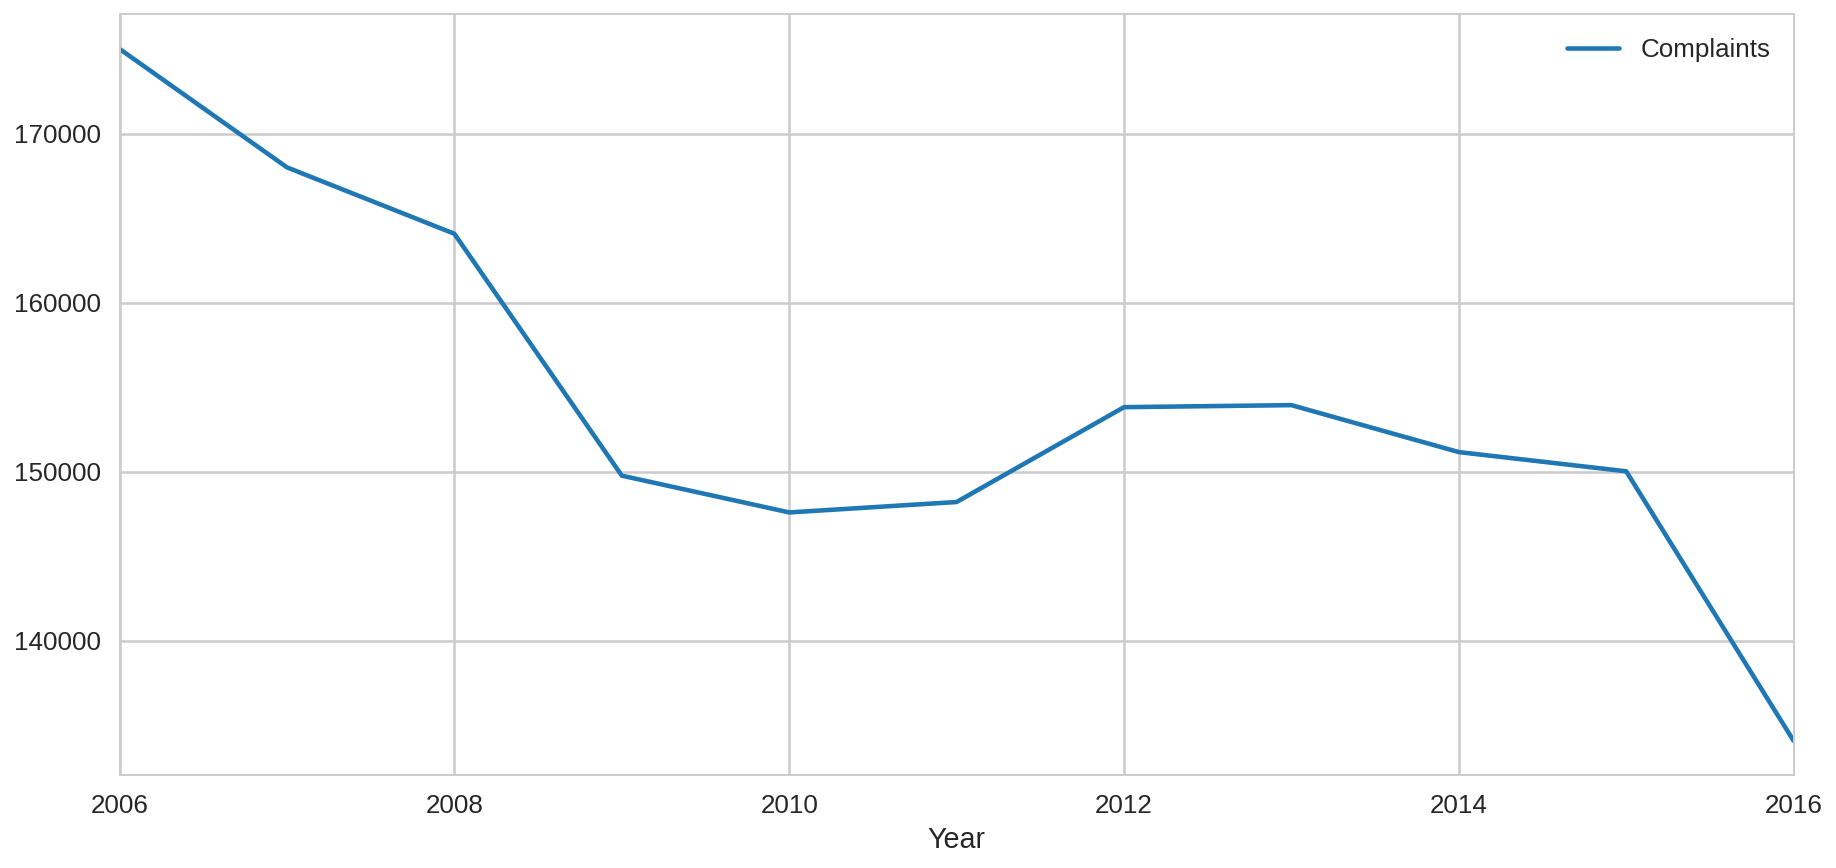

In [ ]:
# Question 2d: Create a plot that shows the total number of reported felonies per year.

query = '''
SELECT CMPLNT_FR as Year, COUNT(CMPLNT_NUM) as Complaints
FROM nypd
WHERE CMPLNT_FR BETWEEN '2006-01-01' AND '2016-11-31' AND LAW_CAT_CD = 'FELONY'
GROUP BY CMPLNT_FR;
'''
crimes_time = pd.read_sql(query, con=engine)
crimes_time.set_index("Year", inplace=True)
yearly_felonies = crimes_time.resample('1Y').sum()

yearly_felonies.plot()

## Question 3: Analysis of the "Big-7" felonies

The NYPD calls the following types of felonies as the "big-7" crimes, as they tend to affect most the quality of life:

* GRAND LARCENY
* ROBBERY
* FELONY ASSAULT
* BURGLARY
* GRAND LARCENY OF MOTOR VEHICLE
* RAPE
* MURDER & NON-NEGL. MANSLAUGHTER


Focus on the big-7 felonies. Report the number of these crimes over time, from 2006 till 2016, **broken down by type of felony**. Focus on reporting the **total** number of crimes per category, on a **per month** and on **per year** basis. Generate the associated plot.

**Hint 1**: The type of felony is included in the `OFNS_DESC` column. You can use the `IN` command in SQL to limit your results to these offenses, or use an `OR` clause. Alternatively, you can use the [`.isin()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.isin.html) command in Pandas.

**Hint 2**: If you would like to move the legend outside the plot, you can use the following command: `df.plot(...).legend(bbox_to_anchor=(1, 0.75))`. The two values for the parameter `bbox_to_anchor` describe the x/y location of the legend, compared to the plot. Experiment with different values to understand the effect.


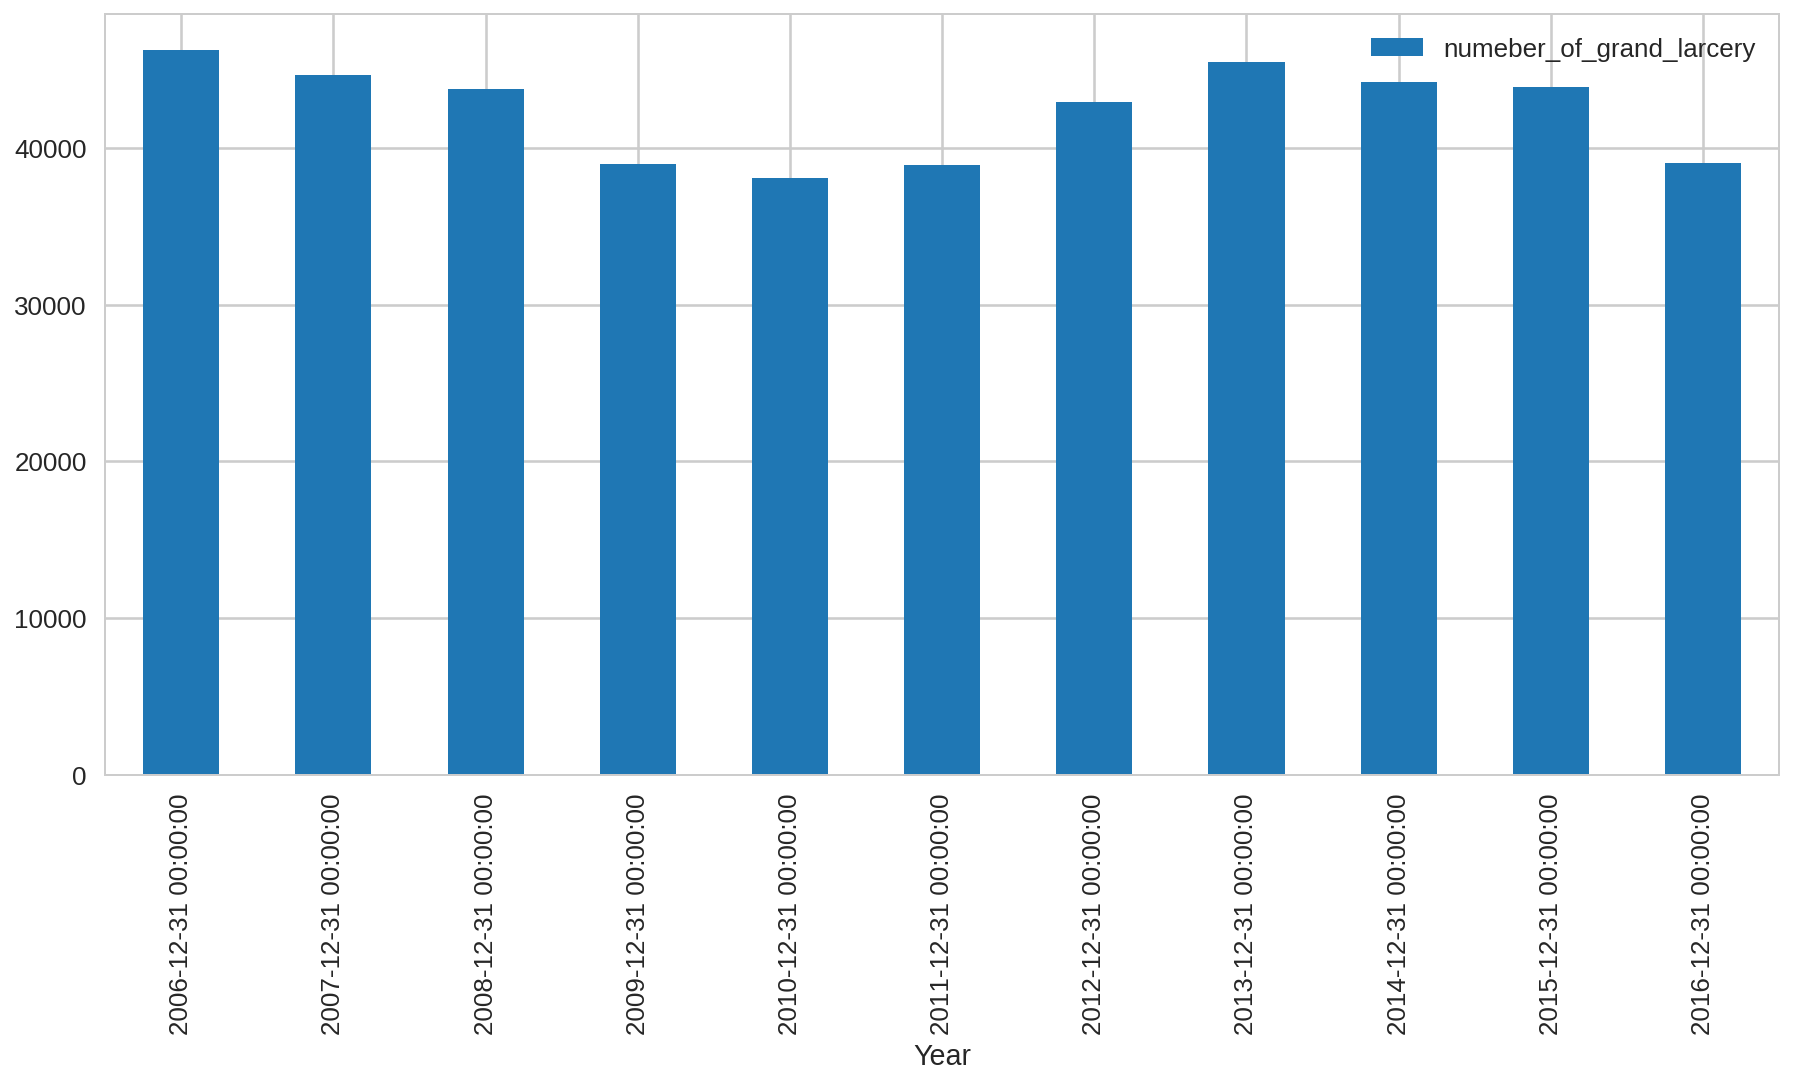

In [ ]:
query = '''
SELECT CMPLNT_FR as Year, COUNT(CMPLNT_NUM) as numeber_of_grand_larcery, OFNS_DESC as type_of_complaint
FROM nypd
WHERE CMPLNT_FR BETWEEN '2006-01-01' AND '2016-11-31'
AND LAW_CAT_CD = 'FELONY'
AND OFNS_DESC IN ('GRAND LARCENY')
GROUP BY CMPLNT_FR, OFNS_DESC;
'''

big_7 = pd.read_sql(query, con=engine)
big_7.set_index("Year", inplace=True)
big_7_time_grand_larcery_year = big_7.resample('1Y').sum()
big_7_time_grand_larcery_year.plot(kind='bar')



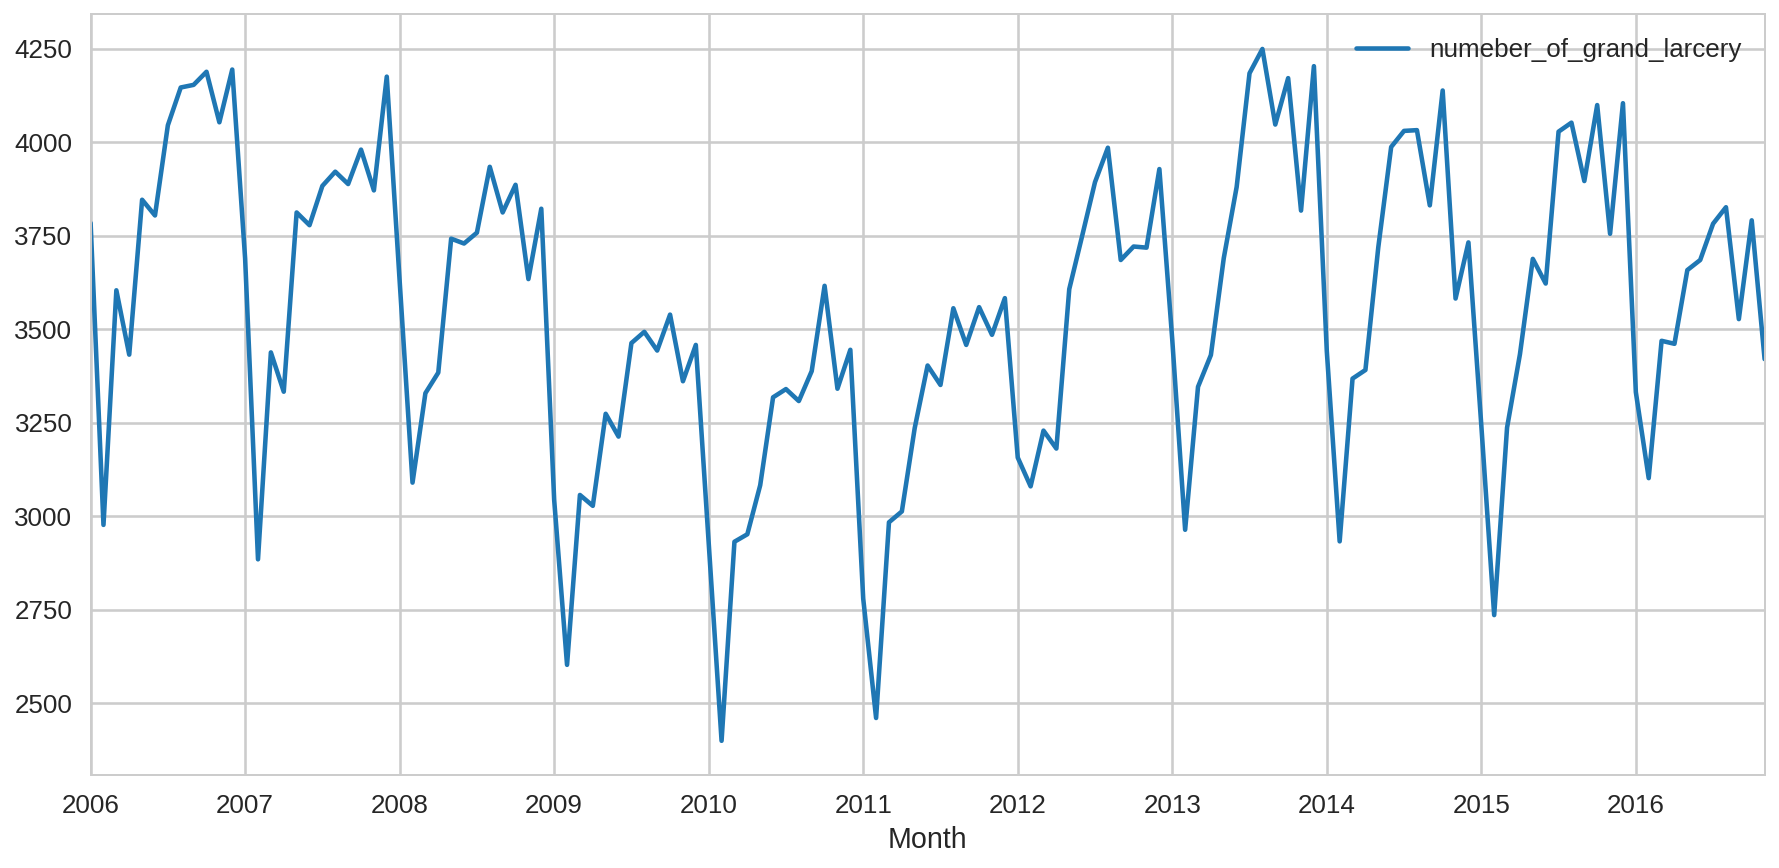

In [ ]:
query = '''
SELECT CMPLNT_FR as Month, COUNT(CMPLNT_NUM) as numeber_of_grand_larcery, OFNS_DESC as type_of_complaint
FROM nypd
WHERE CMPLNT_FR BETWEEN '2006-01-01' AND '2016-11-31'
AND LAW_CAT_CD = 'FELONY'
AND OFNS_DESC IN ('GRAND LARCENY')
GROUP BY CMPLNT_FR, OFNS_DESC;
'''


big_7 = pd.read_sql(query, con=engine)
big_7.set_index("Month", inplace=True)
big_7_time_grand_larcery_month = big_7.resample('1M').sum()
big_7_time_grand_larcery_month.plot()


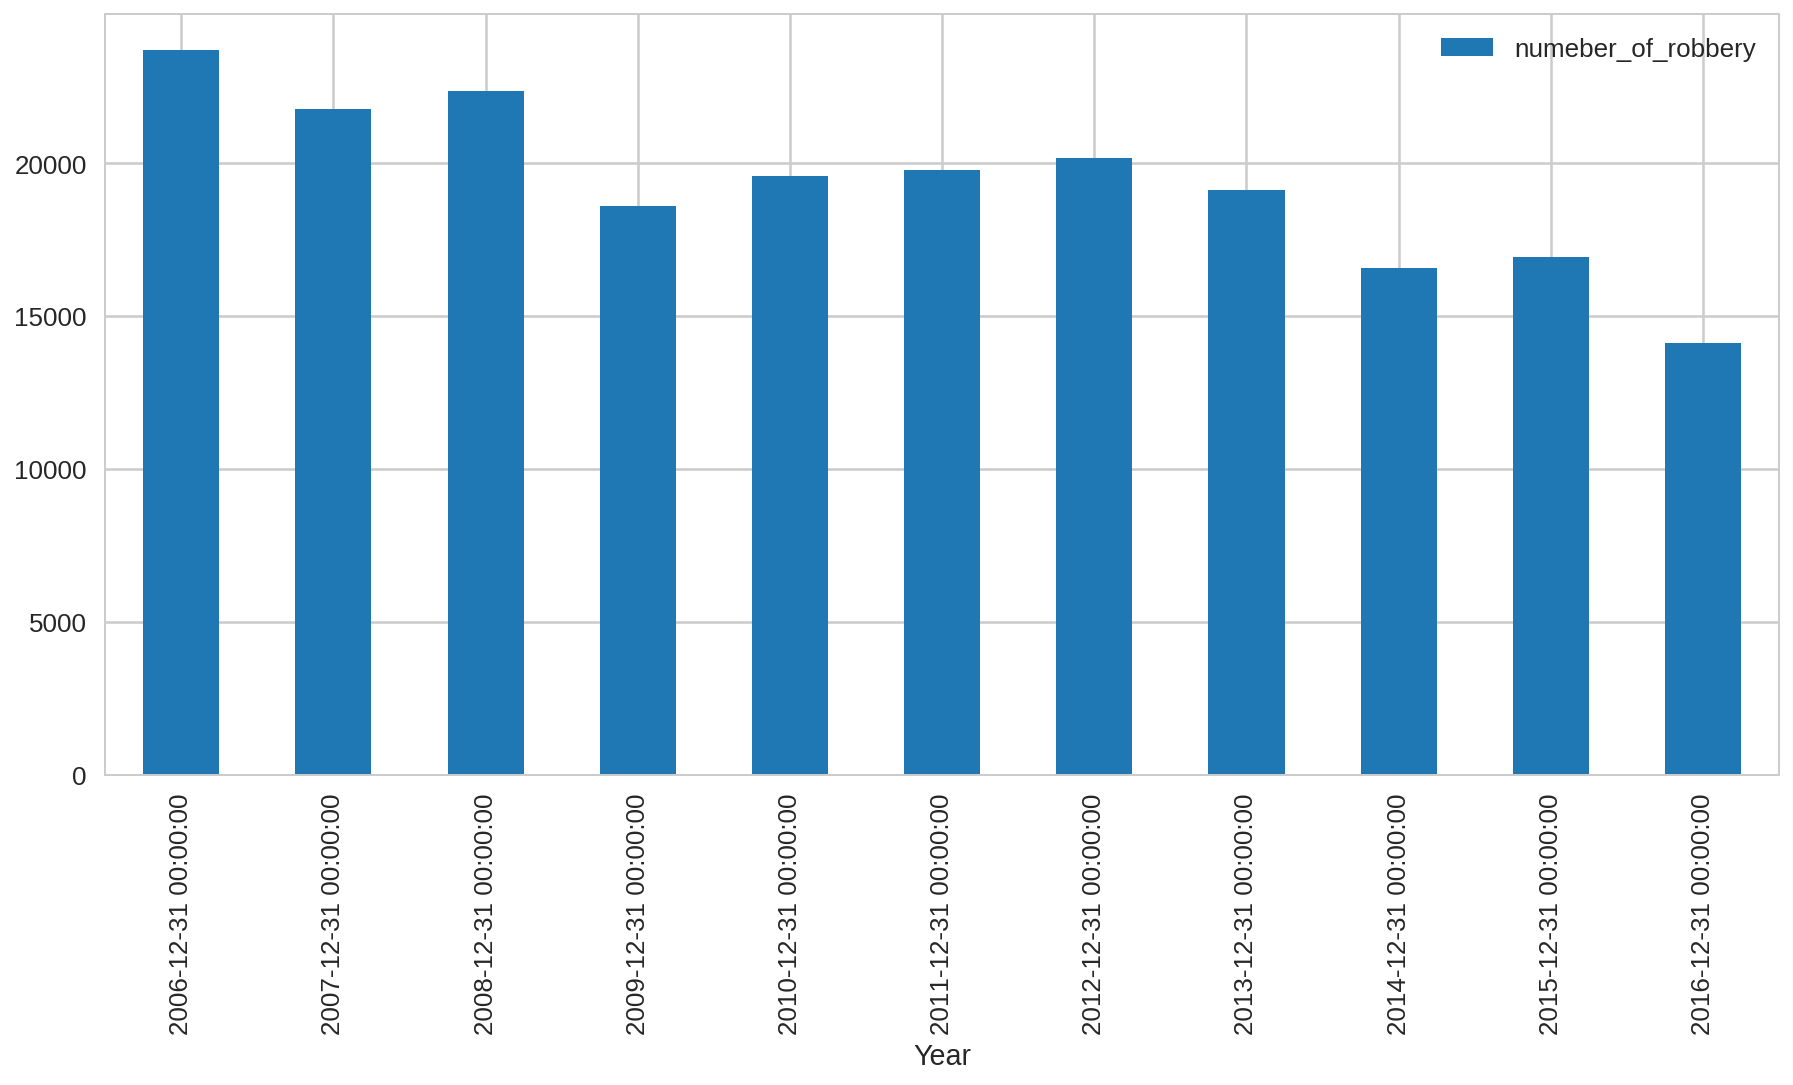

In [ ]:
query = '''
SELECT CMPLNT_FR as Year, COUNT(CMPLNT_NUM) as numeber_of_robbery, OFNS_DESC as type_of_complaint
FROM nypd
WHERE CMPLNT_FR BETWEEN '2006-01-01' AND '2016-11-31'
AND LAW_CAT_CD = 'FELONY'
AND OFNS_DESC IN ('ROBBERY')
GROUP BY CMPLNT_FR, OFNS_DESC;
'''


big_7 = pd.read_sql(query, con=engine)
big_7.set_index("Year", inplace=True)
big_7_time_robbery_year = big_7.resample('1Y').sum()
big_7_time_robbery_year.plot(kind='bar')



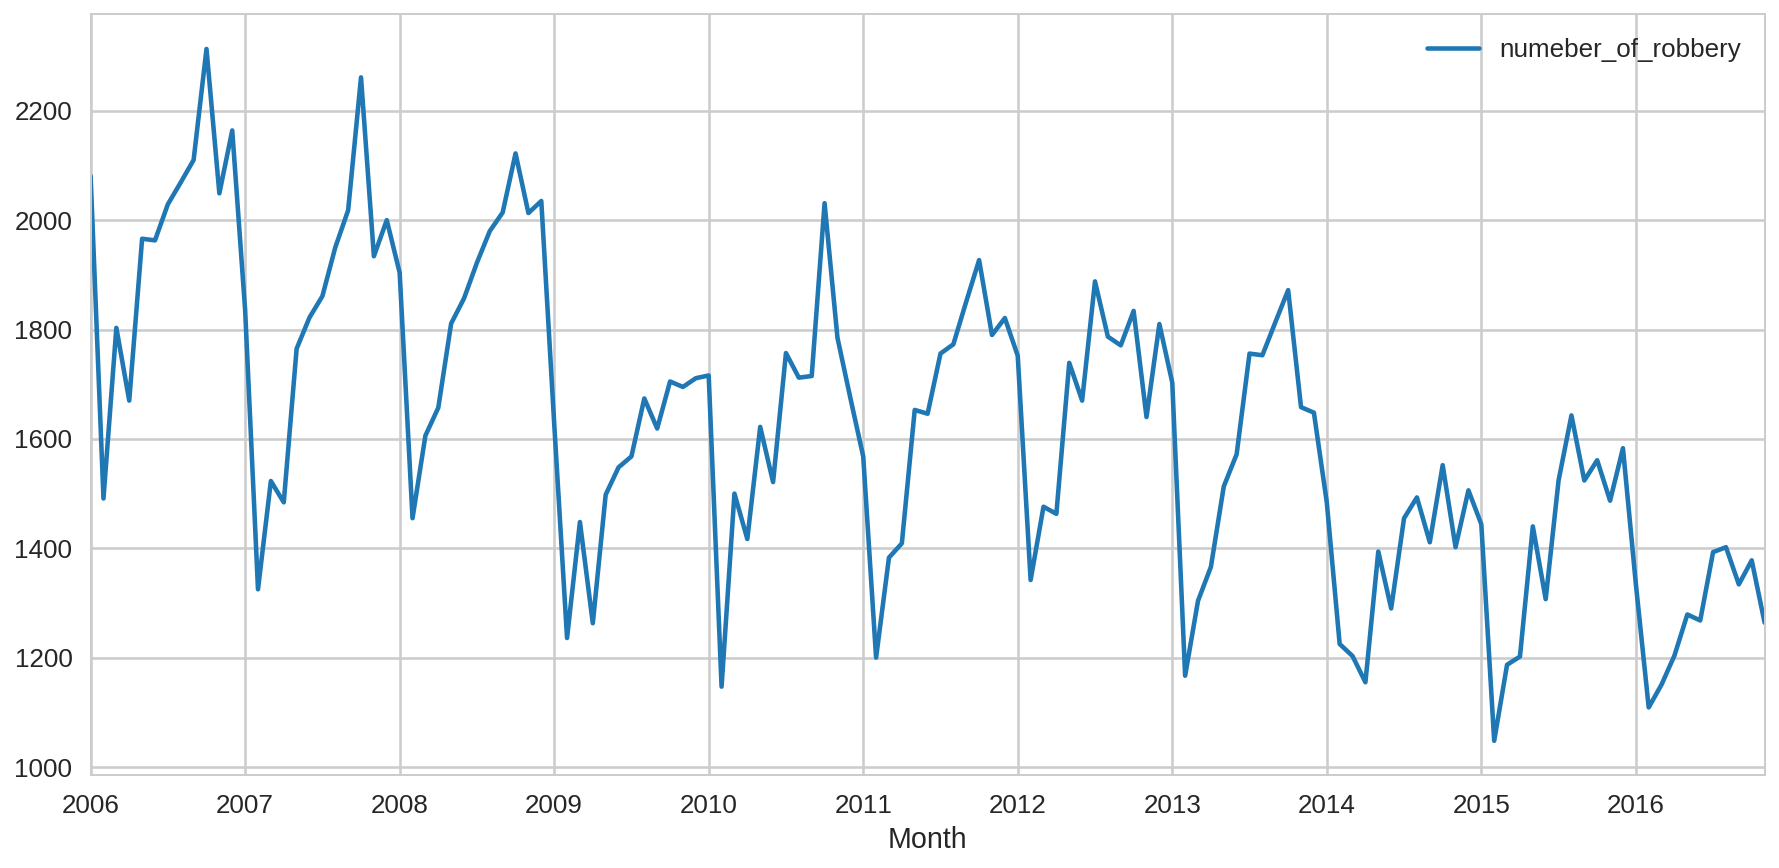

In [ ]:
query = '''
SELECT CMPLNT_FR as Month, COUNT(CMPLNT_NUM) as numeber_of_robbery, OFNS_DESC as type_of_complaint
FROM nypd
WHERE CMPLNT_FR BETWEEN '2006-01-01' AND '2016-11-31'
AND LAW_CAT_CD = 'FELONY'
AND OFNS_DESC IN ('ROBBERY')
GROUP BY CMPLNT_FR, OFNS_DESC;
'''


big_7 = pd.read_sql(query, con=engine)
big_7.set_index("Month", inplace=True)
big_7_time_robbery_month = big_7.resample('1M').sum()
big_7_time_robbery_month.plot()



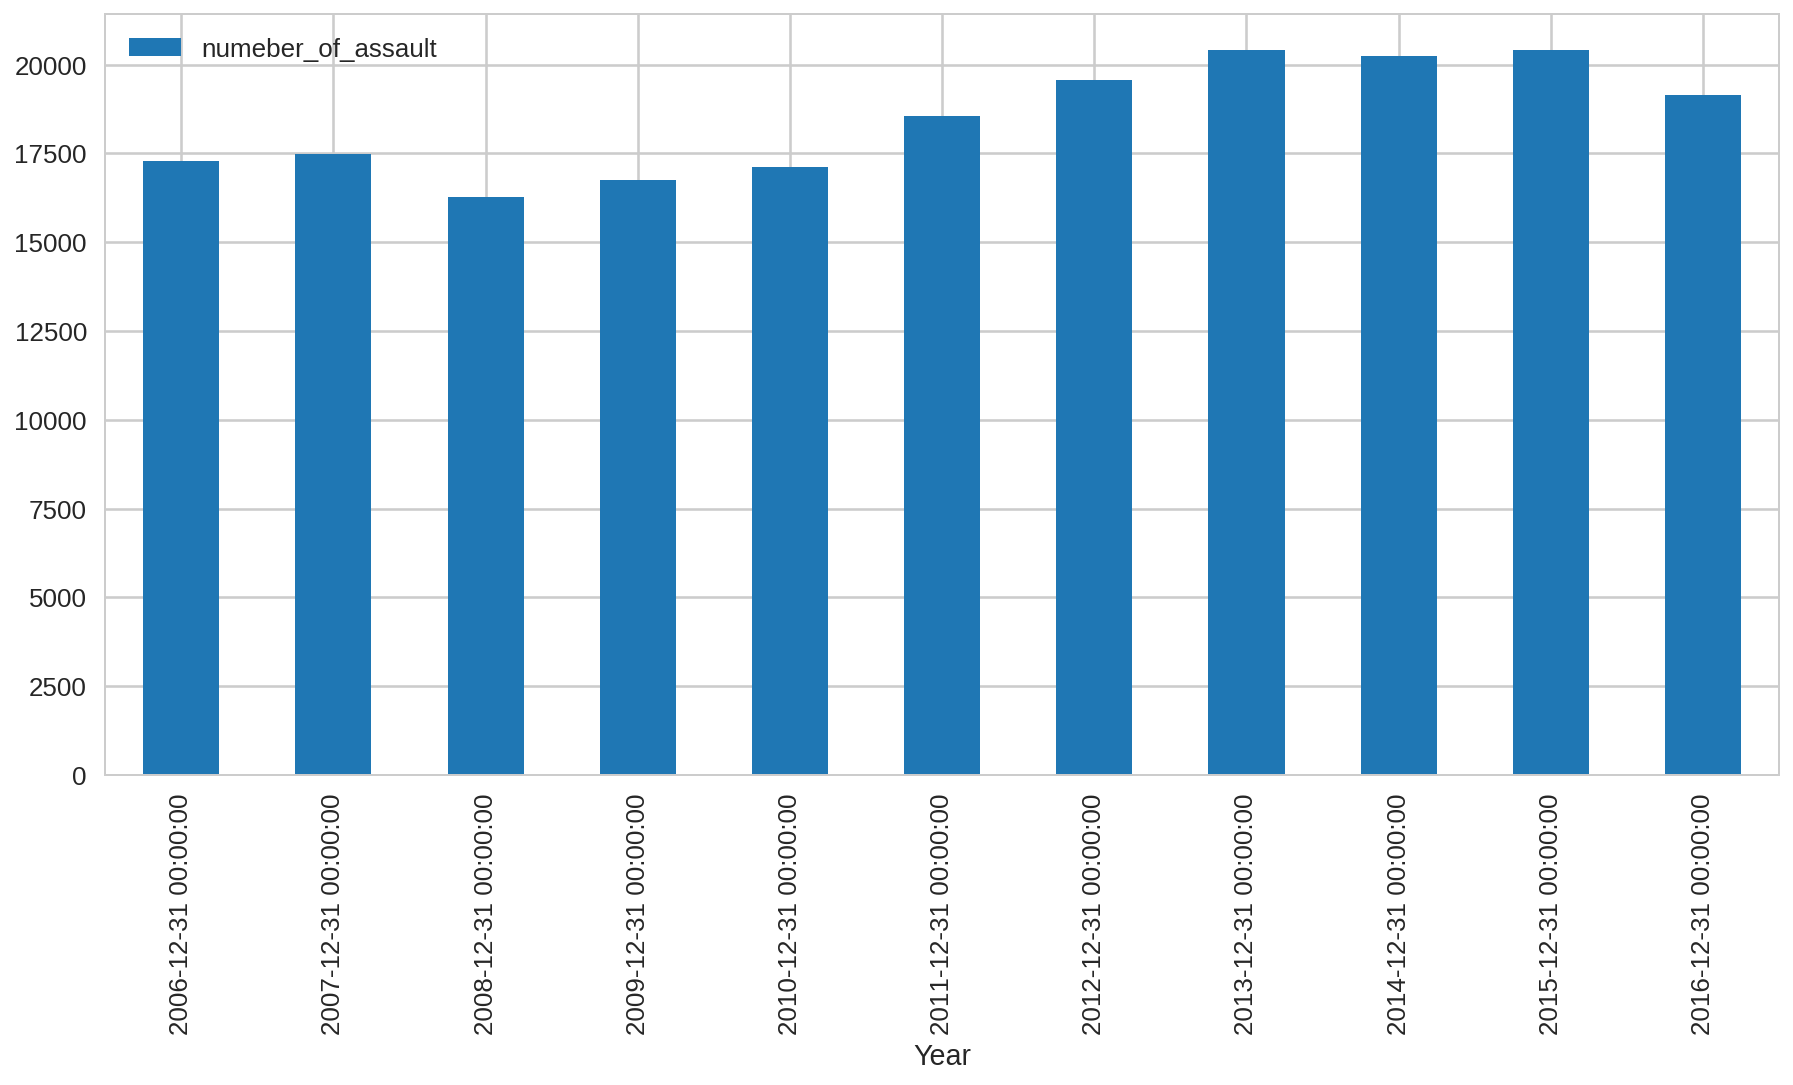

In [ ]:
query = '''
SELECT CMPLNT_FR as Year, COUNT(CMPLNT_NUM) as numeber_of_assault, OFNS_DESC as type_of_complaint
FROM nypd
WHERE CMPLNT_FR BETWEEN '2006-01-01' AND '2016-11-31'
AND LAW_CAT_CD = 'FELONY'
AND OFNS_DESC IN ('FELONY ASSAULT')
GROUP BY CMPLNT_FR, OFNS_DESC;
'''


big_7 = pd.read_sql(query, con=engine)
big_7.set_index("Year", inplace=True)
big_7_time_assult_year = big_7.resample('1Y').sum()
big_7_time_assult_year.plot(kind='bar')



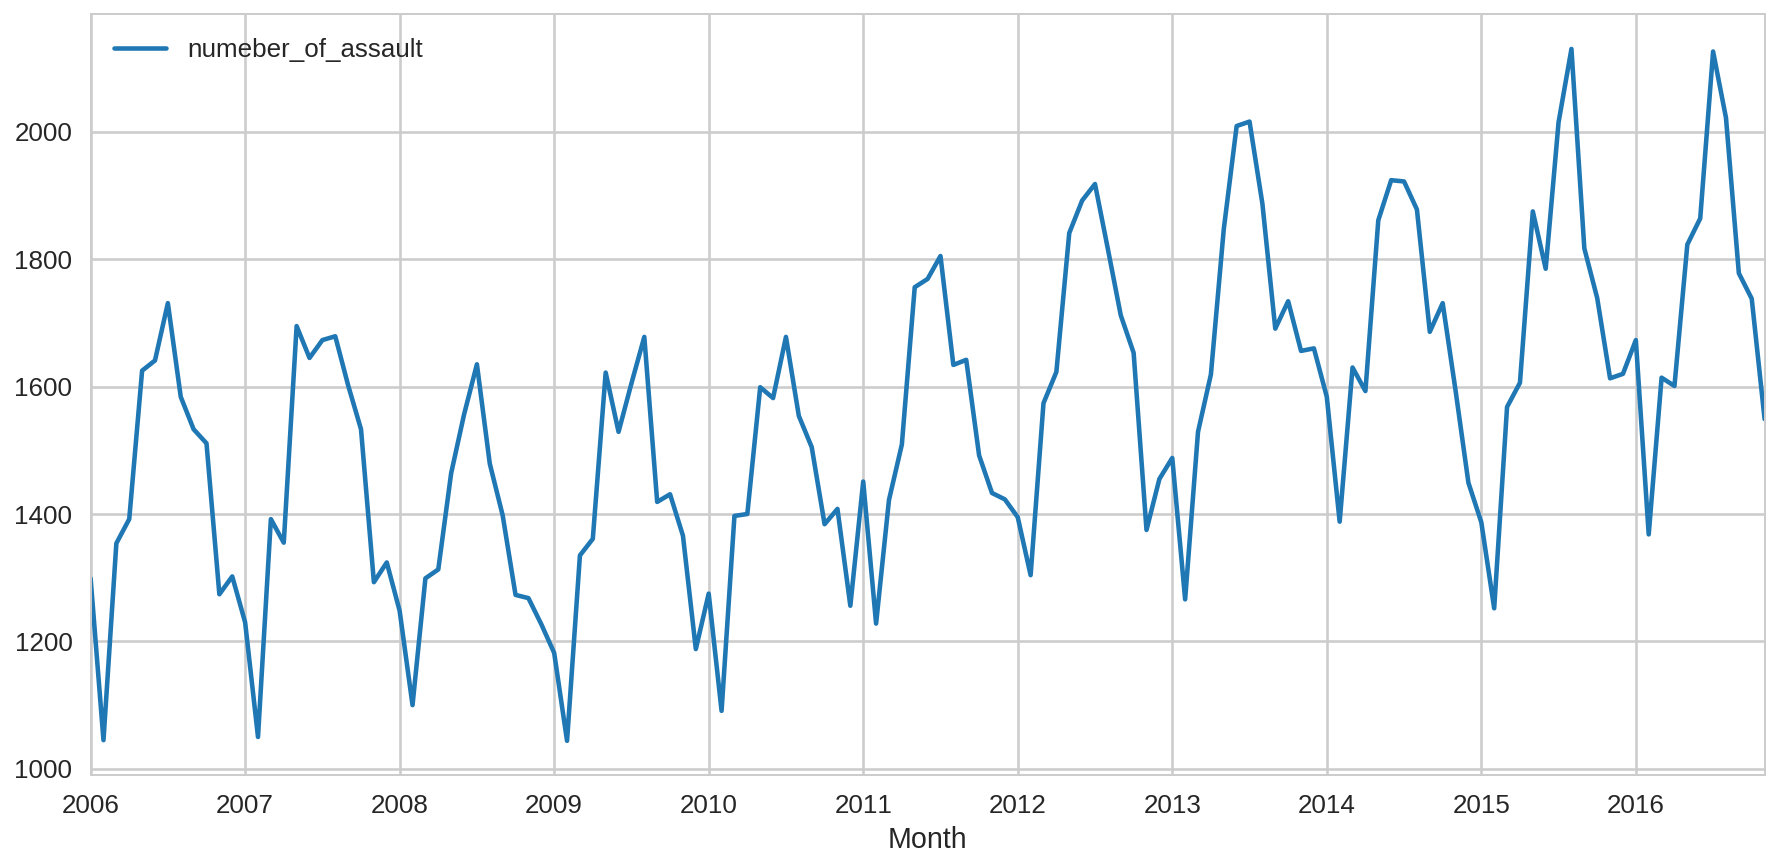

In [ ]:
query = '''
SELECT CMPLNT_FR as Month, COUNT(CMPLNT_NUM) as numeber_of_assault, OFNS_DESC as type_of_complaint
FROM nypd
WHERE CMPLNT_FR BETWEEN '2006-01-01' AND '2016-11-31'
AND LAW_CAT_CD = 'FELONY'
AND OFNS_DESC IN ('FELONY ASSAULT')
GROUP BY CMPLNT_FR, OFNS_DESC;
'''


big_7 = pd.read_sql(query, con=engine)
big_7.set_index("Month", inplace=True)
big_7_time_assult_month = big_7.resample('1M').sum()
big_7_time_assult_month.plot()



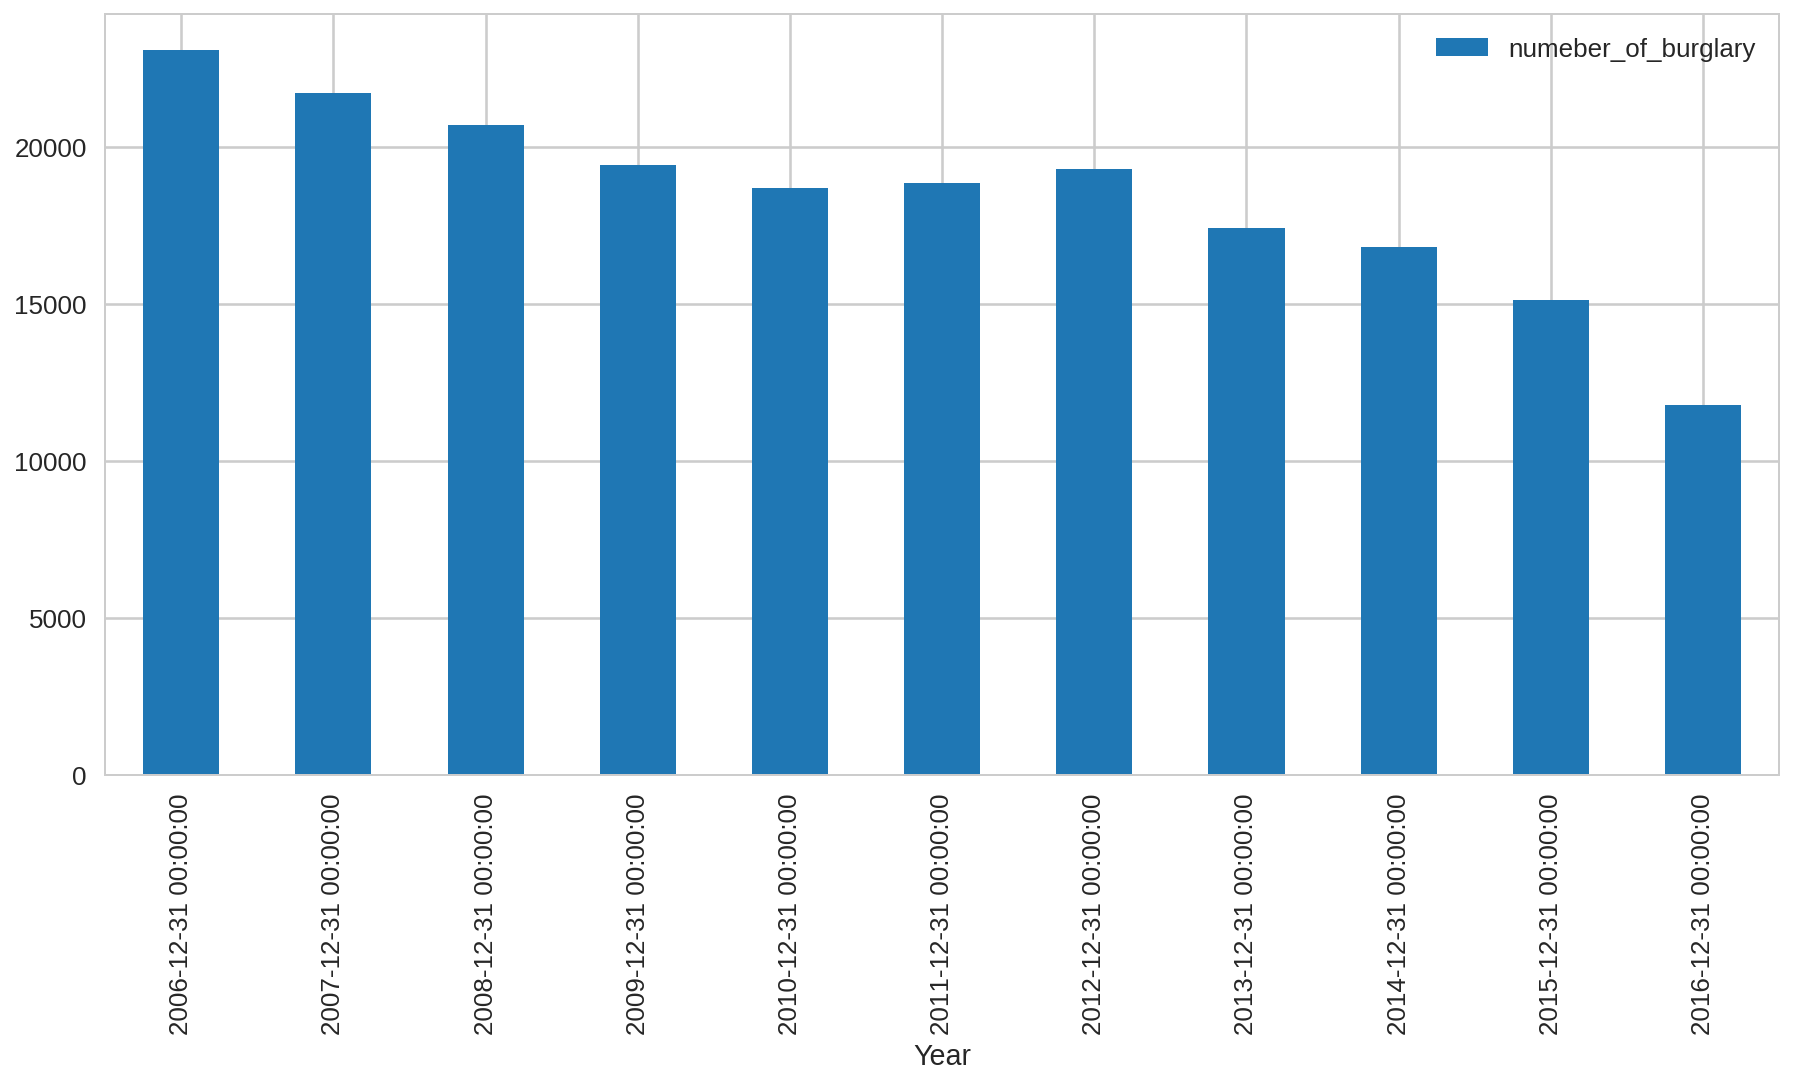

In [ ]:
query = '''
SELECT CMPLNT_FR as Year, COUNT(CMPLNT_NUM) as numeber_of_burglary, OFNS_DESC as type_of_complaint
FROM nypd
WHERE CMPLNT_FR BETWEEN '2006-01-01' AND '2016-11-31'
AND LAW_CAT_CD = 'FELONY'
AND OFNS_DESC IN ('BURGLARY')
GROUP BY CMPLNT_FR, OFNS_DESC;
'''


big_7 = pd.read_sql(query, con=engine)
big_7.set_index("Year", inplace=True)
big_7_time_burglary_year = big_7.resample('1Y').sum()
big_7_time_burglary_year.plot(kind='bar')


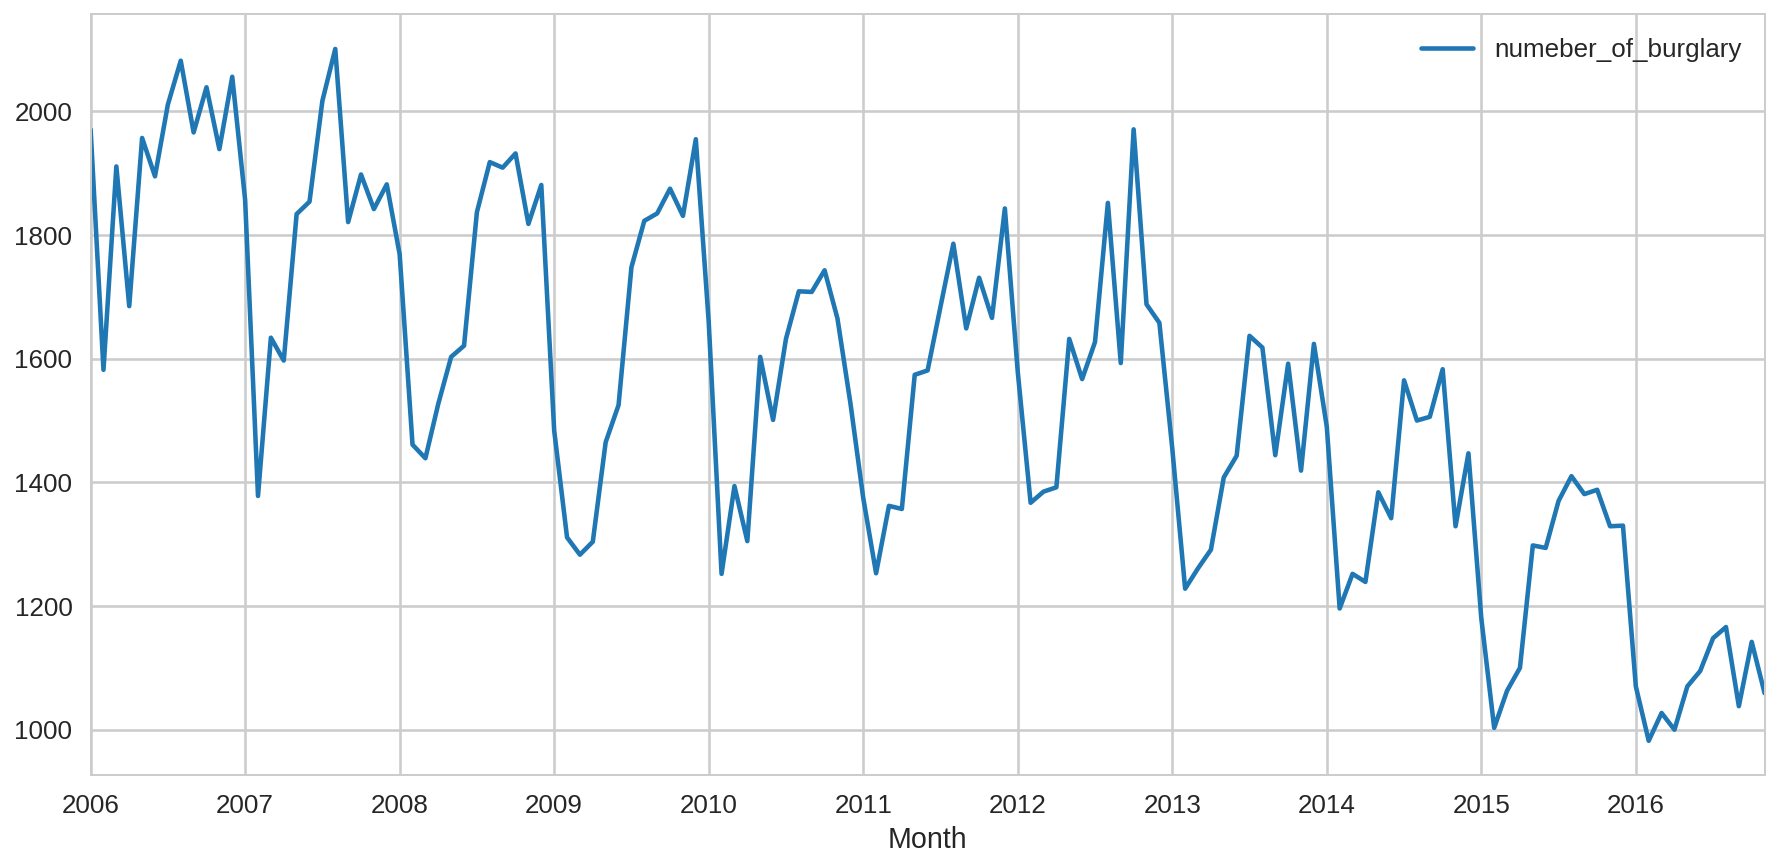

In [ ]:
query = '''
SELECT CMPLNT_FR as Month, COUNT(CMPLNT_NUM) as numeber_of_burglary, OFNS_DESC as type_of_complaint
FROM nypd
WHERE CMPLNT_FR BETWEEN '2006-01-01' AND '2016-11-31'
AND LAW_CAT_CD = 'FELONY'
AND OFNS_DESC IN ('BURGLARY')
GROUP BY CMPLNT_FR, OFNS_DESC;
'''


big_7 = pd.read_sql(query, con=engine)
big_7.set_index("Month", inplace=True)
big_7_time_burglary_month = big_7.resample('1M').sum()
big_7_time_burglary_month.plot()


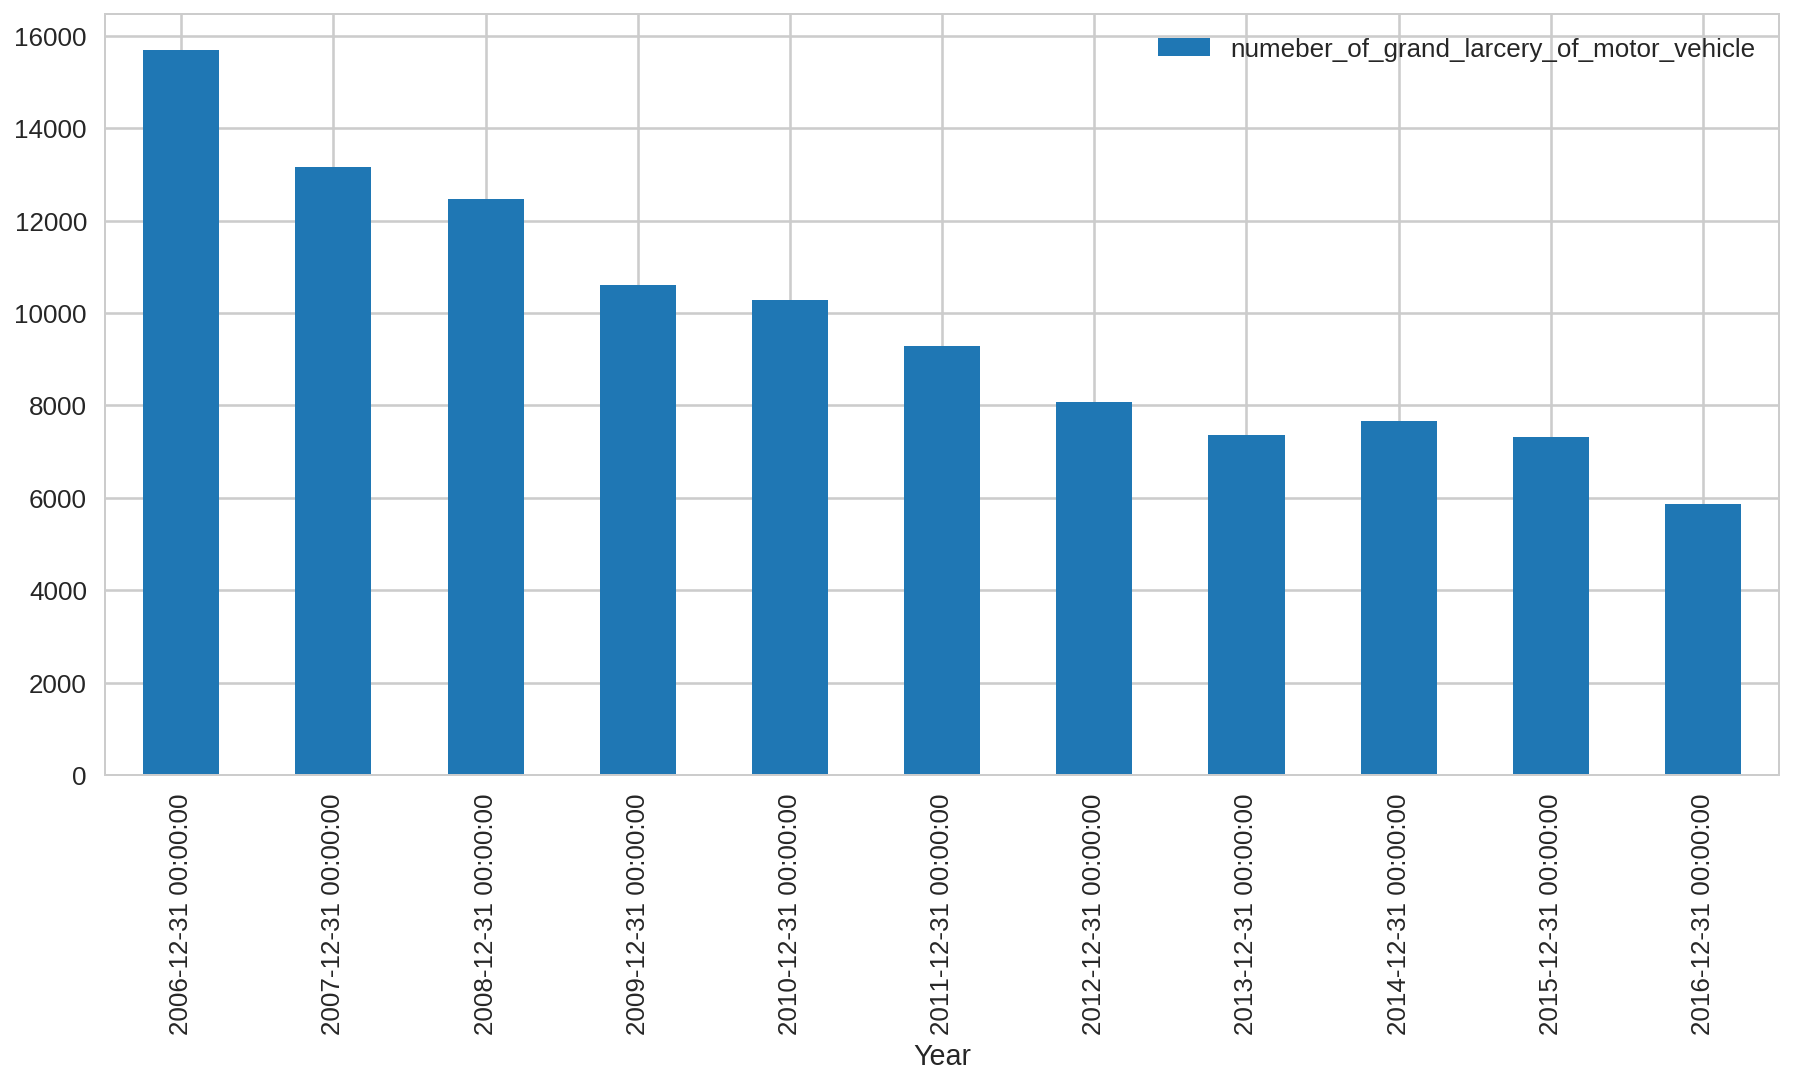

In [ ]:
query = '''
SELECT CMPLNT_FR as Year, COUNT(CMPLNT_NUM) as numeber_of_grand_larcery_of_motor_vehicle, OFNS_DESC as type_of_complaint
FROM nypd
WHERE CMPLNT_FR BETWEEN '2006-01-01' AND '2016-11-31'
AND LAW_CAT_CD = 'FELONY'
AND OFNS_DESC IN ('GRAND LARCENY OF MOTOR VEHICLE')
GROUP BY CMPLNT_FR, OFNS_DESC;
'''


big_7 = pd.read_sql(query, con=engine)
big_7.set_index("Year", inplace=True)
big_7_time_grand_larcery_of_motor_vehicle_year = big_7.resample('1Y').sum()
big_7_time_grand_larcery_of_motor_vehicle_year.plot(kind='bar')


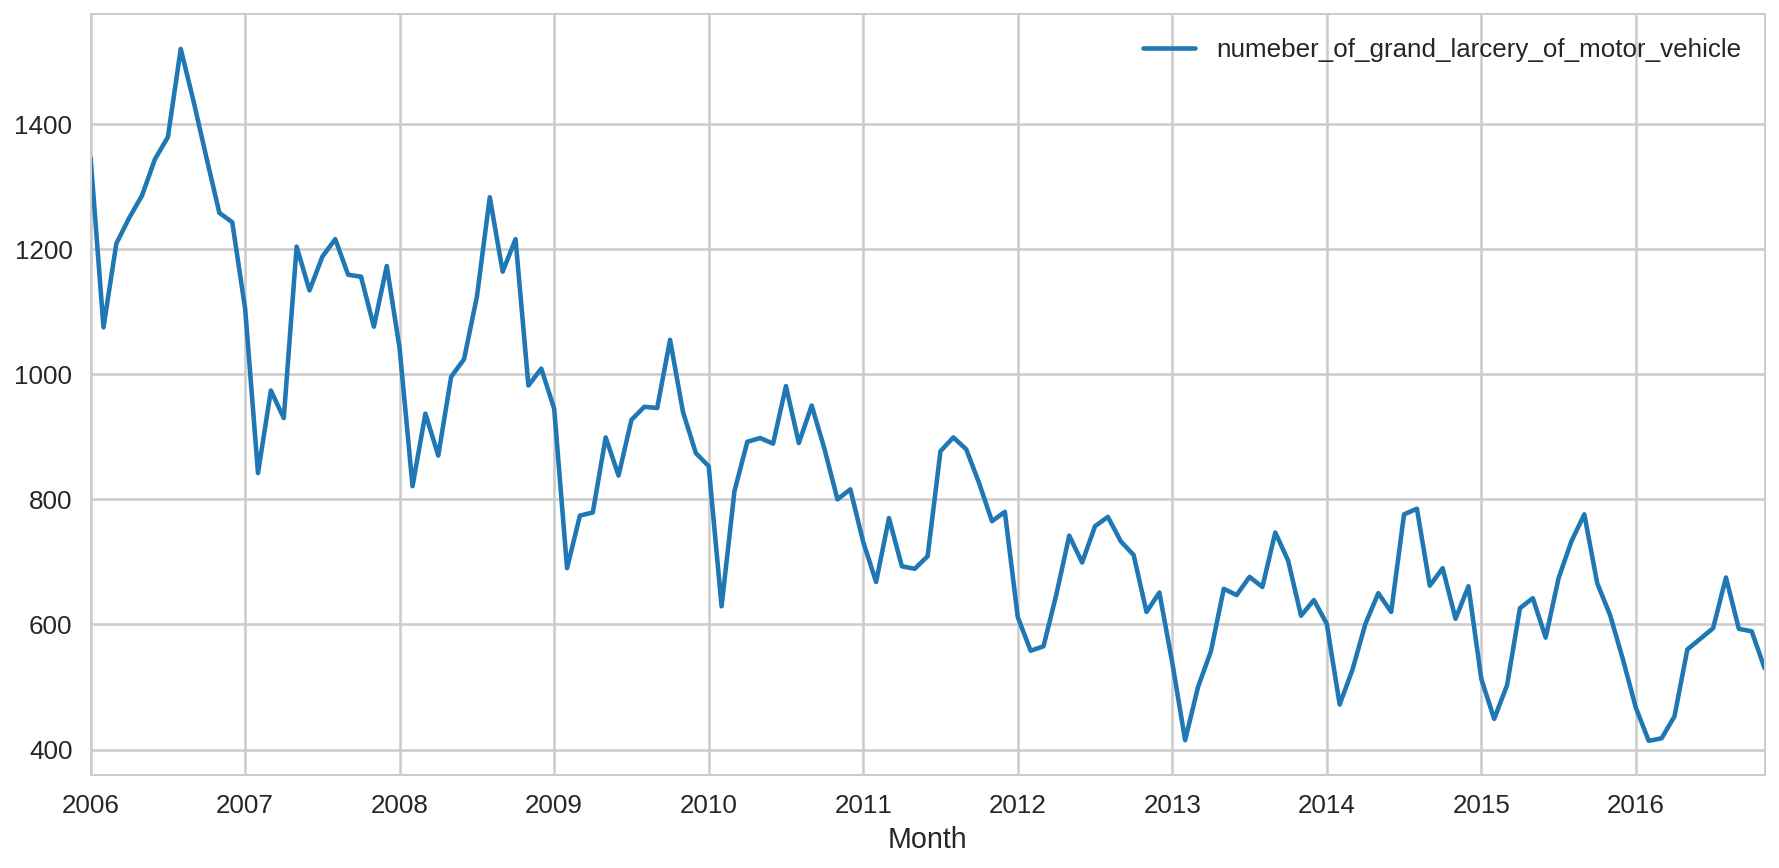

In [ ]:
query = '''
SELECT CMPLNT_FR as Month, COUNT(CMPLNT_NUM) as numeber_of_grand_larcery_of_motor_vehicle, OFNS_DESC as type_of_complaint
FROM nypd
WHERE CMPLNT_FR BETWEEN '2006-01-01' AND '2016-11-31'
AND LAW_CAT_CD = 'FELONY'
AND OFNS_DESC IN ('GRAND LARCENY OF MOTOR VEHICLE')
GROUP BY CMPLNT_FR, OFNS_DESC;
'''


big_7 = pd.read_sql(query, con=engine)
big_7.set_index("Month", inplace=True)
big_7_time_grand_larcery_of_motor_vehicle_month = big_7.resample('1M').sum()
big_7_time_grand_larcery_of_motor_vehicle_month.plot()


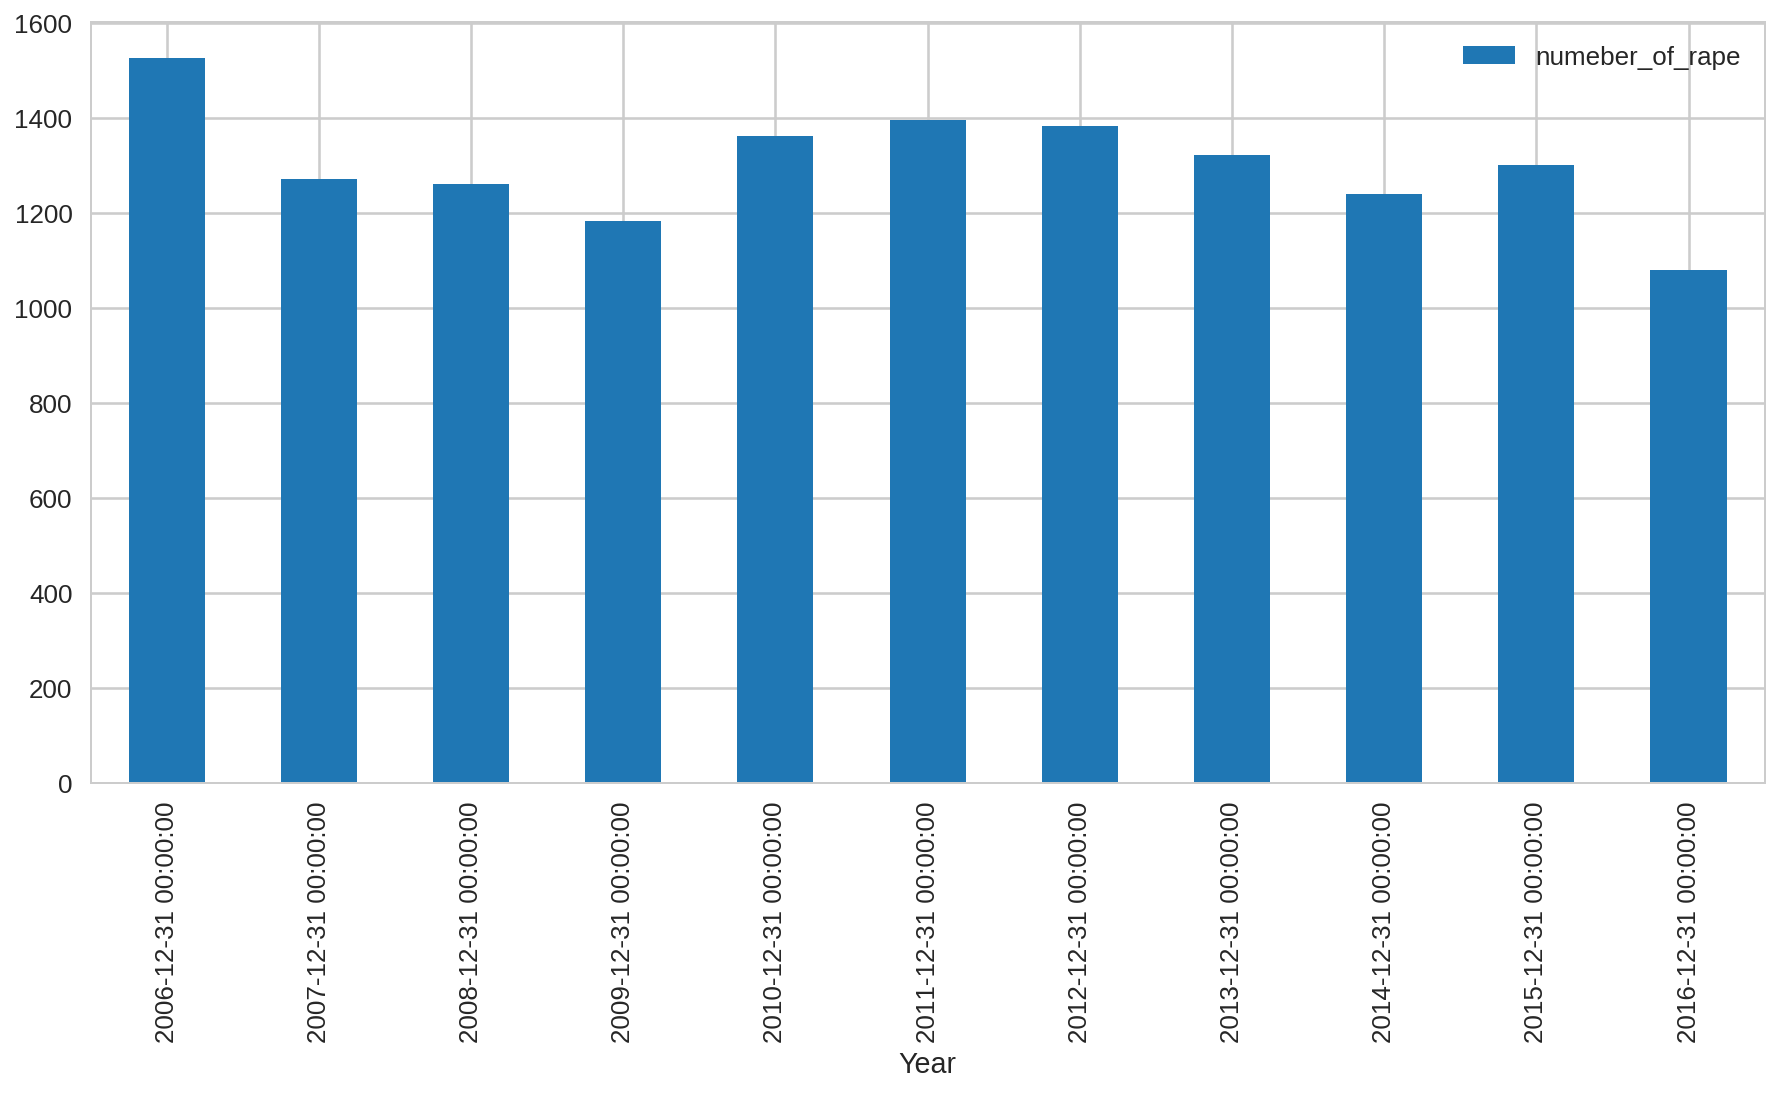

In [ ]:
query = '''
SELECT CMPLNT_FR as Year, COUNT(CMPLNT_NUM) as numeber_of_rape, OFNS_DESC as type_of_complaint
FROM nypd
WHERE CMPLNT_FR BETWEEN '2006-01-01' AND '2016-11-31'
AND LAW_CAT_CD = 'FELONY'
AND OFNS_DESC IN ('RAPE')
GROUP BY CMPLNT_FR, OFNS_DESC;
'''


big_7 = pd.read_sql(query, con=engine)
big_7.set_index("Year", inplace=True)
big_7_time_rape_year = big_7.resample('1Y').sum()
big_7_time_rape_year.plot(kind='bar')




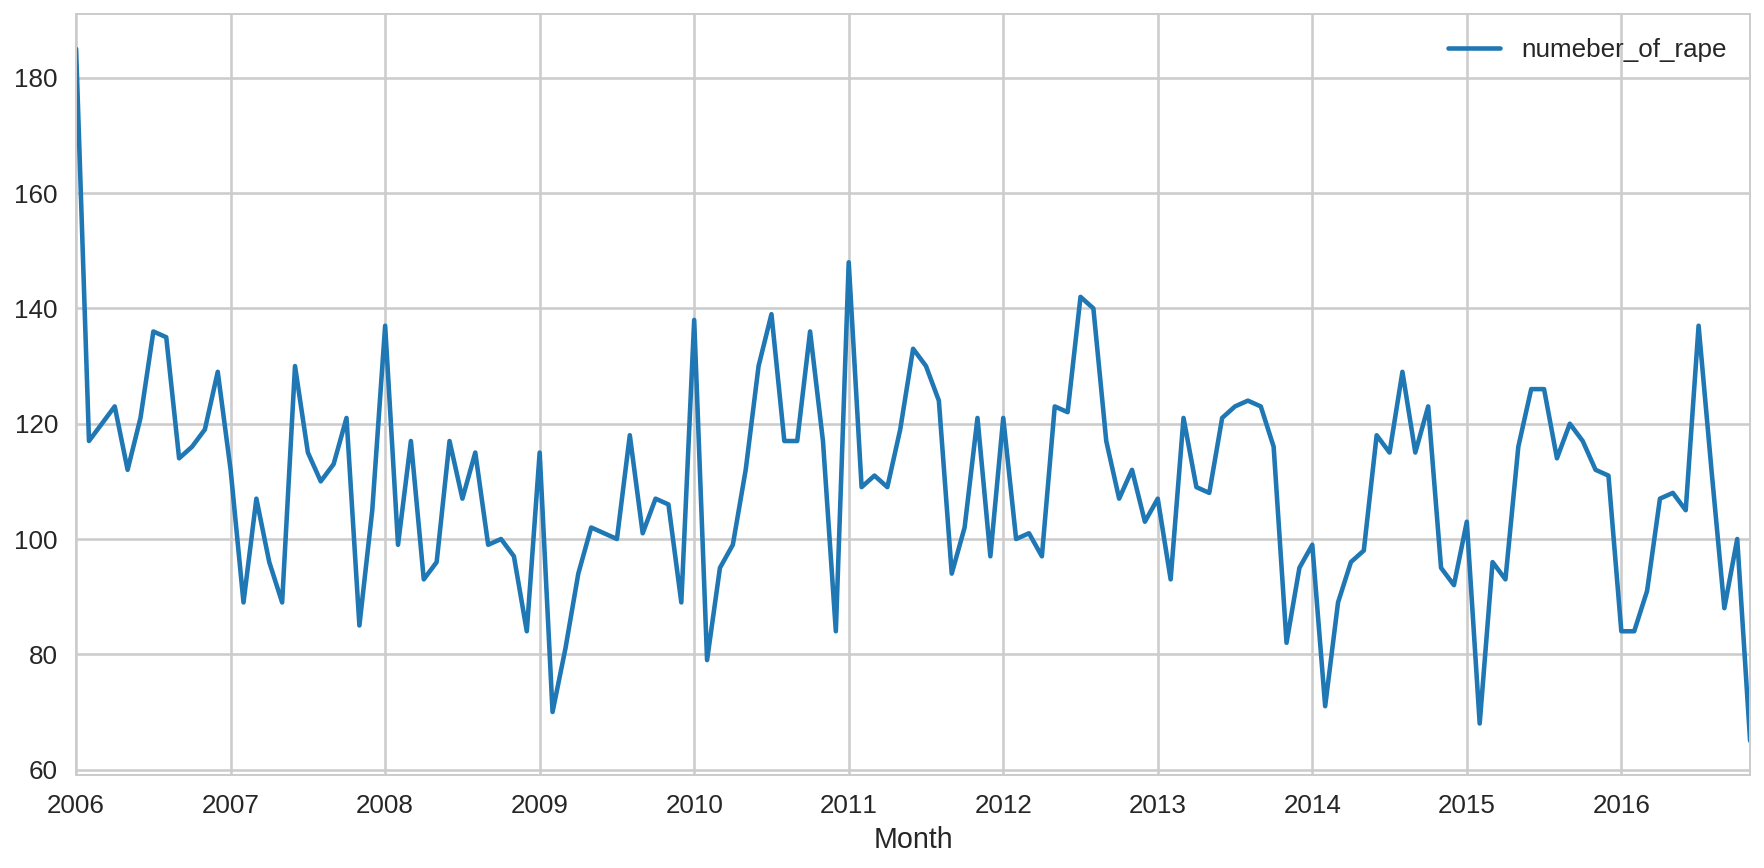

In [ ]:
query = '''
SELECT CMPLNT_FR as Month, COUNT(CMPLNT_NUM) as numeber_of_rape, OFNS_DESC as type_of_complaint
FROM nypd
WHERE CMPLNT_FR BETWEEN '2006-01-01' AND '2016-11-31'
AND LAW_CAT_CD = 'FELONY'
AND OFNS_DESC IN ('RAPE')
GROUP BY CMPLNT_FR, OFNS_DESC;
'''


big_7 = pd.read_sql(query, con=engine)
big_7.set_index("Month", inplace=True)
big_7_time_rape_month = big_7.resample('1M').sum()
big_7_time_rape_month.plot()



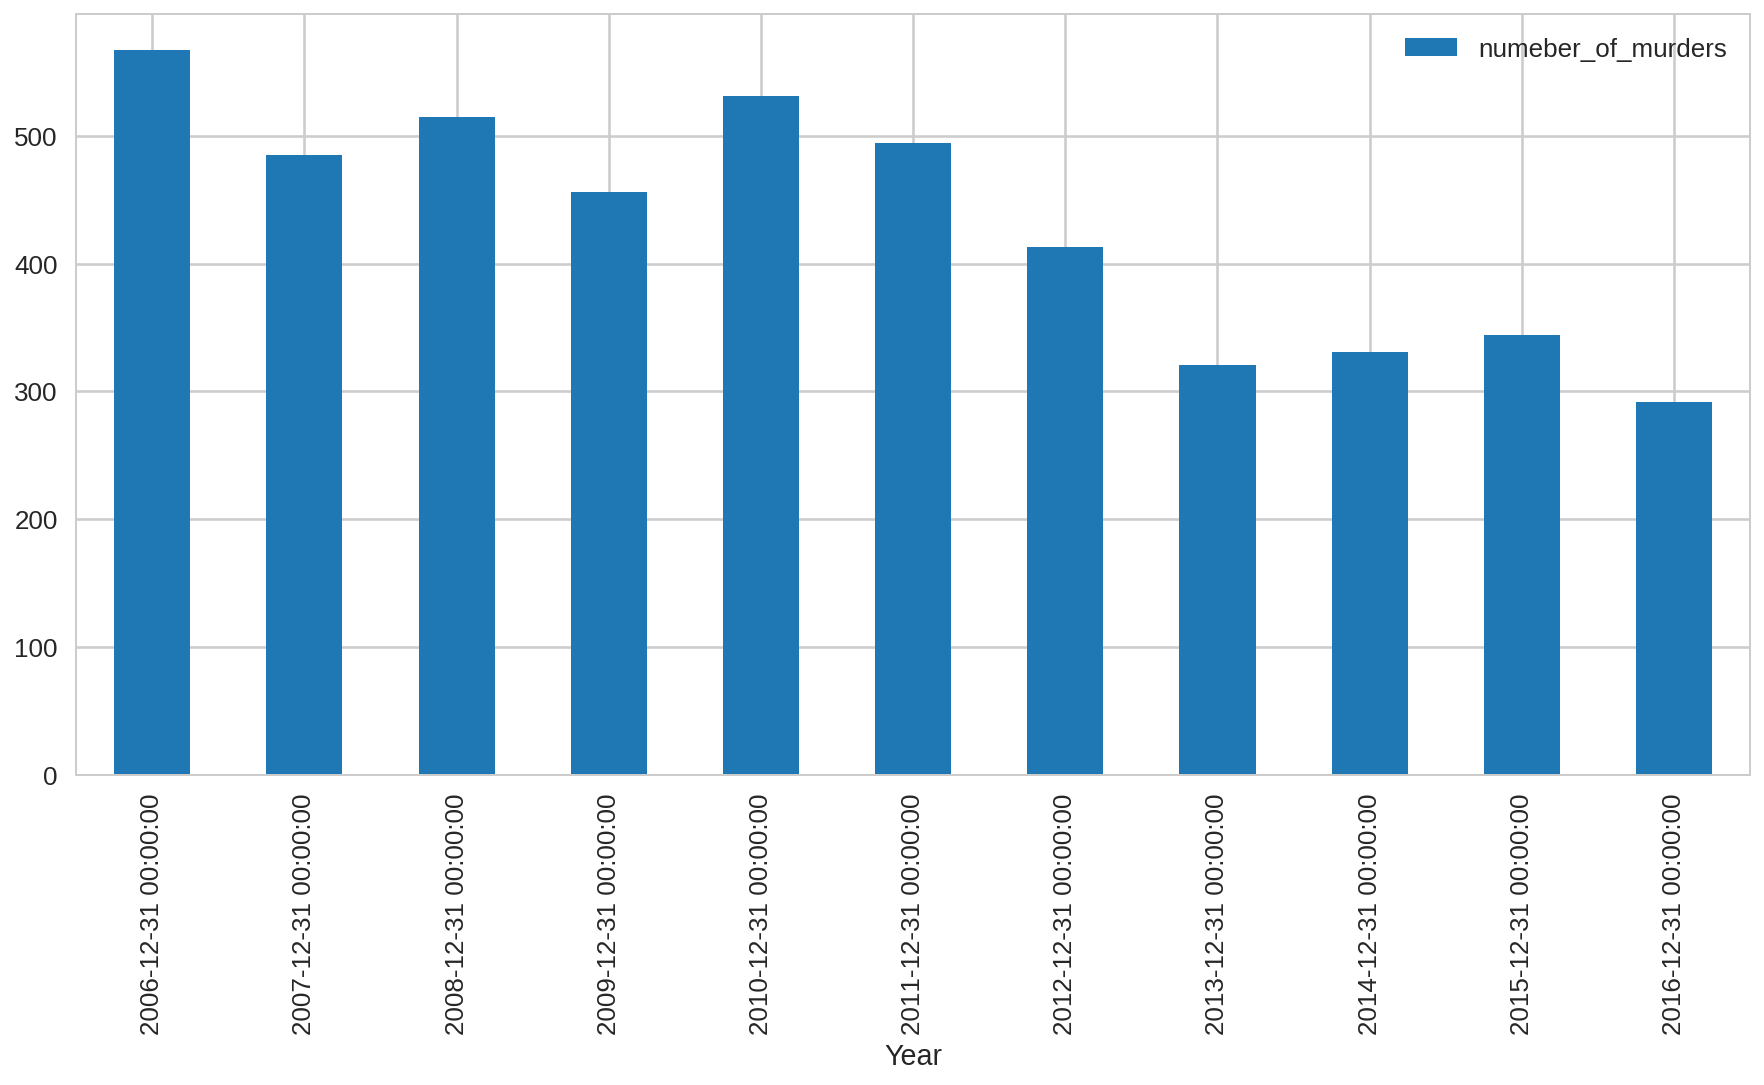

In [ ]:
query = '''
SELECT CMPLNT_FR as Year, COUNT(CMPLNT_NUM) as numeber_of_murders, OFNS_DESC as type_of_complaint
FROM nypd
WHERE CMPLNT_FR BETWEEN '2006-01-01' AND '2016-11-31'
AND LAW_CAT_CD = 'FELONY'
AND OFNS_DESC IN ('MURDER & NON-NEGL. MANSLAUGHTER')
GROUP BY CMPLNT_FR, OFNS_DESC;
'''


big_7 = pd.read_sql(query, con=engine)
big_7.set_index("Year", inplace=True)
big_7_time_murder_year = big_7.resample('1Y').sum()
big_7_time_murder_year.plot(kind='bar')


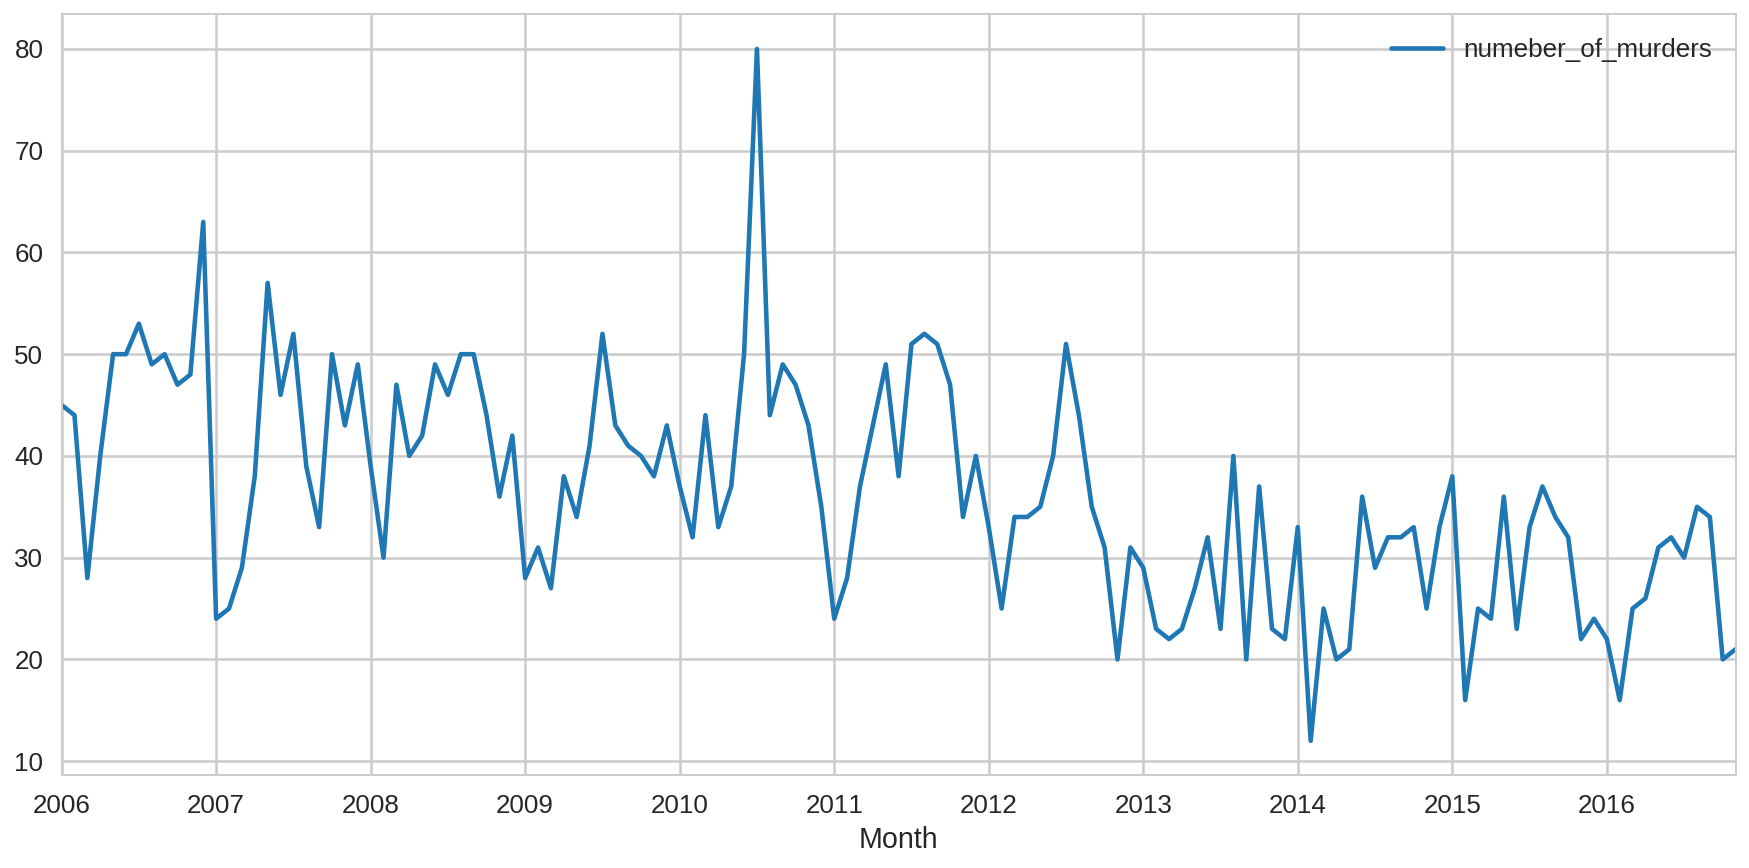

In [ ]:
query = '''
SELECT CMPLNT_FR as Month, COUNT(CMPLNT_NUM) as numeber_of_murders, OFNS_DESC as type_of_complaint
FROM nypd
WHERE CMPLNT_FR BETWEEN '2006-01-01' AND '2016-11-31'
AND LAW_CAT_CD = 'FELONY'
AND OFNS_DESC IN ('MURDER & NON-NEGL. MANSLAUGHTER')
GROUP BY CMPLNT_FR, OFNS_DESC;
'''


big_7 = pd.read_sql(query, con=engine)
big_7.set_index("Month", inplace=True)
big_7_time_murder_month = big_7.resample('1M').sum()
big_7_time_murder_month.plot()

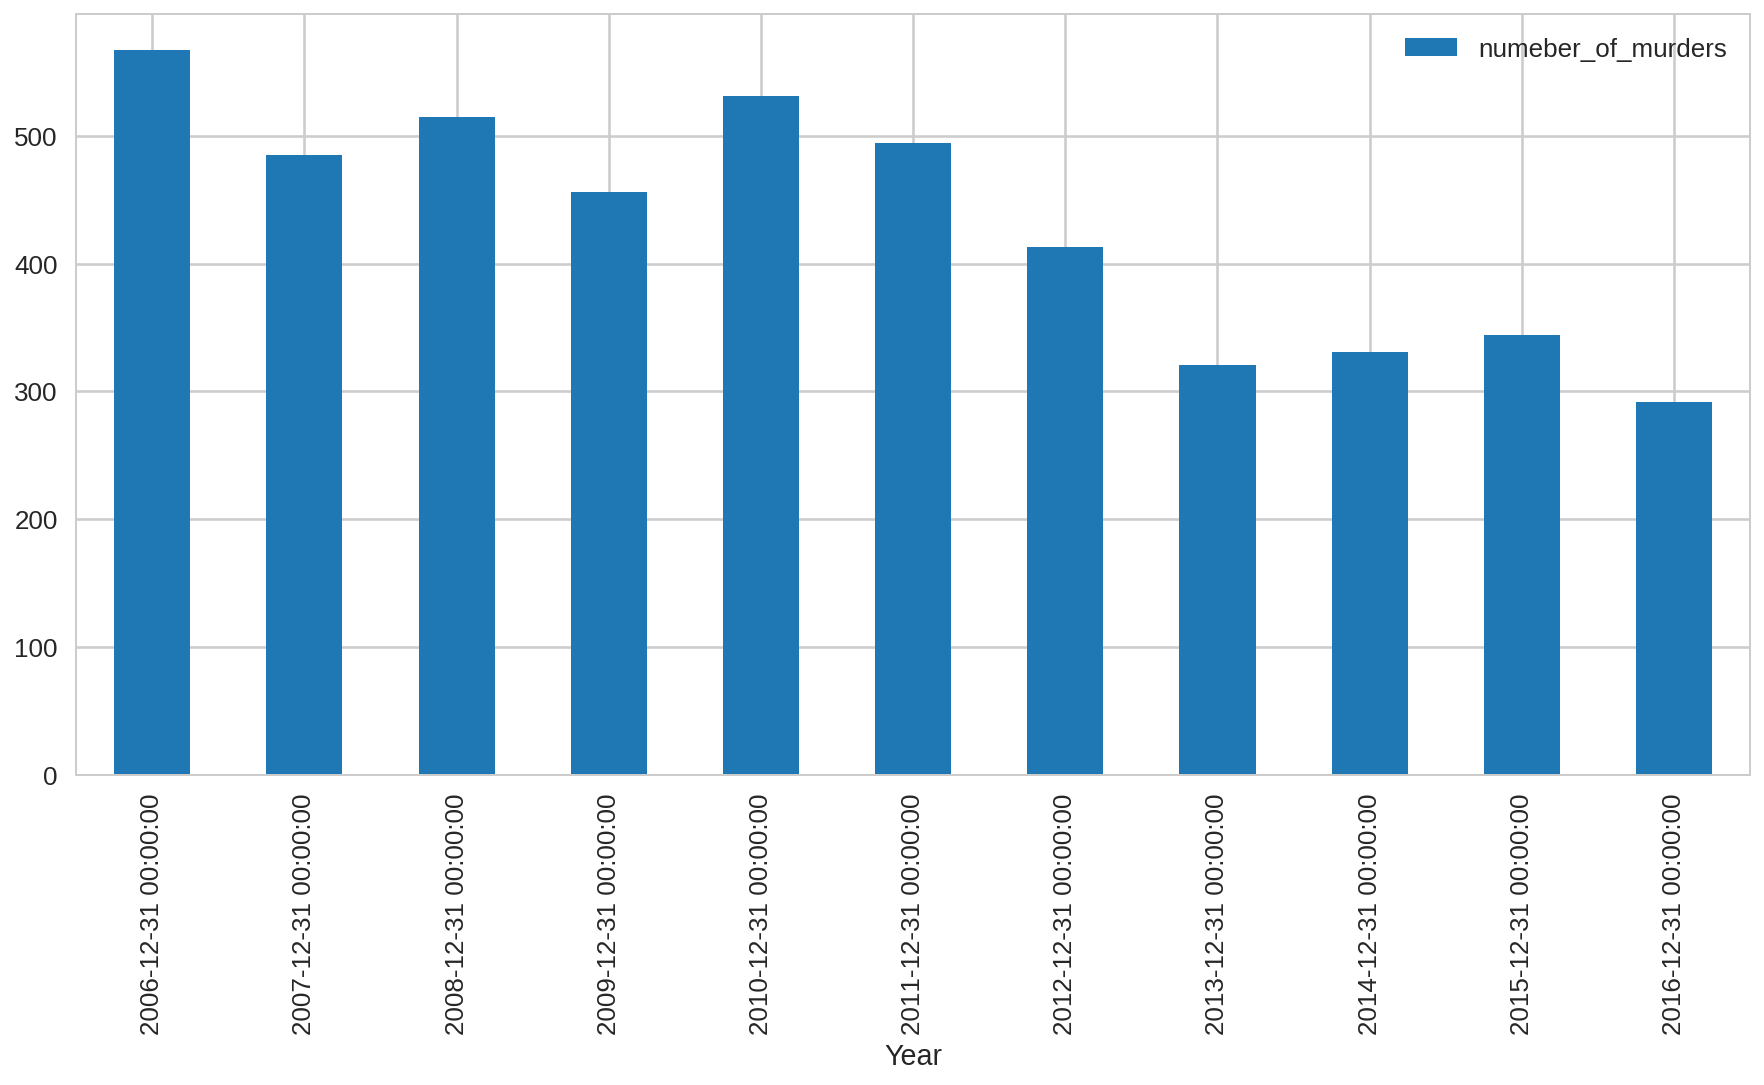

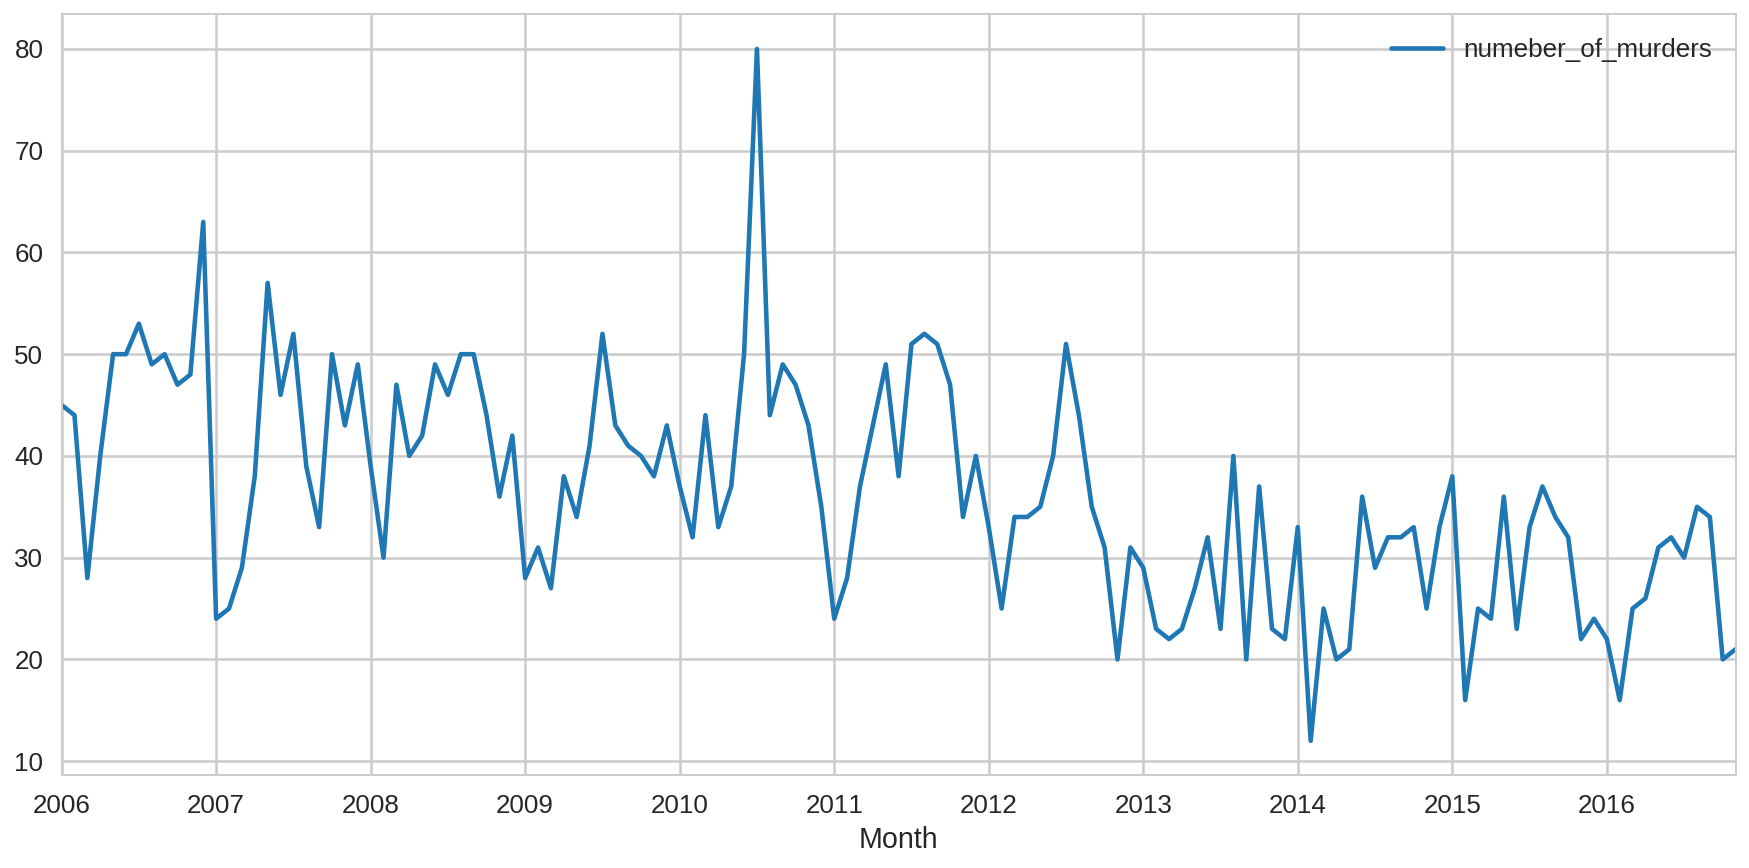

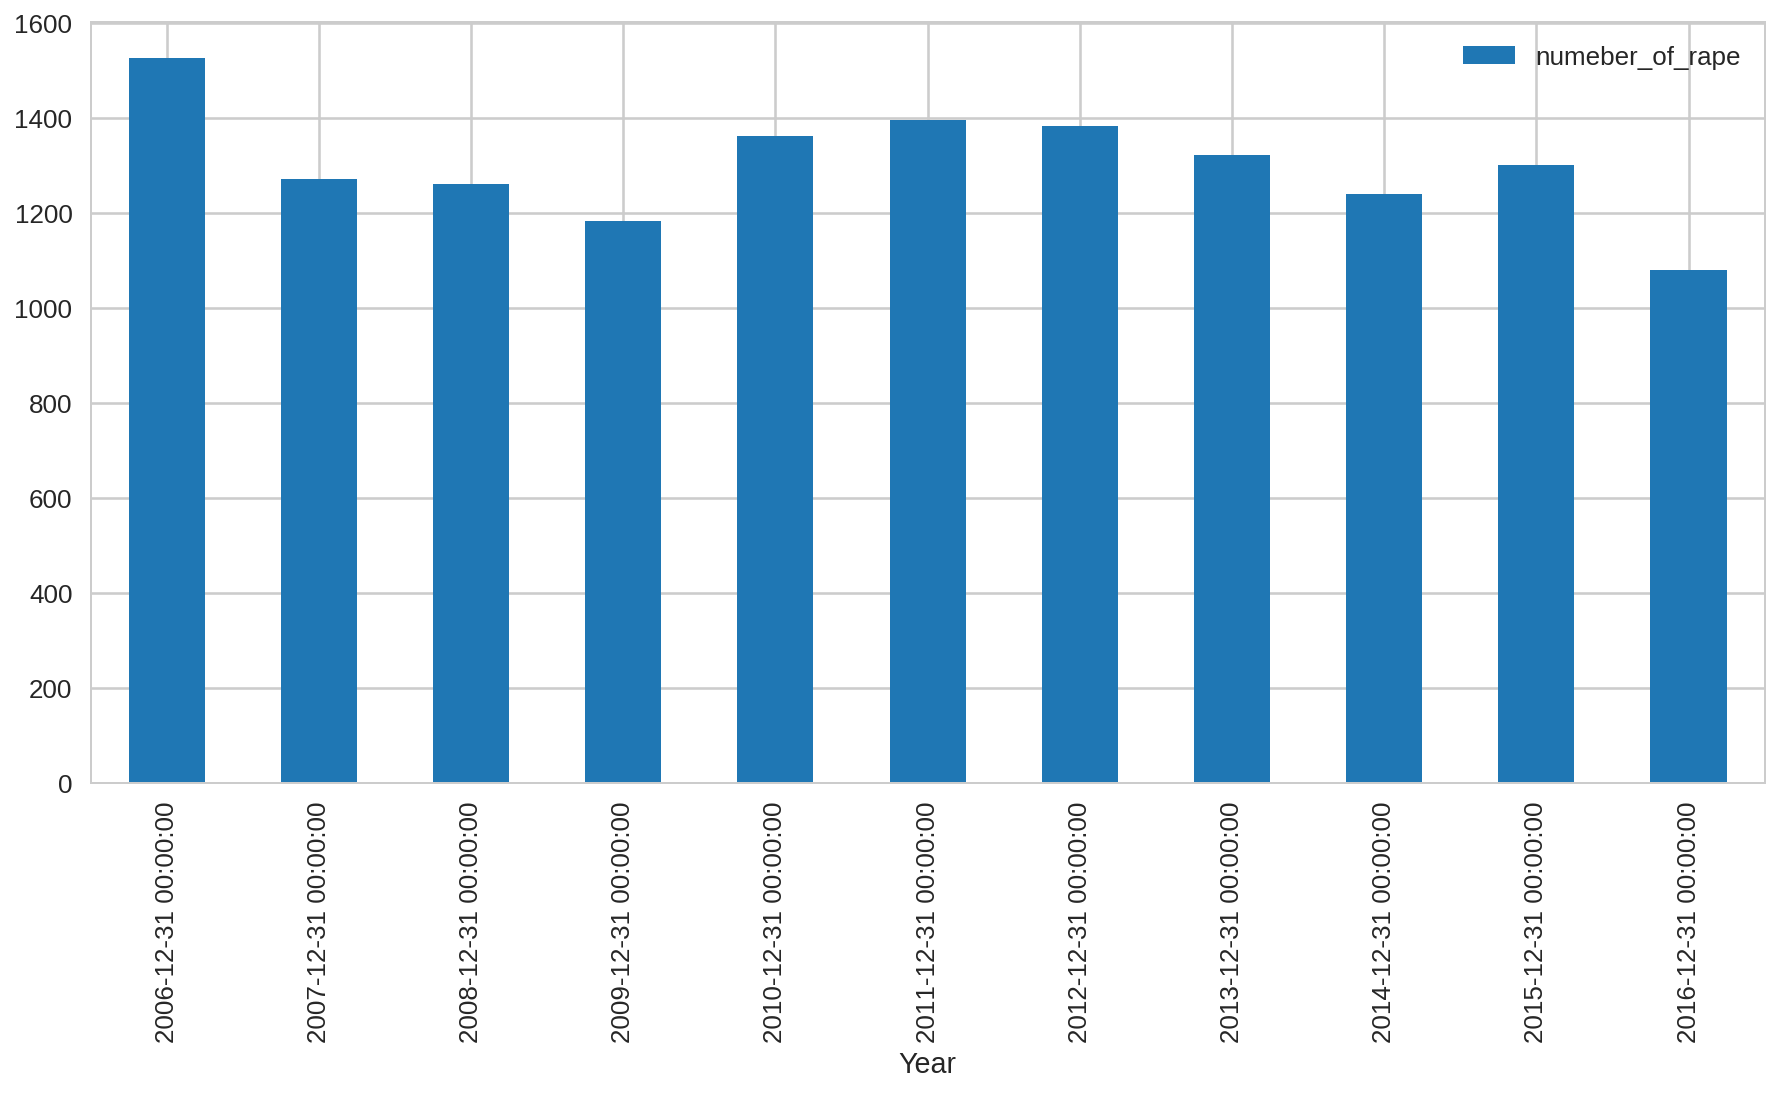

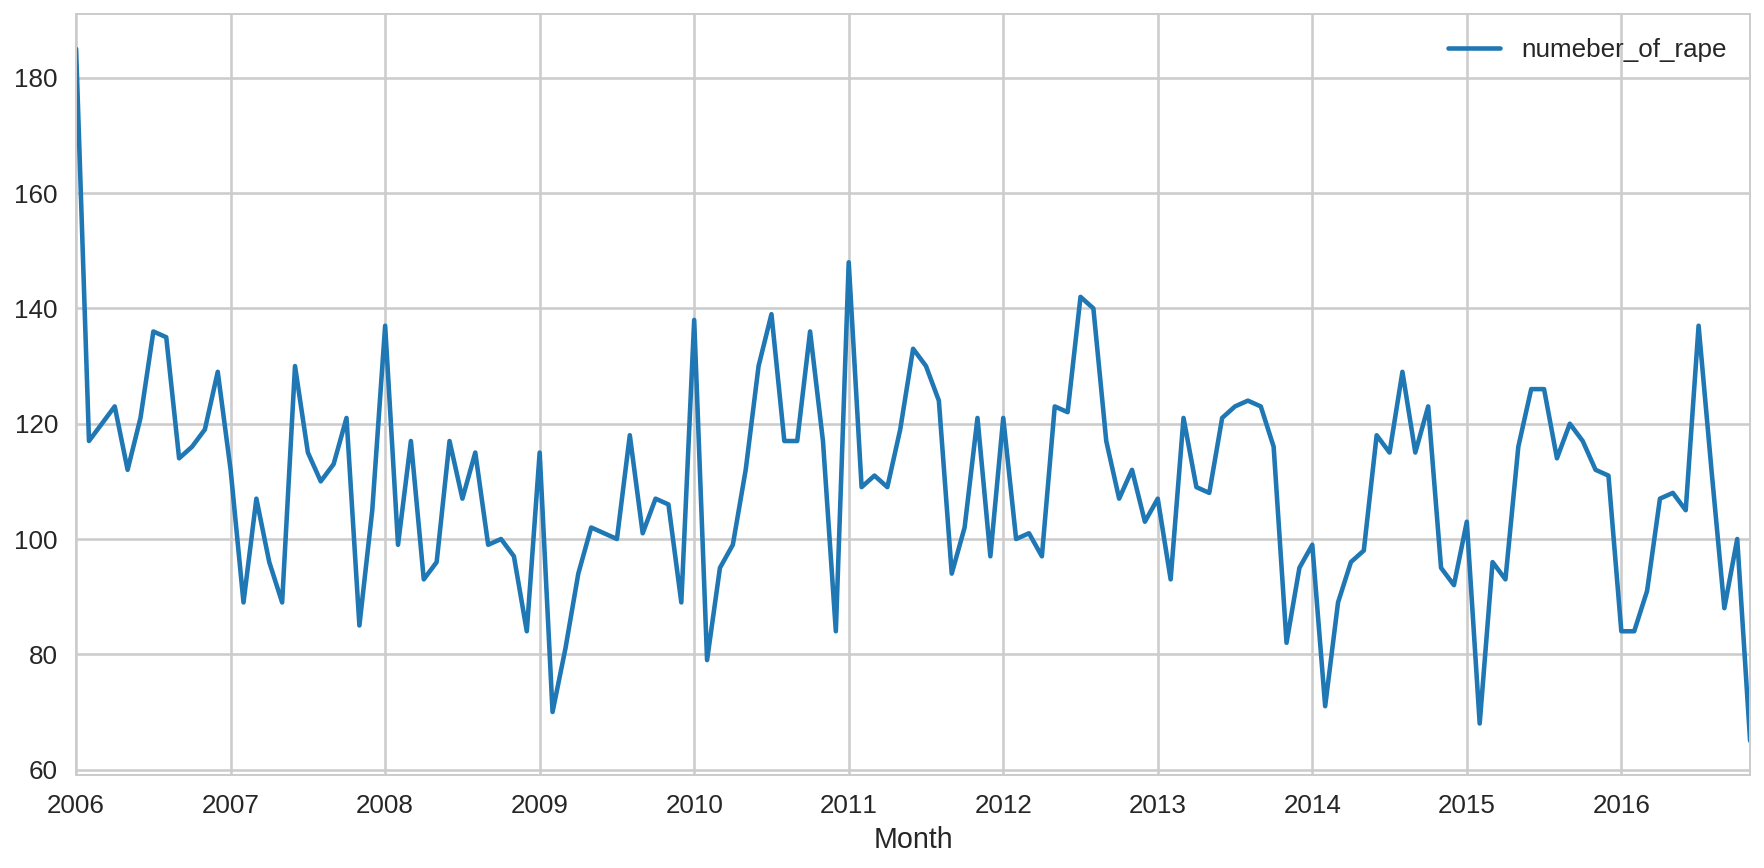

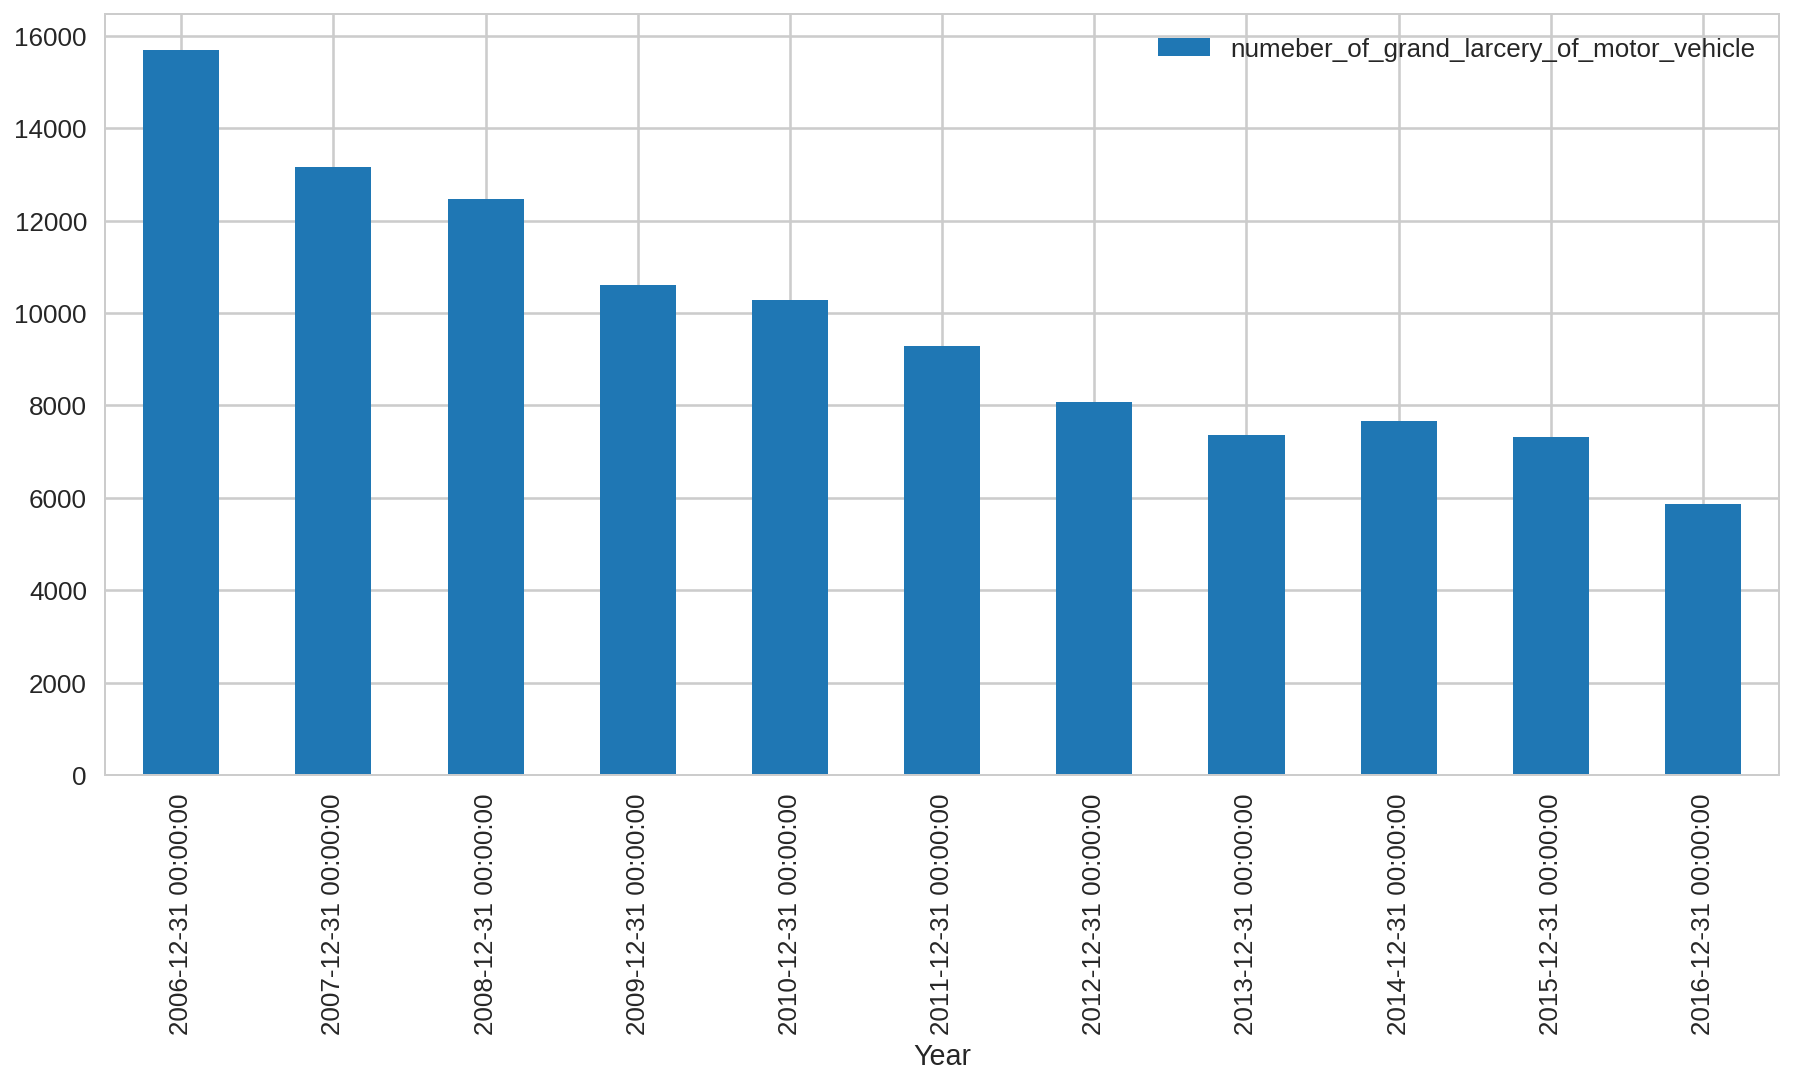

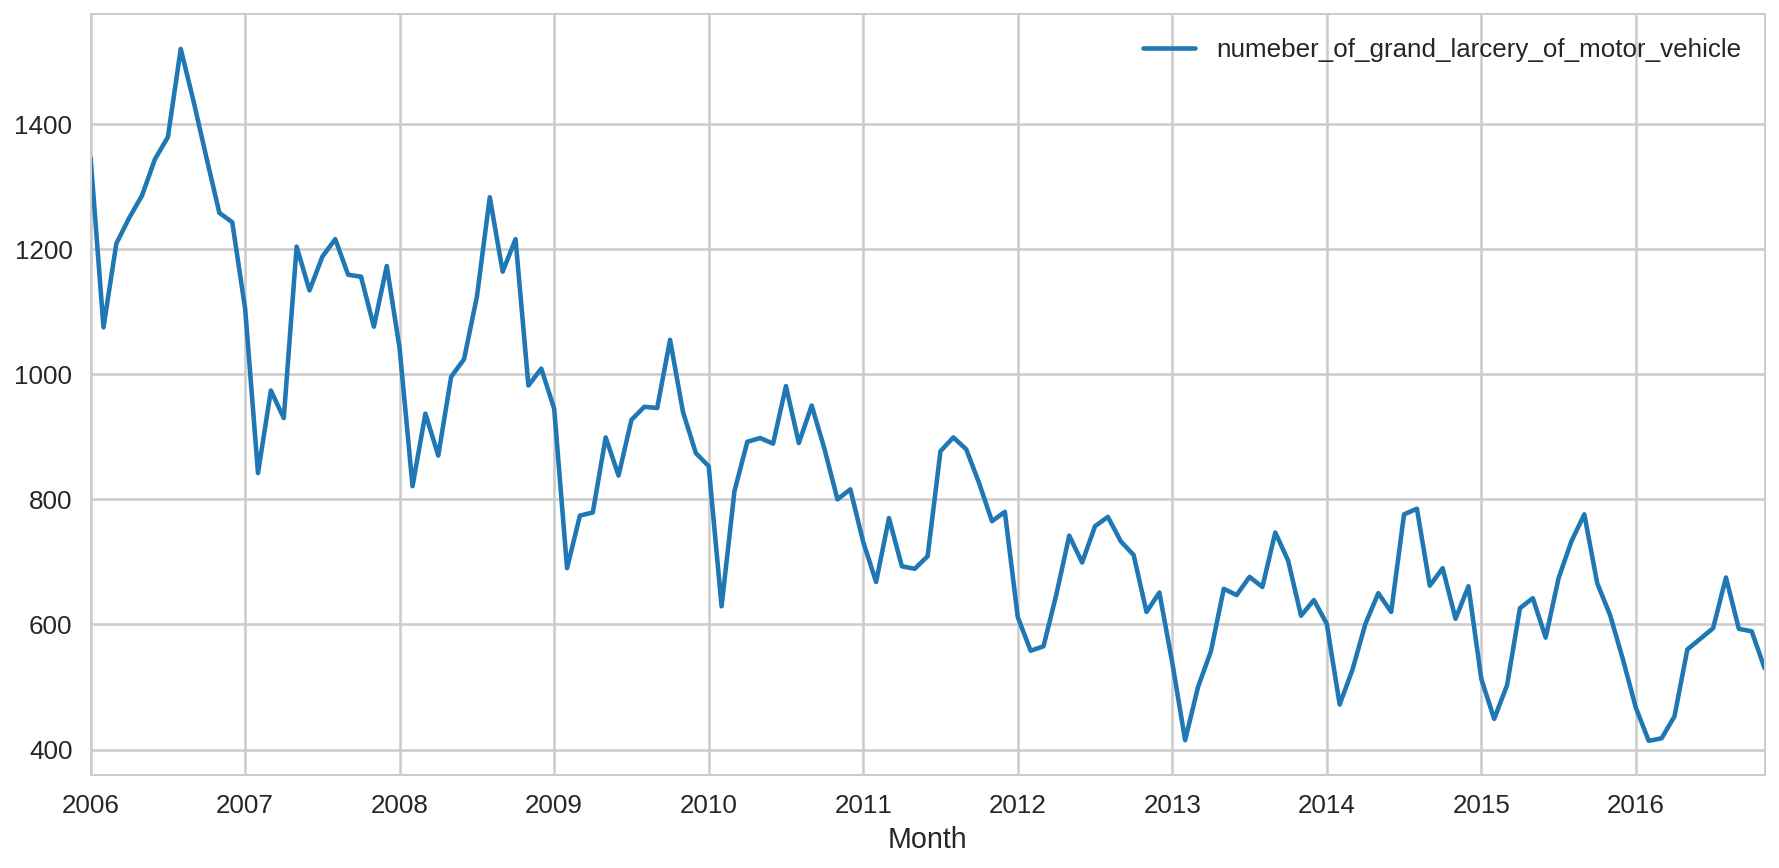

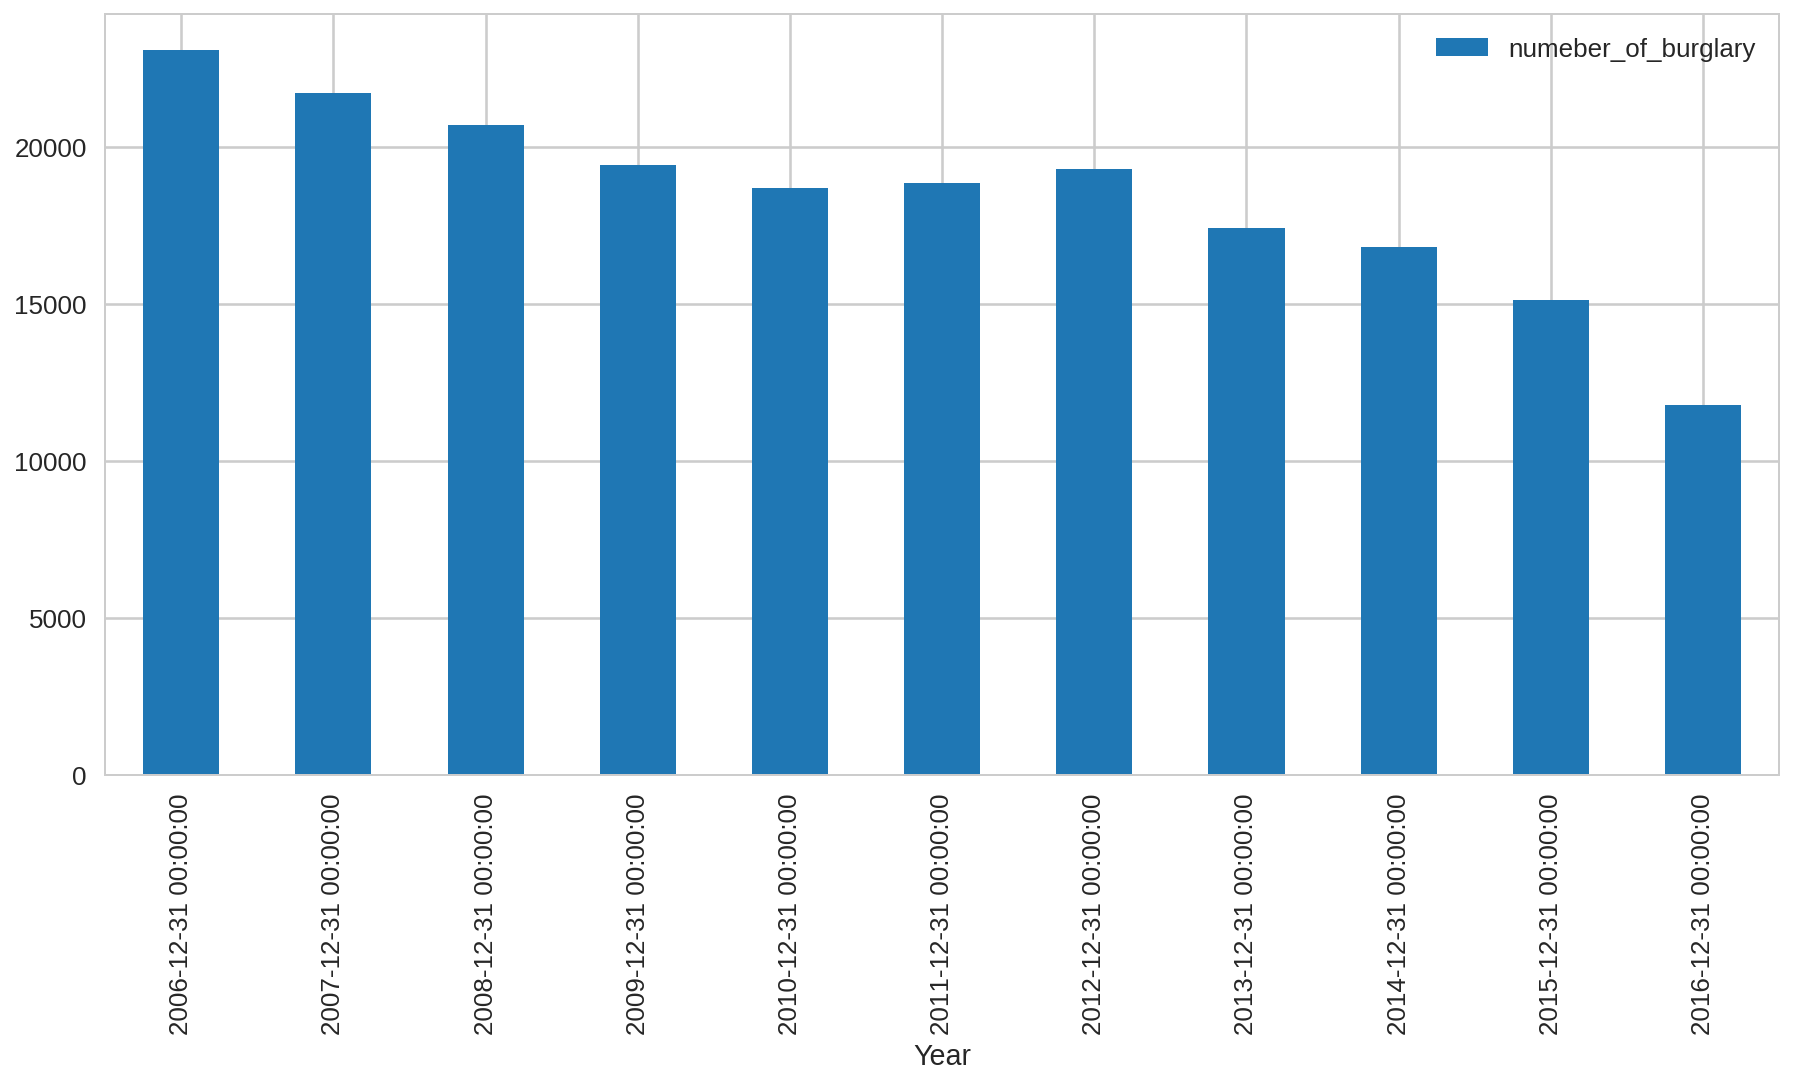

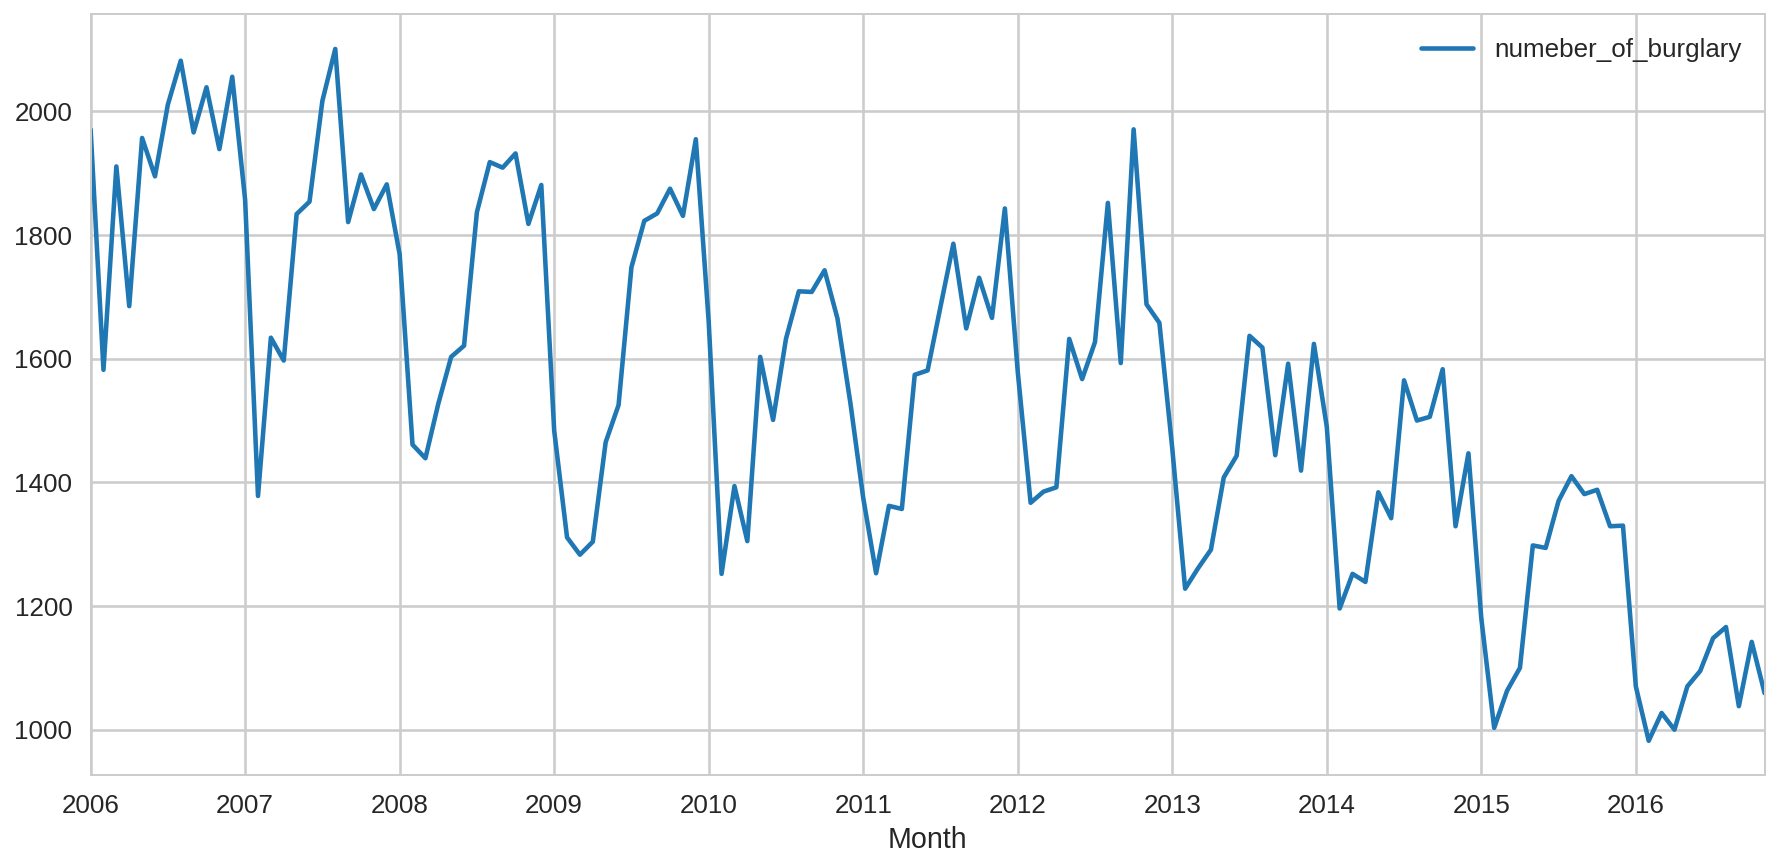

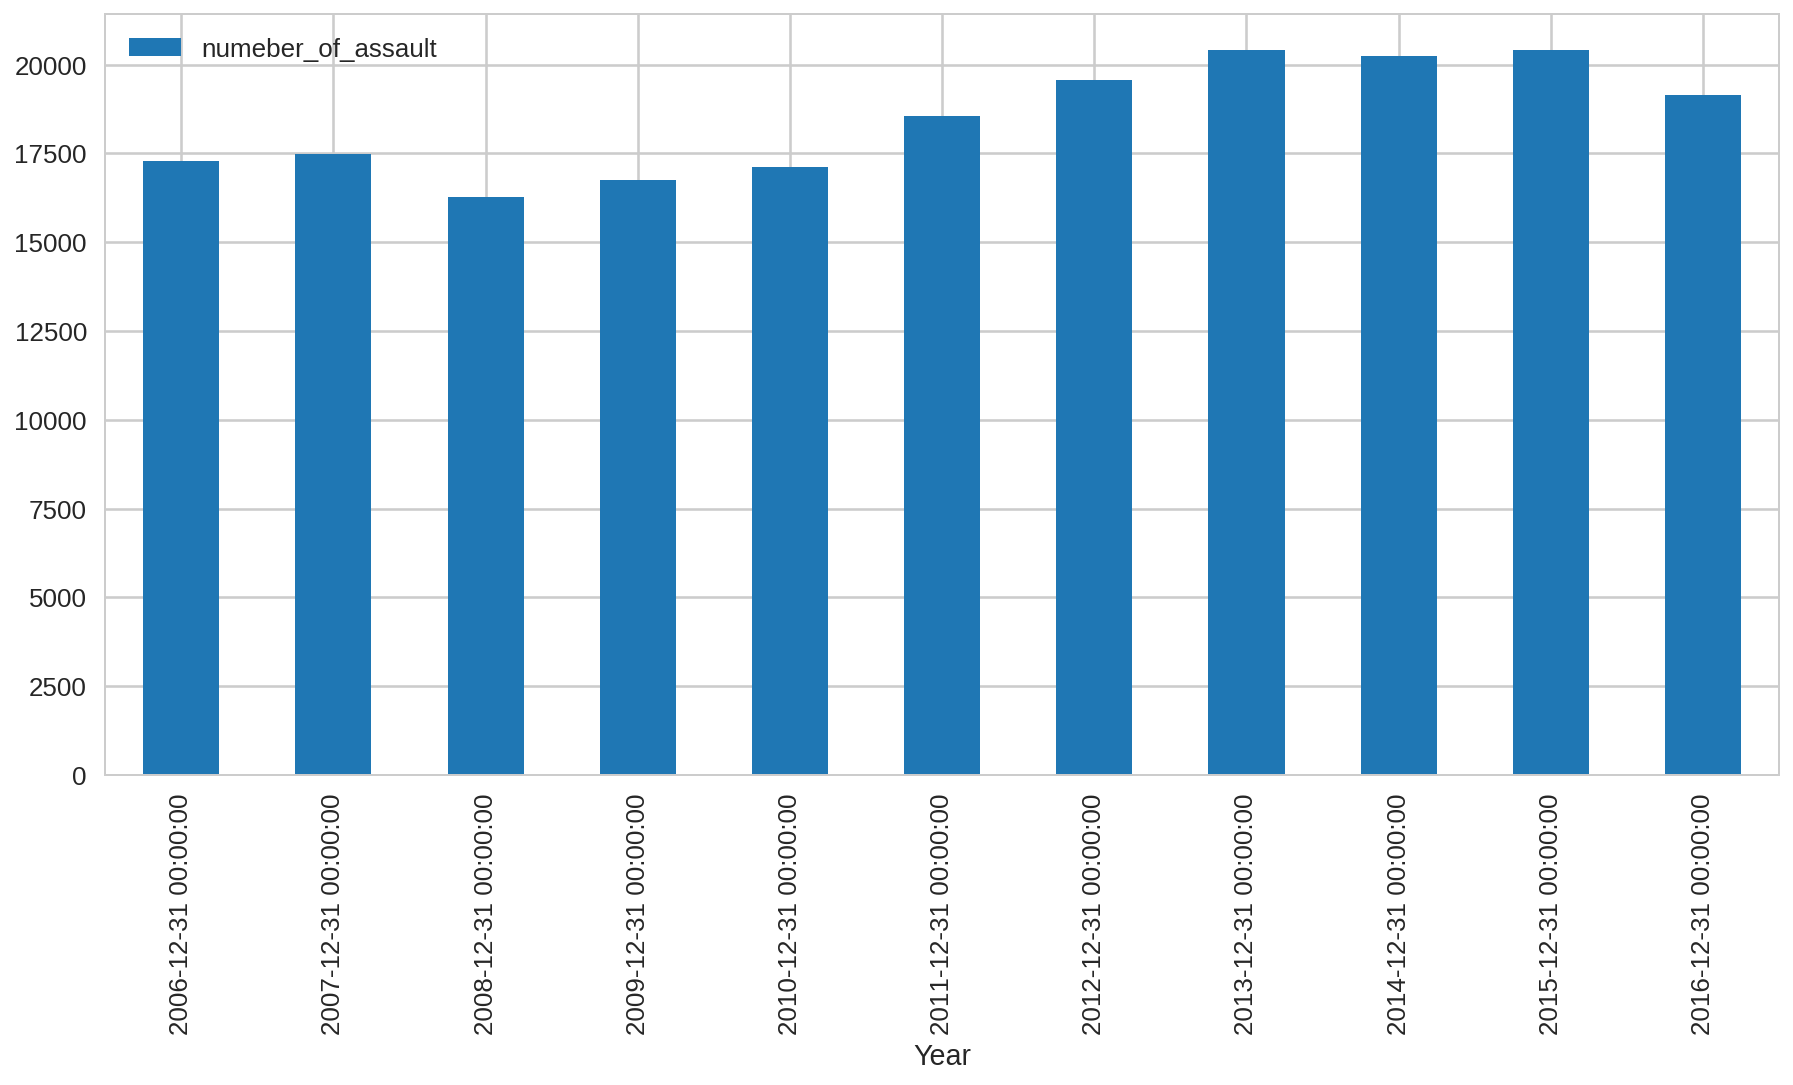

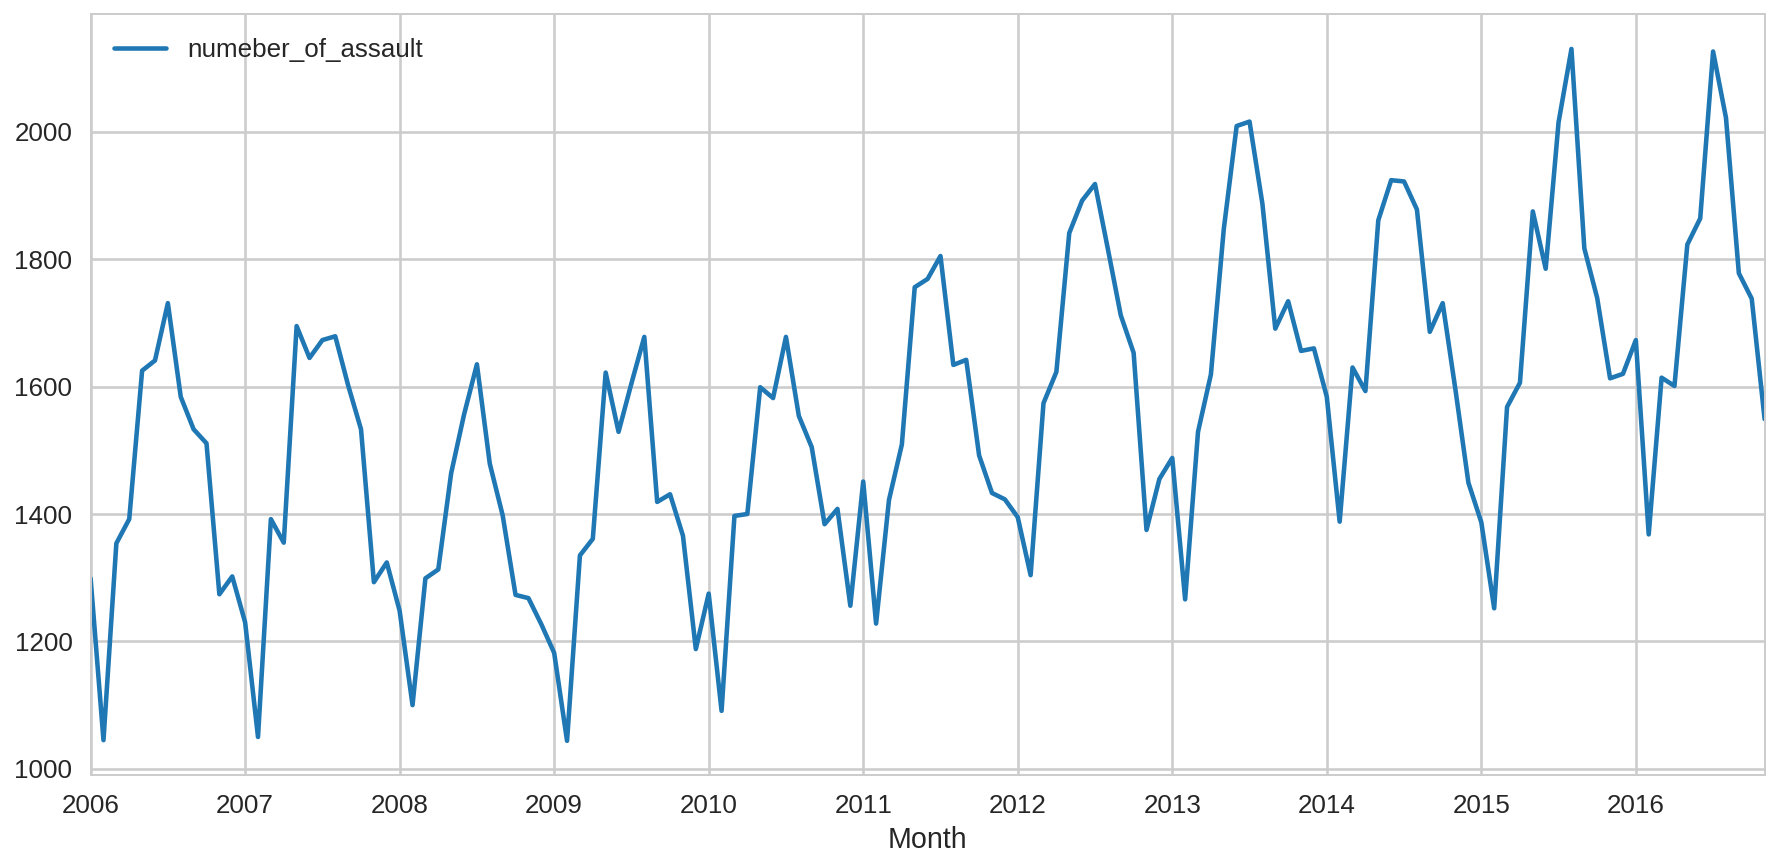

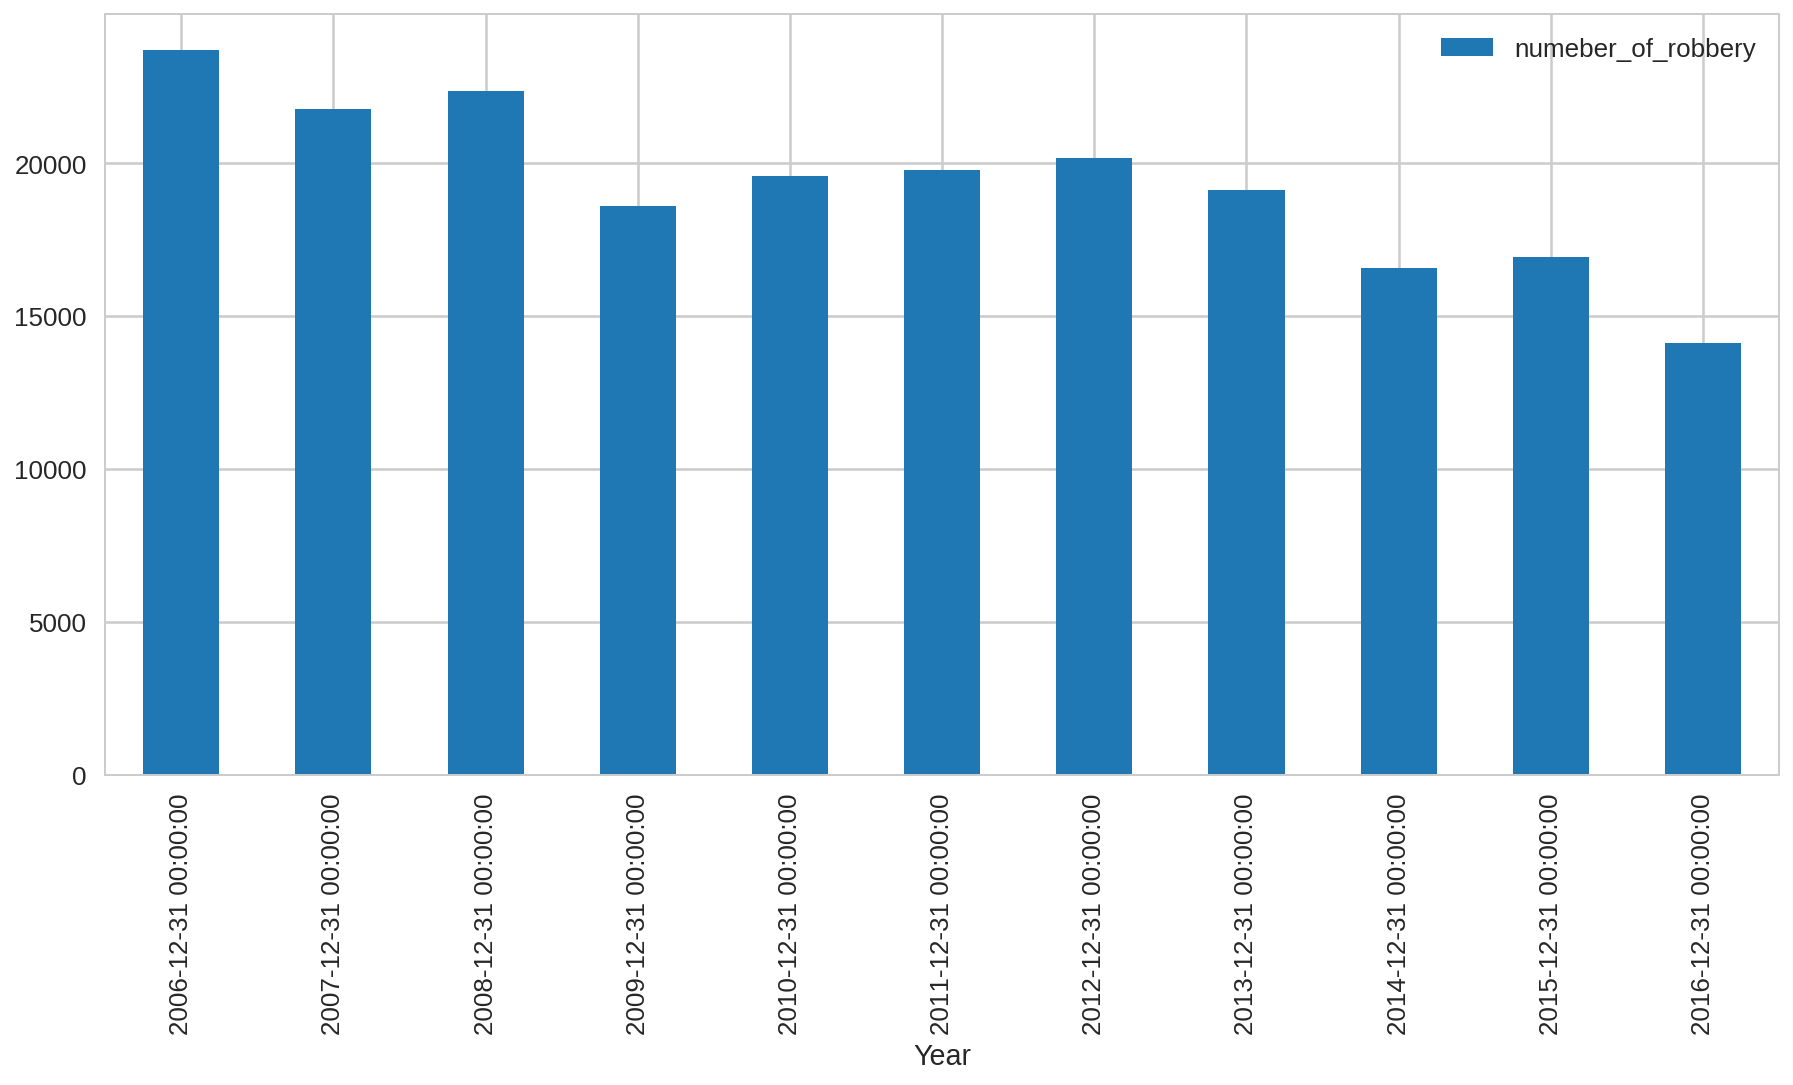

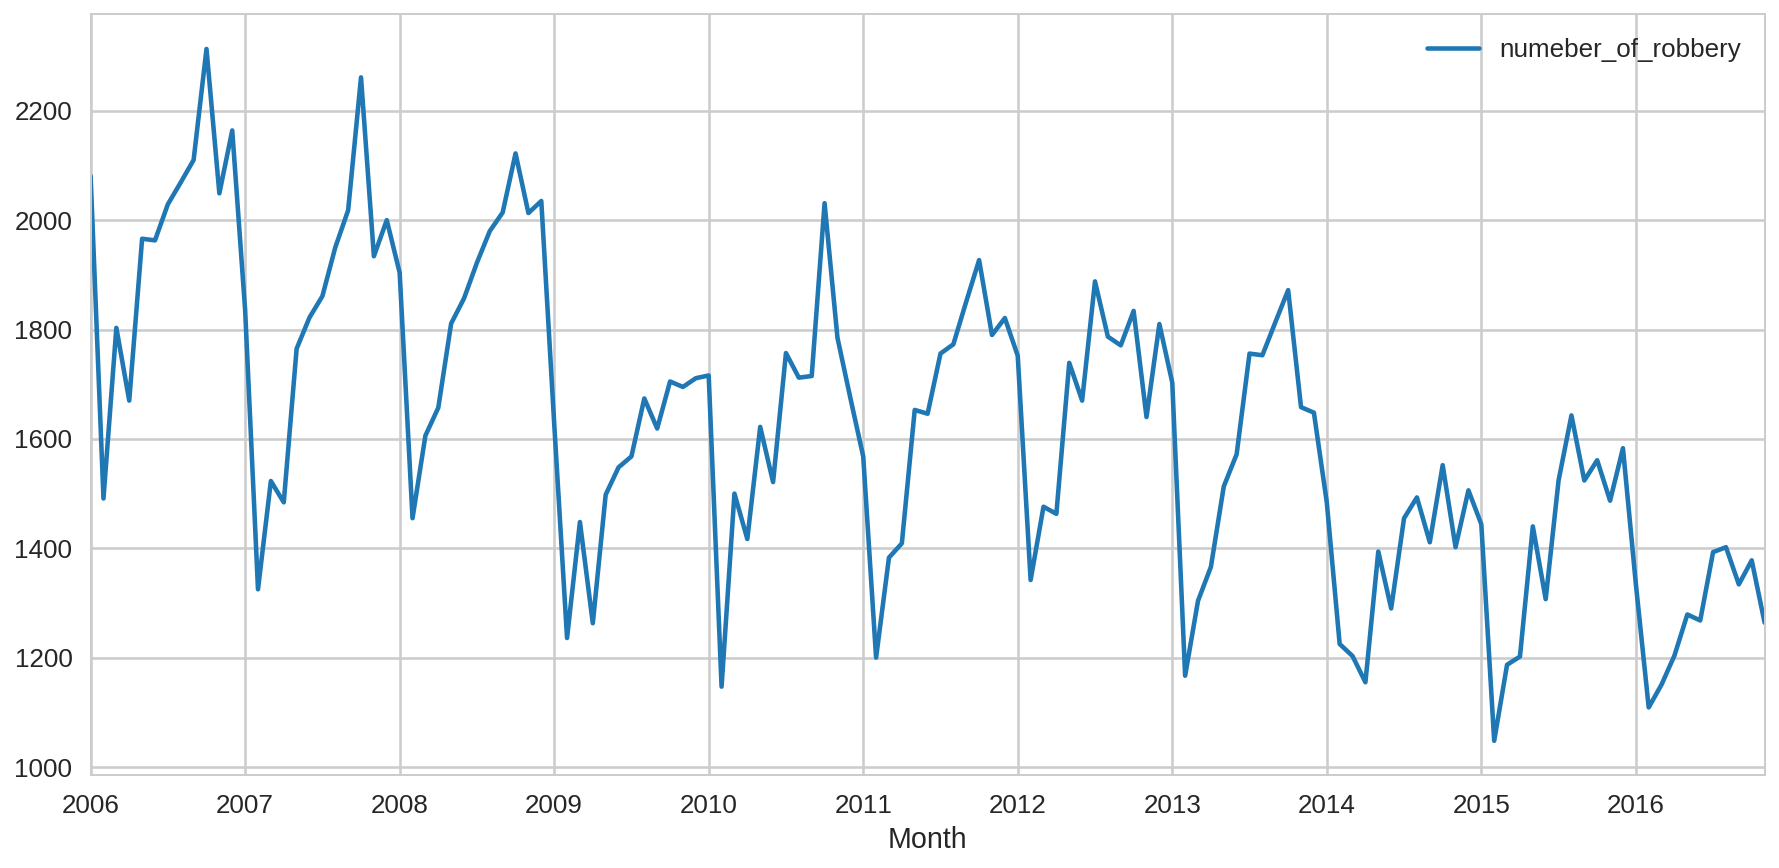

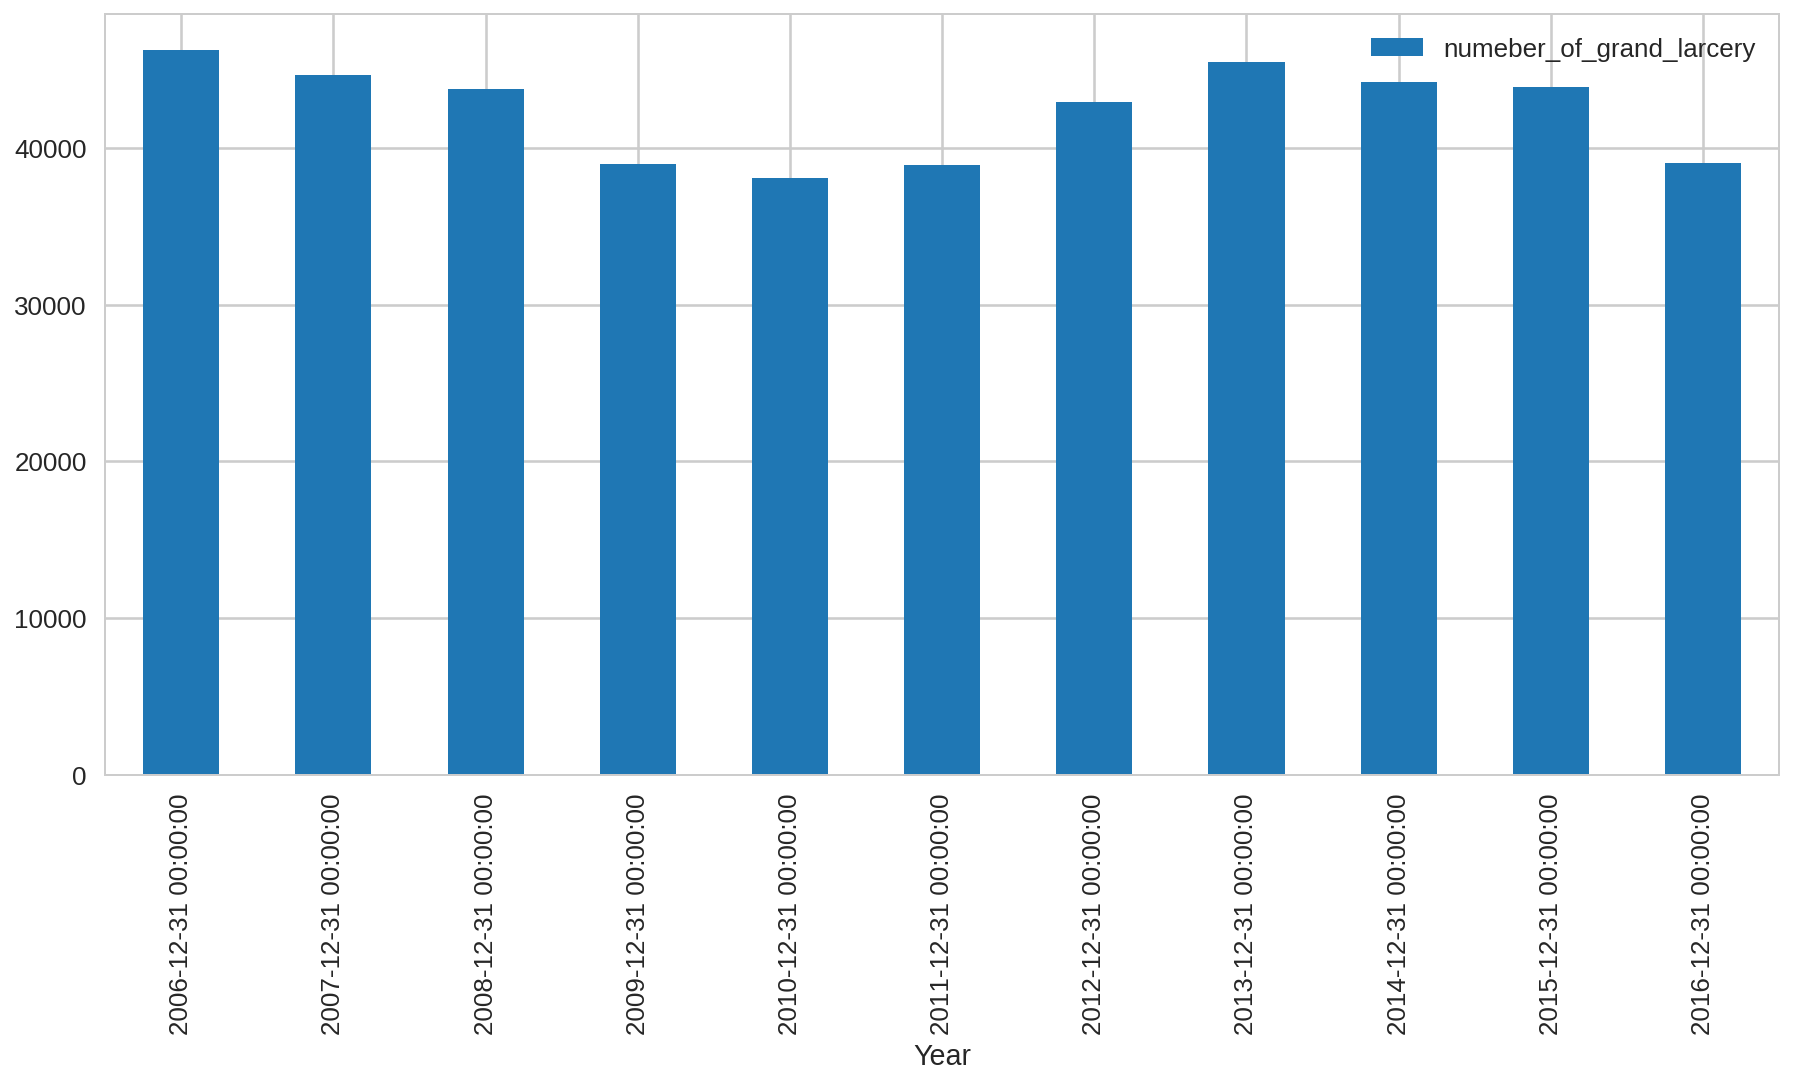

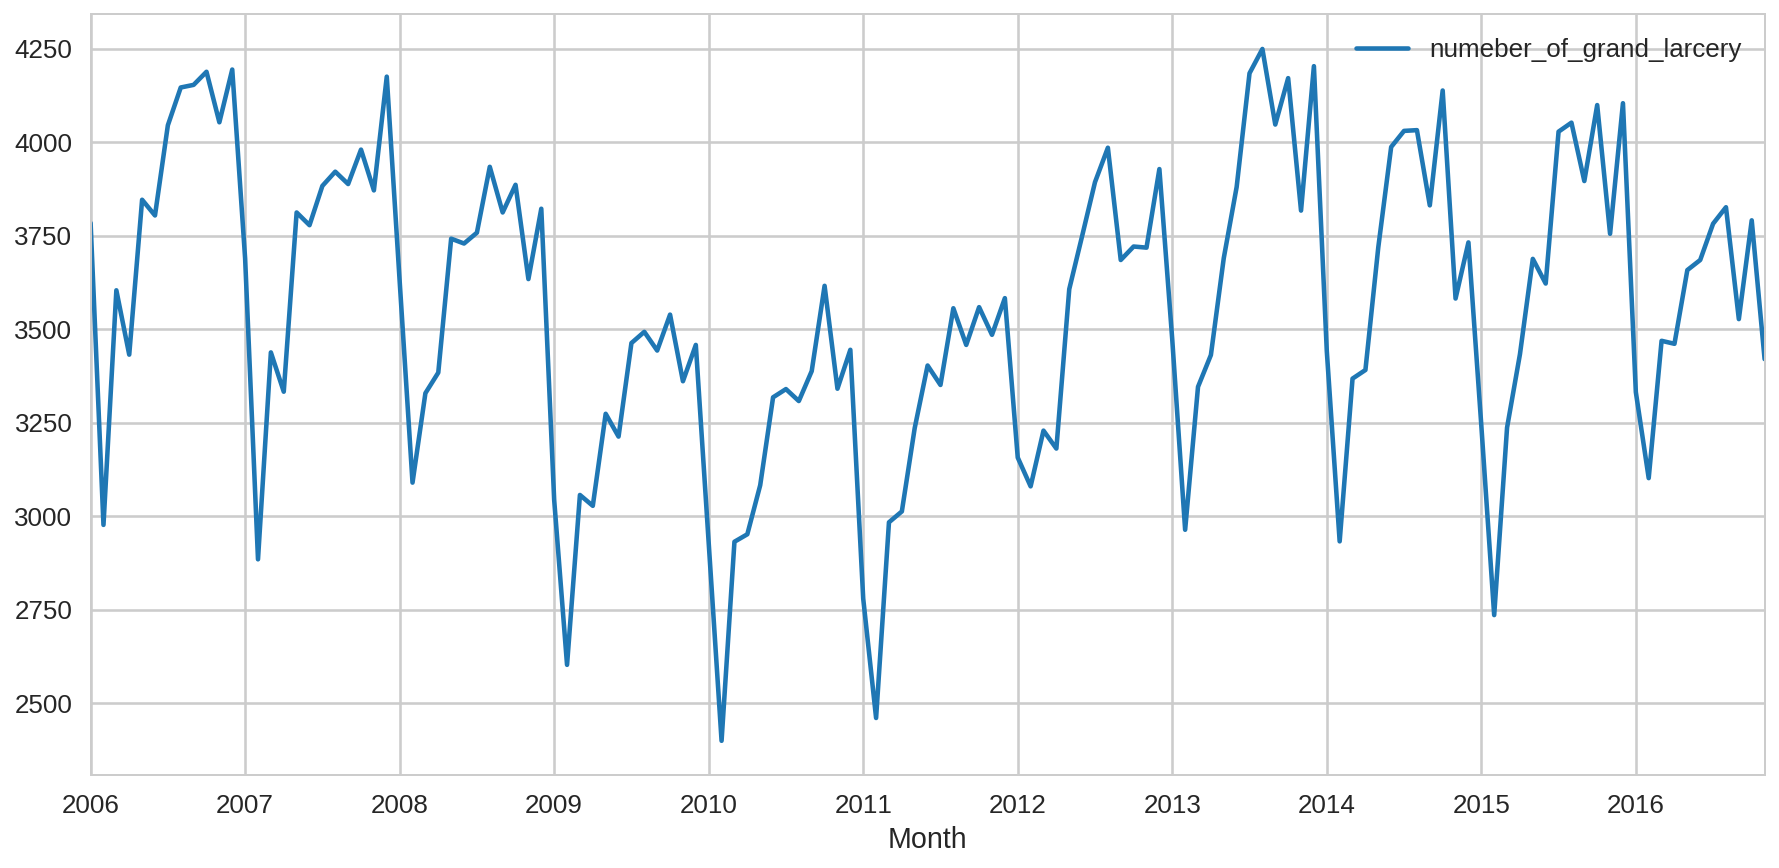

In [ ]:
big_7_time_murder_year.plot(kind='bar')
big_7_time_murder_month.plot()
big_7_time_rape_year.plot(kind='bar')
big_7_time_rape_month.plot()
big_7_time_grand_larcery_of_motor_vehicle_year.plot(kind='bar')
big_7_time_grand_larcery_of_motor_vehicle_month.plot()
big_7_time_burglary_year.plot(kind='bar')
big_7_time_burglary_month.plot()
big_7_time_assult_year.plot(kind='bar')
big_7_time_assult_month.plot()
big_7_time_robbery_year.plot(kind='bar')
big_7_time_robbery_month.plot()
big_7_time_grand_larcery_year.plot(kind='bar')
big_7_time_grand_larcery_month.plot()


## Question 4: Analyze the Big-7 felonies based on hour of the day.

You are now asked to break down the different big-7 felonies hour of day.

* **Question 4a**: Show the number of big-7 felonies, broken down by hour of day. (e.g., _6049 reported robberies at 5am_). Generate a bar plot with the results. Generate a bar plot with the results.

* **Question 4b**: Show the number of big-7 felonies, broken down by hour of day. To allow for easier comparison among felonies, **normalize** the data by dividing by the total incidents for each type of felony.  (e.g., _2.8% of the reported robberies happen at 5am_). Generate a bar plot with the results.


**Hint 1**: If you have a datetime column in your dataframe (say `df.CMPLNT_FR`), you can extract the day of the week and the hour, using the following commands. These commands will create two new columns, `DAY_OF_WEEK` and `HOUR`. The `DAY_OF_WEEK` is encoded as a *ordered* categorical variable, in order to sort properly. The `HOUR` is a numeric variable.

```python
  categs = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
  df['DAY_OF_WEEK'] = pd.Categorical(df.complaint_datetime.dt.day_name(), categories = categs, ordered=True)
  df['HOUR'] = df.complaint_datetime.dt.hour
```

Alternatively, you can use the commands `HOUR()` and `DAYOFWEEK()` in SQL, to extract these values.

**Hint 2**: When creating plots, you may prefer to put the plot for each columns of the dataframe in a separate plot. The option `subplots=True` for the `df.plot()` command provides that capability. (See [the related documentation](https://pandas.pydata.org/pandas-docs/stable/visualization.html#subplots).) If you use the `subplots=True`, you can also use the `layout=(num_rows, num_columns)` option to specify the number of rows (`num_rows`) and the number of columns (`num_columns`) to use for the grid arrangement.

**Hint 3**: The normalizing data and when generating plots, you may find the `.T` command very handy (shorthand for `.transpose()`). The `.T` command returns the transpose of the dataframe, i.e., returns a dataframe where the columns become rows and vice versa.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7ff8dbf909b0>,
      dtype=object)

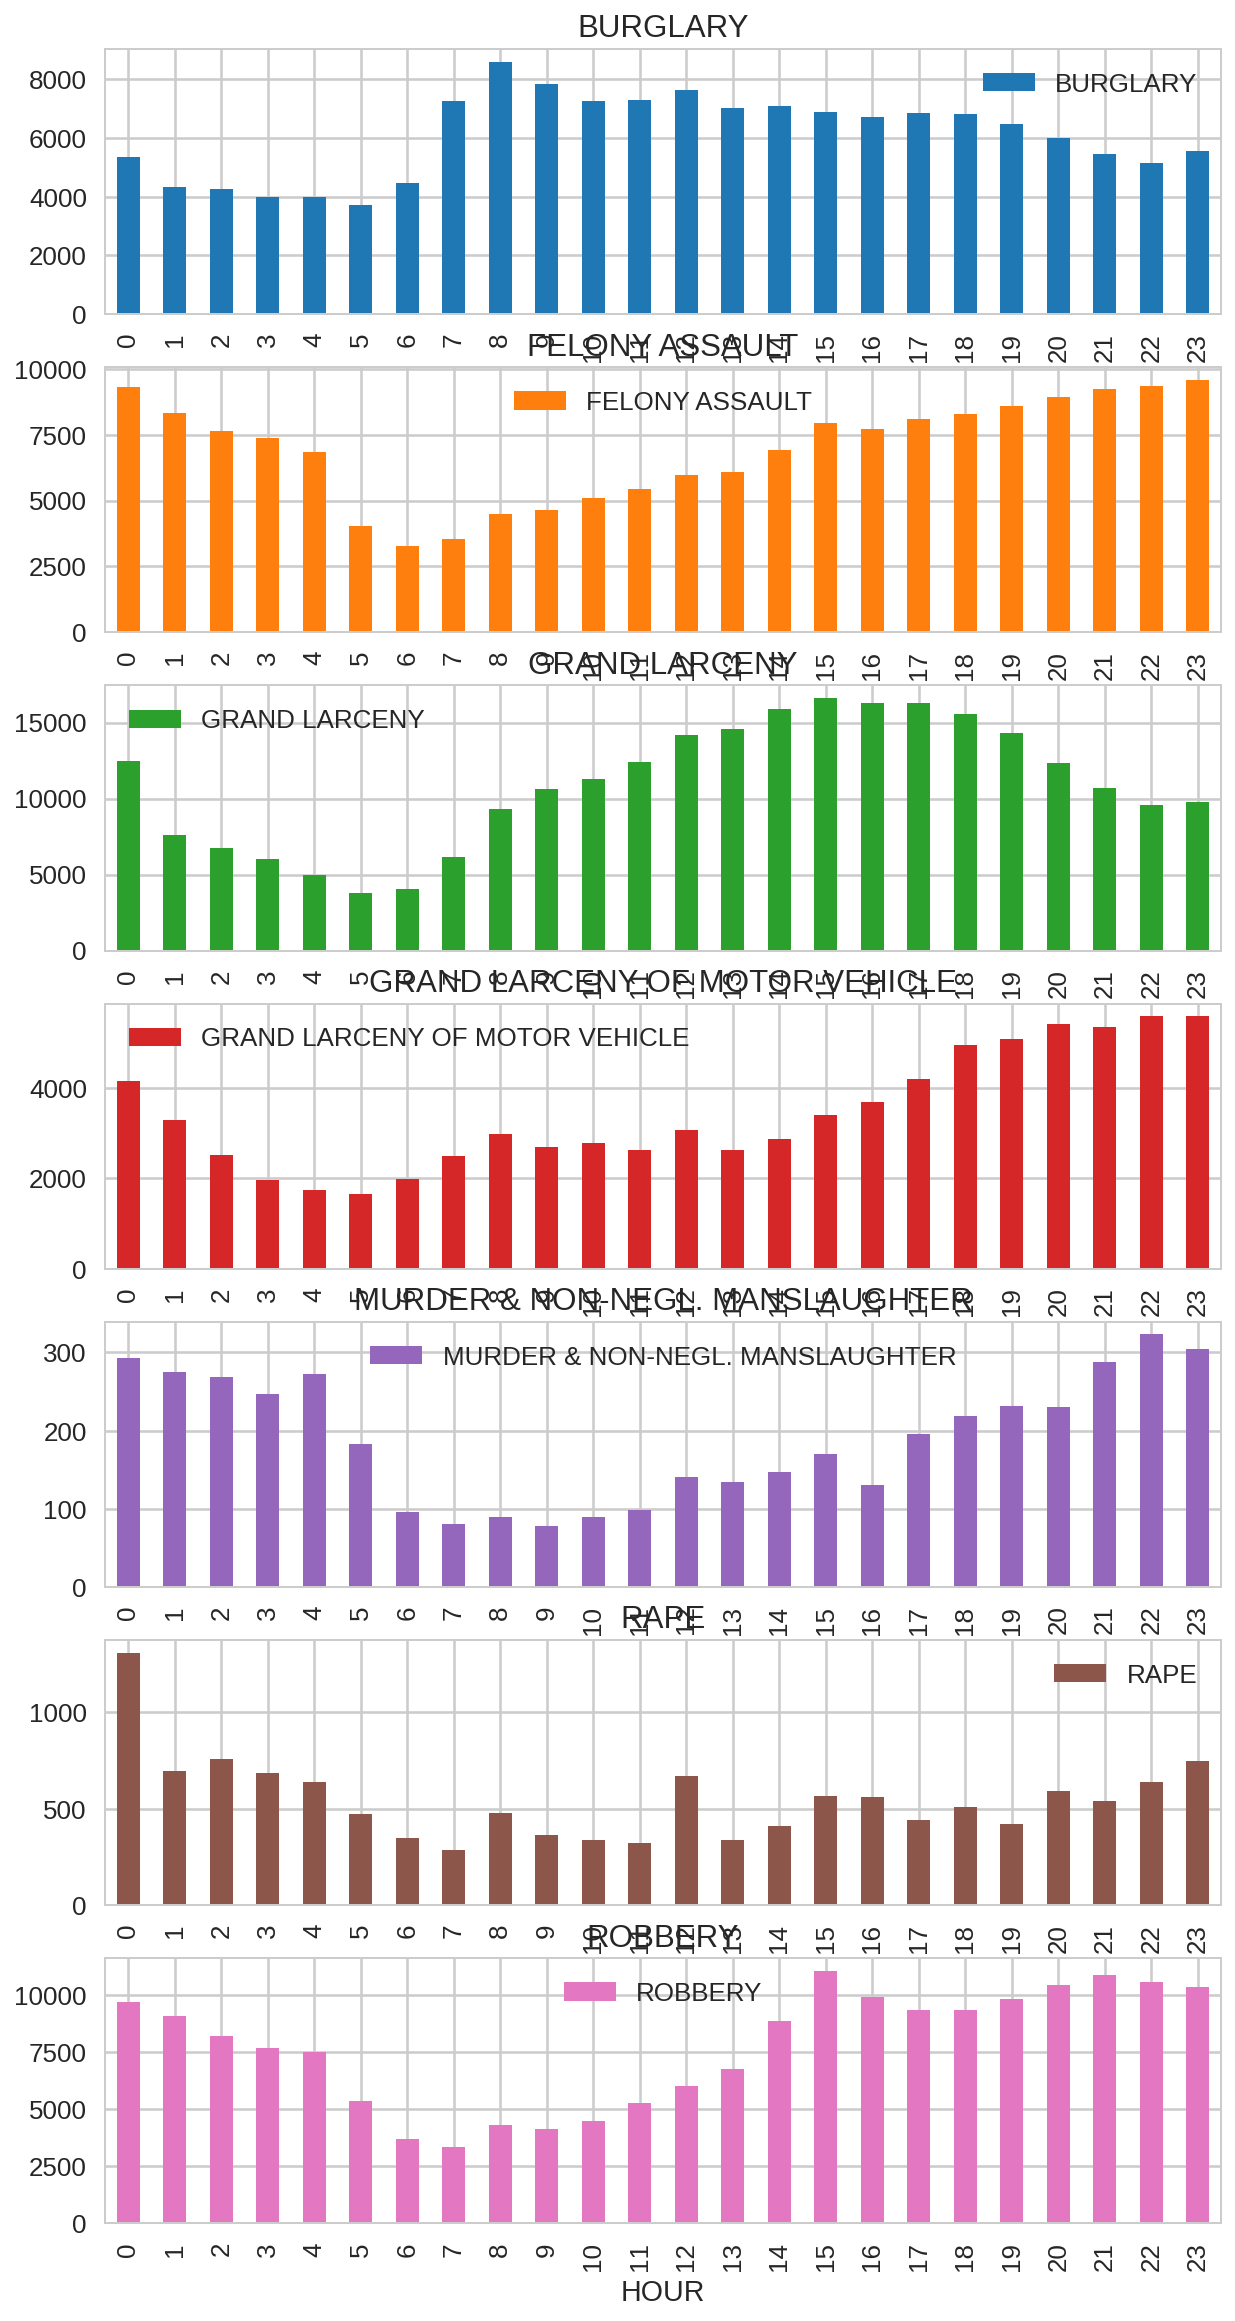

In [ ]:
#4a

query = '''

SELECT OFNS_DESC as type_of_complaint, COUNT(DISTINCT OFNS_DESC) as complaints_by_type, CMPLNT_FR as time
FROM nypd
WHERE CMPLNT_FR BETWEEN '2006-01-01' AND '2016-11-31'
AND LAW_CAT_CD = 'FELONY'
AND OFNS_DESC IN ('GRAND LARCENY','ROBBERY','FELONY ASSAULT','BURGLARY','GRAND LARCENY OF MOTOR VEHICLE','RAPE','MURDER & NON-NEGL. MANSLAUGHTER')
GROUP BY CMPLNT_FR, OFNS_DESC;

'''

big_7 = pd.read_sql(query, con=engine)
big_7['HOUR'] = big_7.time.dt.hour

big_7_pivot = pd.pivot_table(
    data = big_7,
    index = 'HOUR',
    columns='type_of_complaint',
    values='complaints_by_type',
    aggfunc='sum'
)

big_7_pivot

big_7_pivot.plot(figsize = (10,20), kind='bar', subplots=True, sharex=False)





array([<matplotlib.axes._subplots.AxesSubplot object at 0x7ff8dc3eb400>,
      dtype=object)

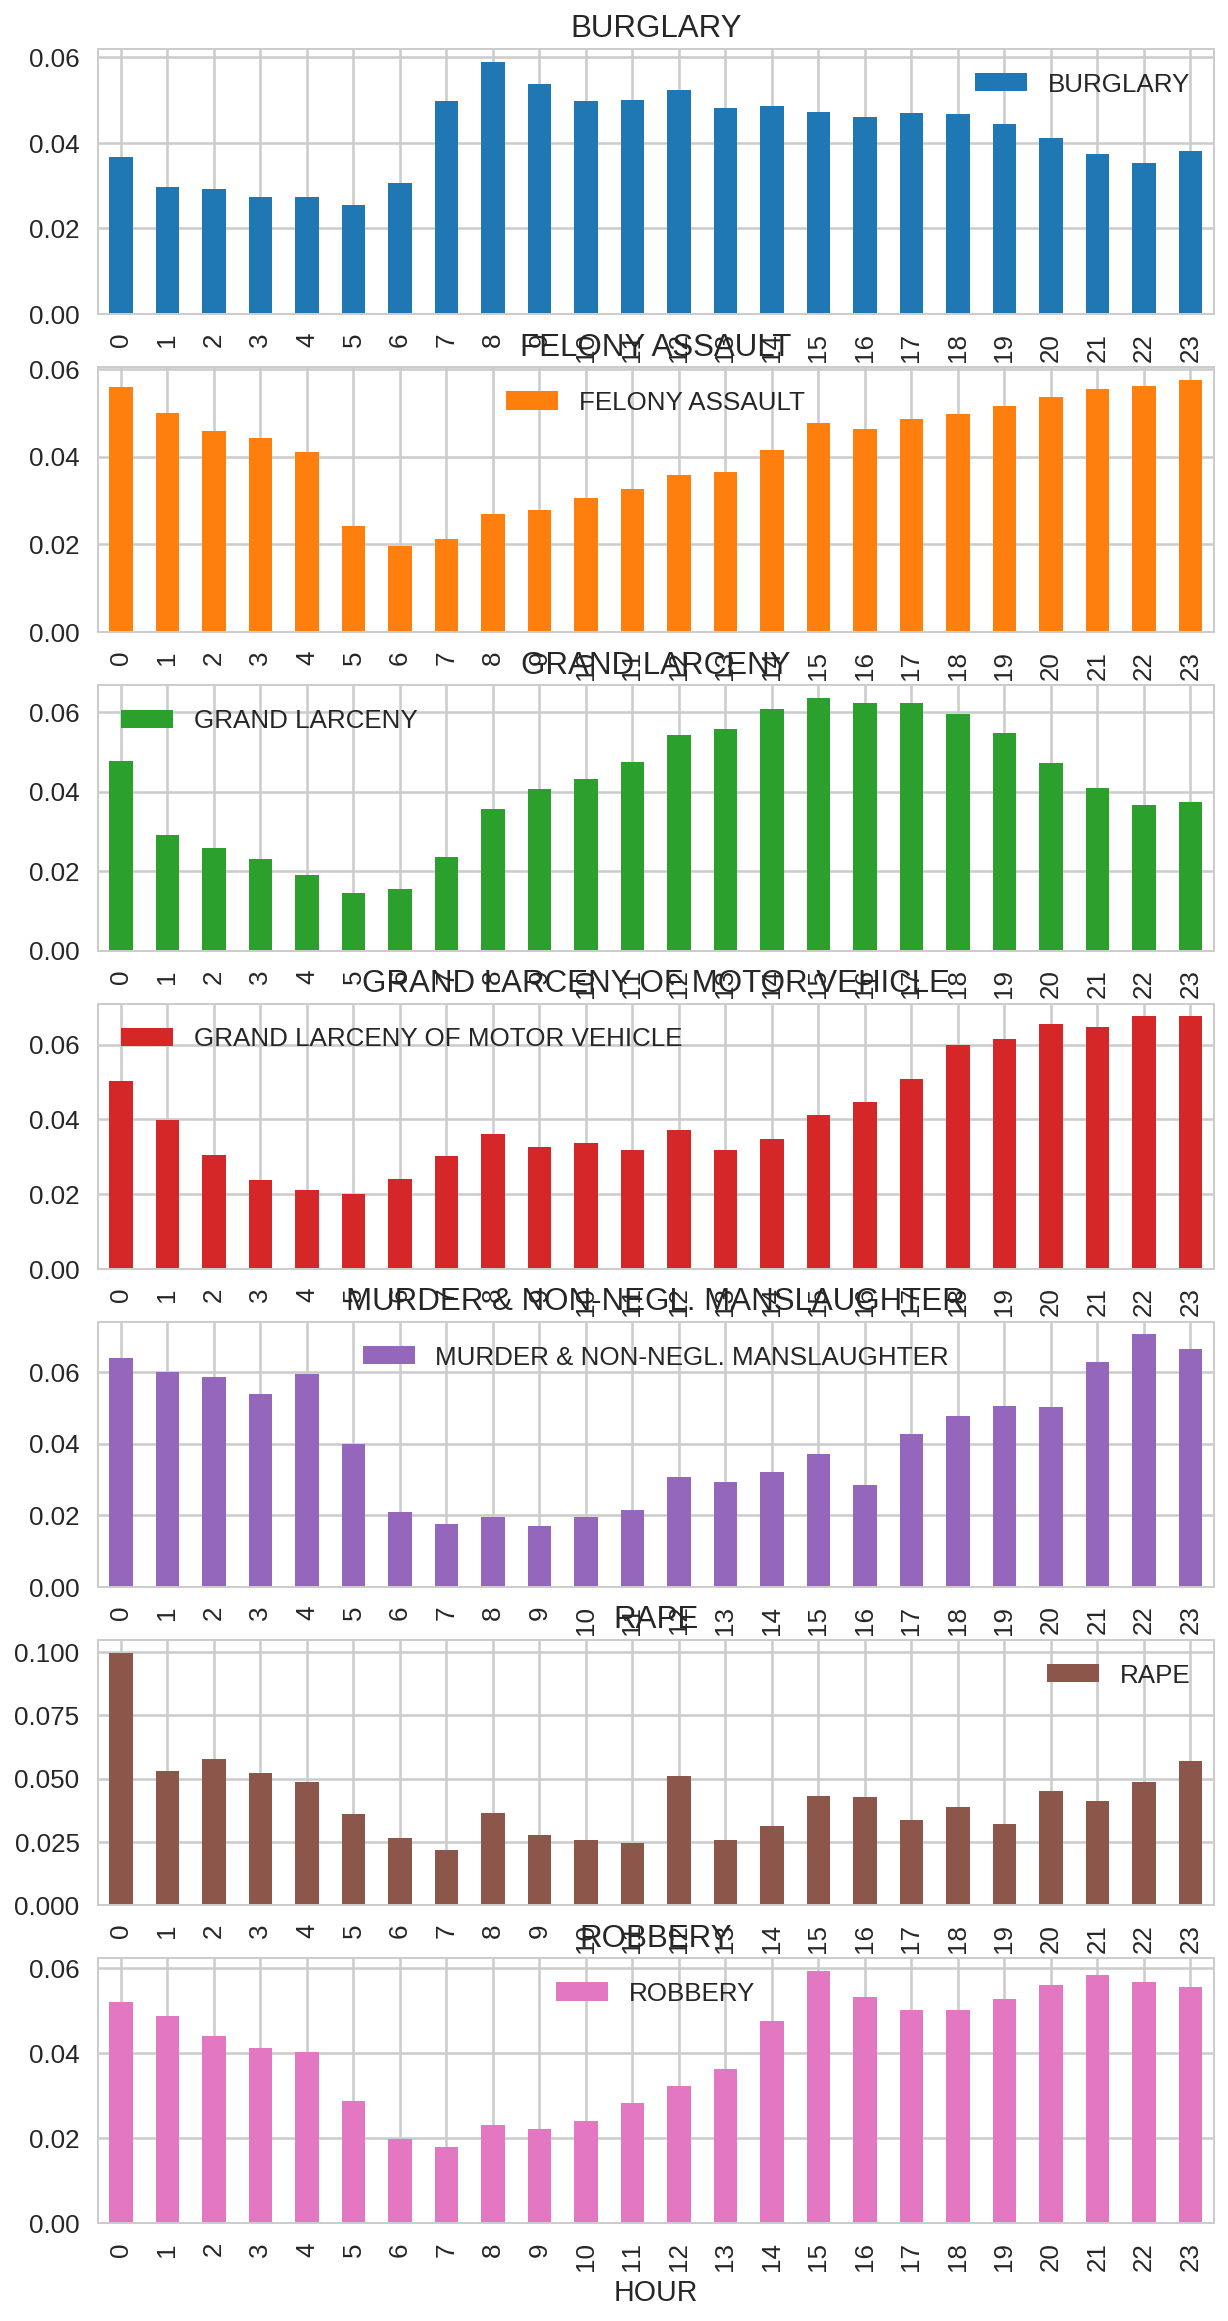

In [ ]:
# 4b
query = '''

SELECT OFNS_DESC as type_of_complaint, COUNT(DISTINCT OFNS_DESC) as complaints_by_type, CMPLNT_FR as time
FROM nypd
WHERE CMPLNT_FR BETWEEN '2006-01-01' AND '2016-11-31'
AND LAW_CAT_CD = 'FELONY'
AND OFNS_DESC IN ('GRAND LARCENY','ROBBERY','FELONY ASSAULT','BURGLARY','GRAND LARCENY OF MOTOR VEHICLE','RAPE','MURDER & NON-NEGL. MANSLAUGHTER')
GROUP BY CMPLNT_FR, OFNS_DESC;

'''

big_7 = pd.read_sql(query, con=engine)
big_7['HOUR'] = big_7.time.dt.hour

big_7_pivot = pd.pivot_table(
    data = big_7,
    index = 'HOUR',
    columns='type_of_complaint',
    values='complaints_by_type',
    aggfunc='sum'
)


big_7_pivot_norm = big_7_pivot/big_7_pivot.sum()
big_7_pivot_norm.plot(figsize = (10,20), kind='bar', subplots=True, sharex=False)

## Question 5: Spatial Analysis

You are asked to analyze the spatial density for the following types of felonies:
* GRAND LARCENY
* GRAND LARCENY OF MOTOR VEHICLE
* FELONY ASSAULT
* MURDER & NON-NEGL. MANSLAUGHTER

Use the `Latitude` and `Longitude` variables from the dataset to identify the location of each crime. (FYI, for victim privacy, the reported rapes do not have geocoding variables associated with them.) Limit your analysis to Manhattan only (see the `BORO_NM` attribute), felonies, and to dates between 2006 and 2016 (inclusive on both ends).

**Hint 1**: Remember that if you do a 2d density estimation, you can speed up the computation by taking just a sample of the data that you analyze using the `dataframe.sample()` command.

**Hint 2**: If you could like to plot a map of Manhttan under your density plot, you can use the shapefile of NYC neighborhoods from NYC Open Data, and keep only Manhattan neighborhoods. See the code below.

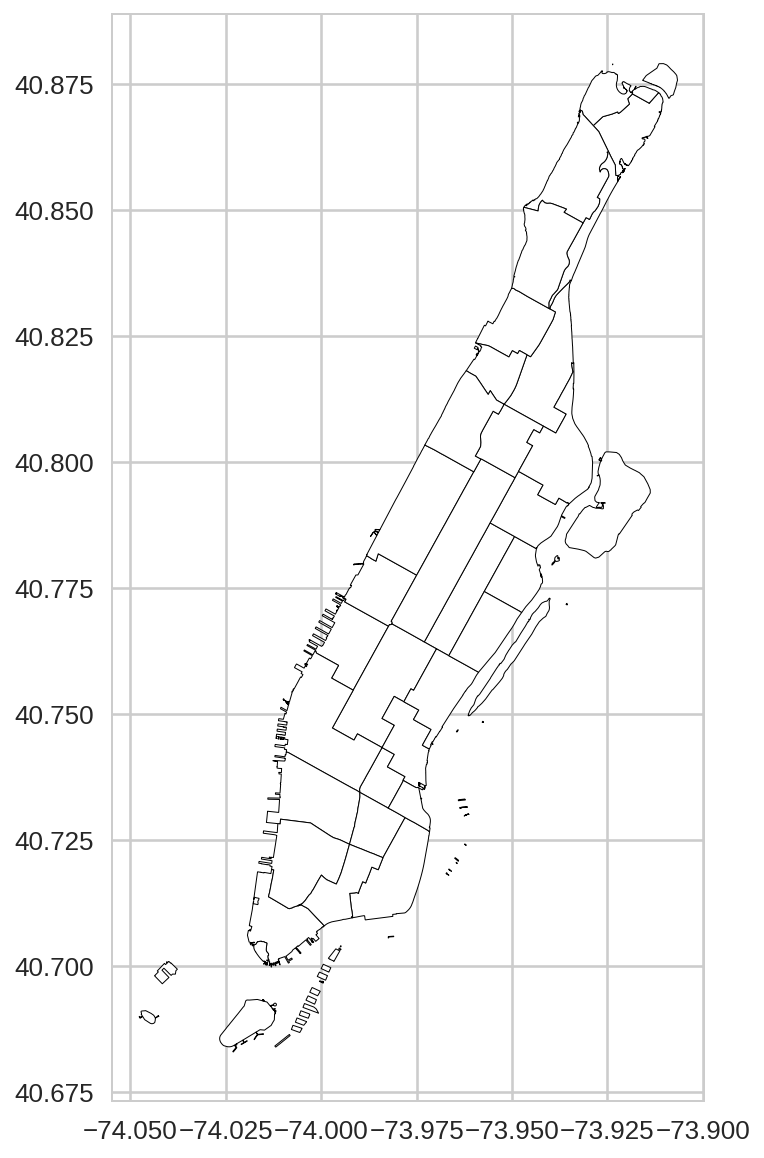

In [ ]:
# Dataset from NYC Open Data: https://data.cityofnewyork.us/City-Government/Neighborhood-Tabulation-Areas/cpf4-rkhq
shapefile = 'https://data.cityofnewyork.us/api/geospatial/cpf4-rkhq?method=export&format=GeoJSON'
# Load the shapefile
df_nyc = gpd.GeoDataFrame.from_file(shapefile)
# Limit the data to only Manhattan neighborhoods
df_manhattan = df_nyc.query( "boro_name =='Manhattan' ")
# Create a plot
manhattan_plot = df_manhattan.plot(linewidth=0.5, color='White', edgecolor='Black', figsize=(15, 10))

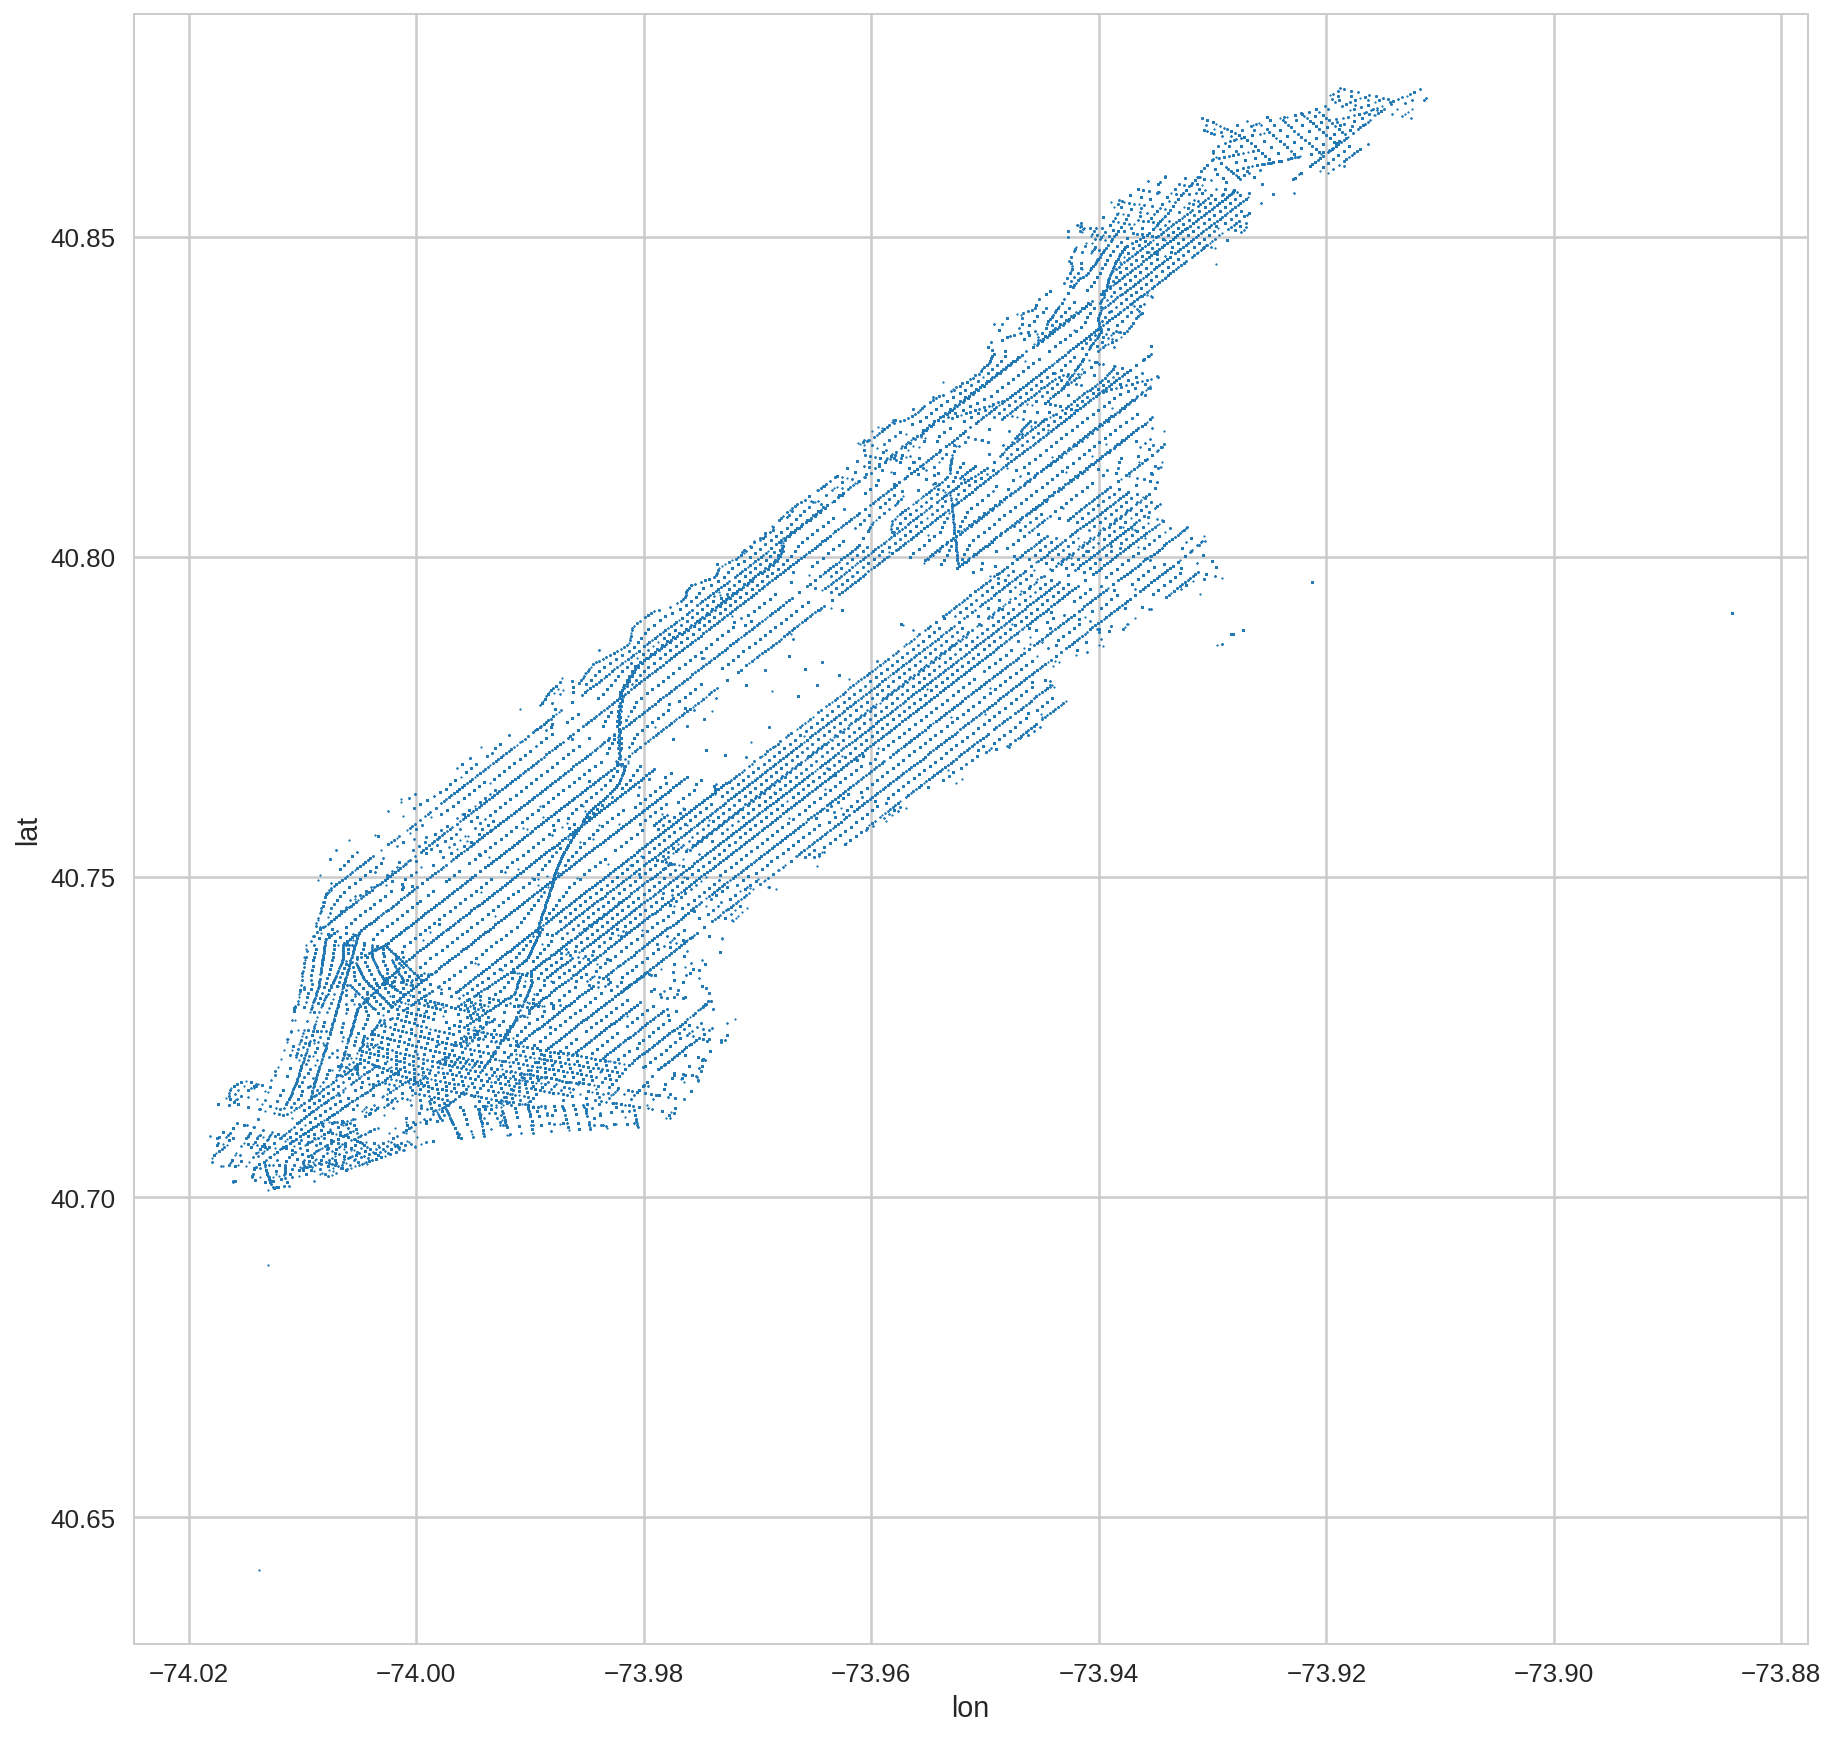

In [ ]:
query = '''
SELECT CMPLNT_NUM as complaint, Latitude as lat, Longitude as lon
FROM nypd
WHERE CMPLNT_FR BETWEEN '2006-01-01' AND '2016-11-31'
AND LAW_CAT_CD = 'FELONY'
AND OFNS_DESC IN ('GRAND LARCENY','FELONY ASSAULT','GRAND LARCENY OF MOTOR VEHICLE','MURDER & NON-NEGL. MANSLAUGHTER')
AND BORO_NM = 'MANHATTAN';
'''
complaints = pd.read_sql(query, con=engine)
complaints.plot(kind='scatter', x='lon', y='lat', figsize = (15, 15), s=0.5)

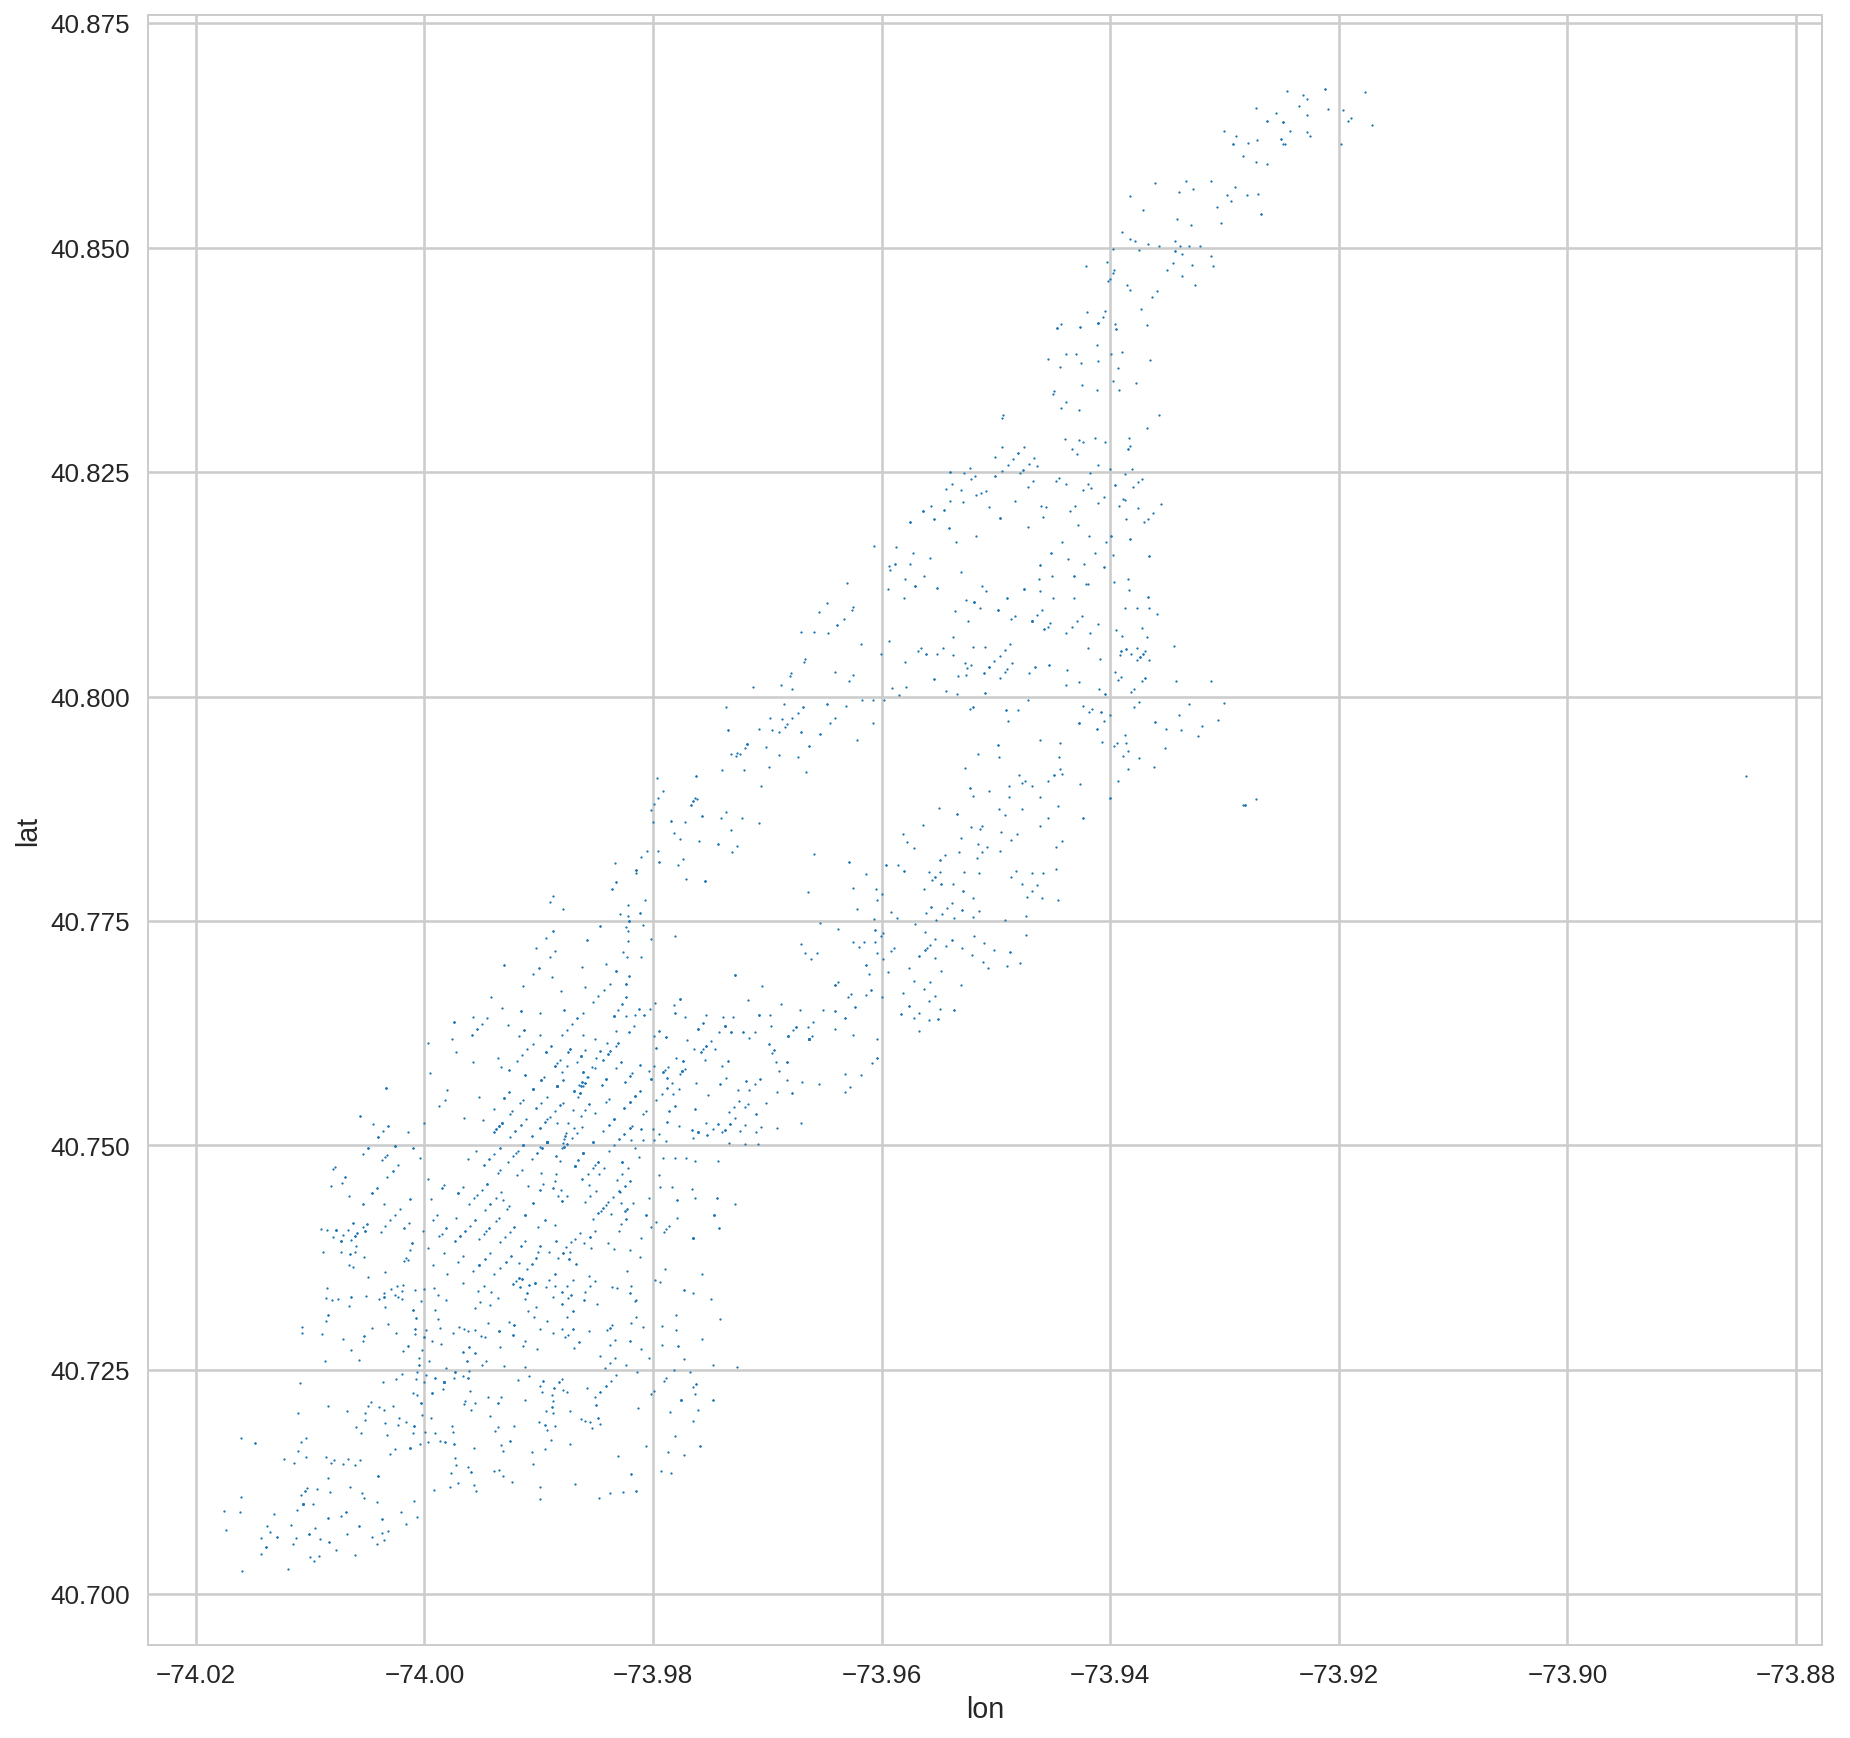

In [ ]:
sample = complaints.sample(frac=0.01)

sample.plot(kind='scatter', x='lon', y='lat', figsize=(15, 15), s=0.5)

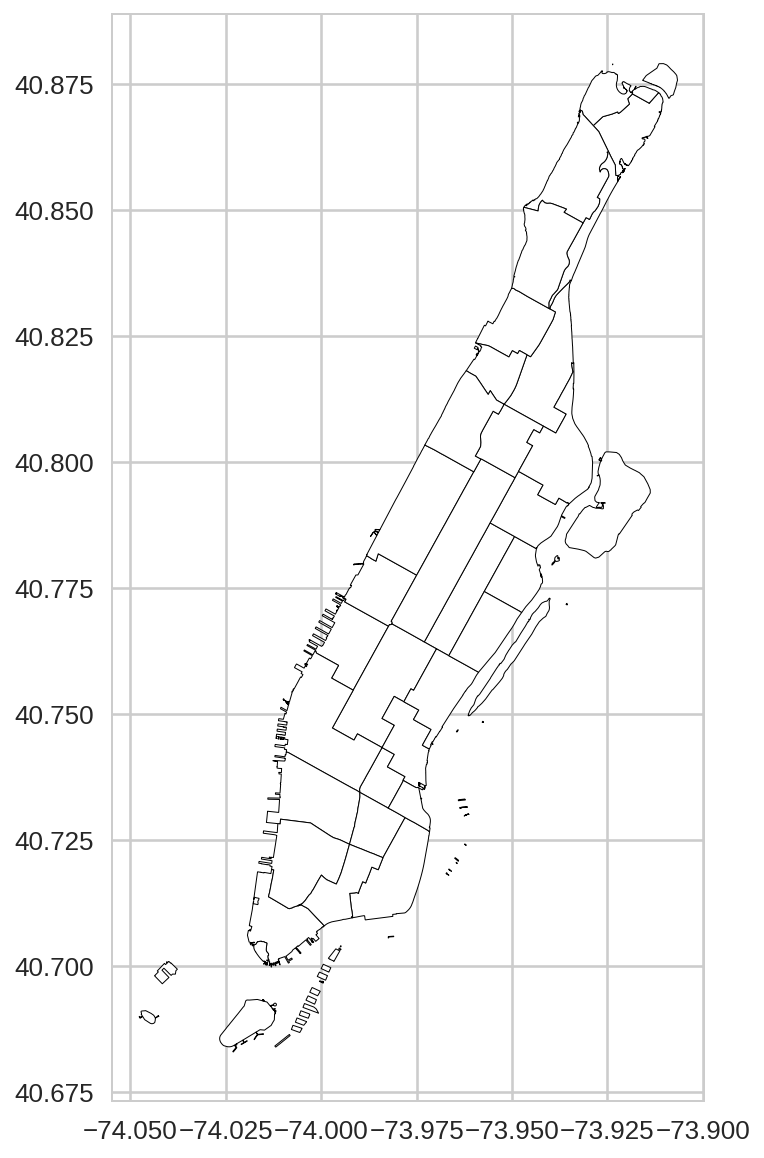

In [ ]:
# If you want to plot on top of the Manhattan,
# you need to recreate the Manhattan plot in each cell
manhattan_plot = df_manhattan.plot(linewidth=0.5, color='White', edgecolor='Black', figsize=(15, 10))


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:1678: UserWarning: `shade_lowest` is now deprecated in favor of `thresh`. Setting `thresh=0.05`, but please update your code.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:1184: UserWarning: The following kwargs were not used by contour: 'figsize'
  **contour_kws,


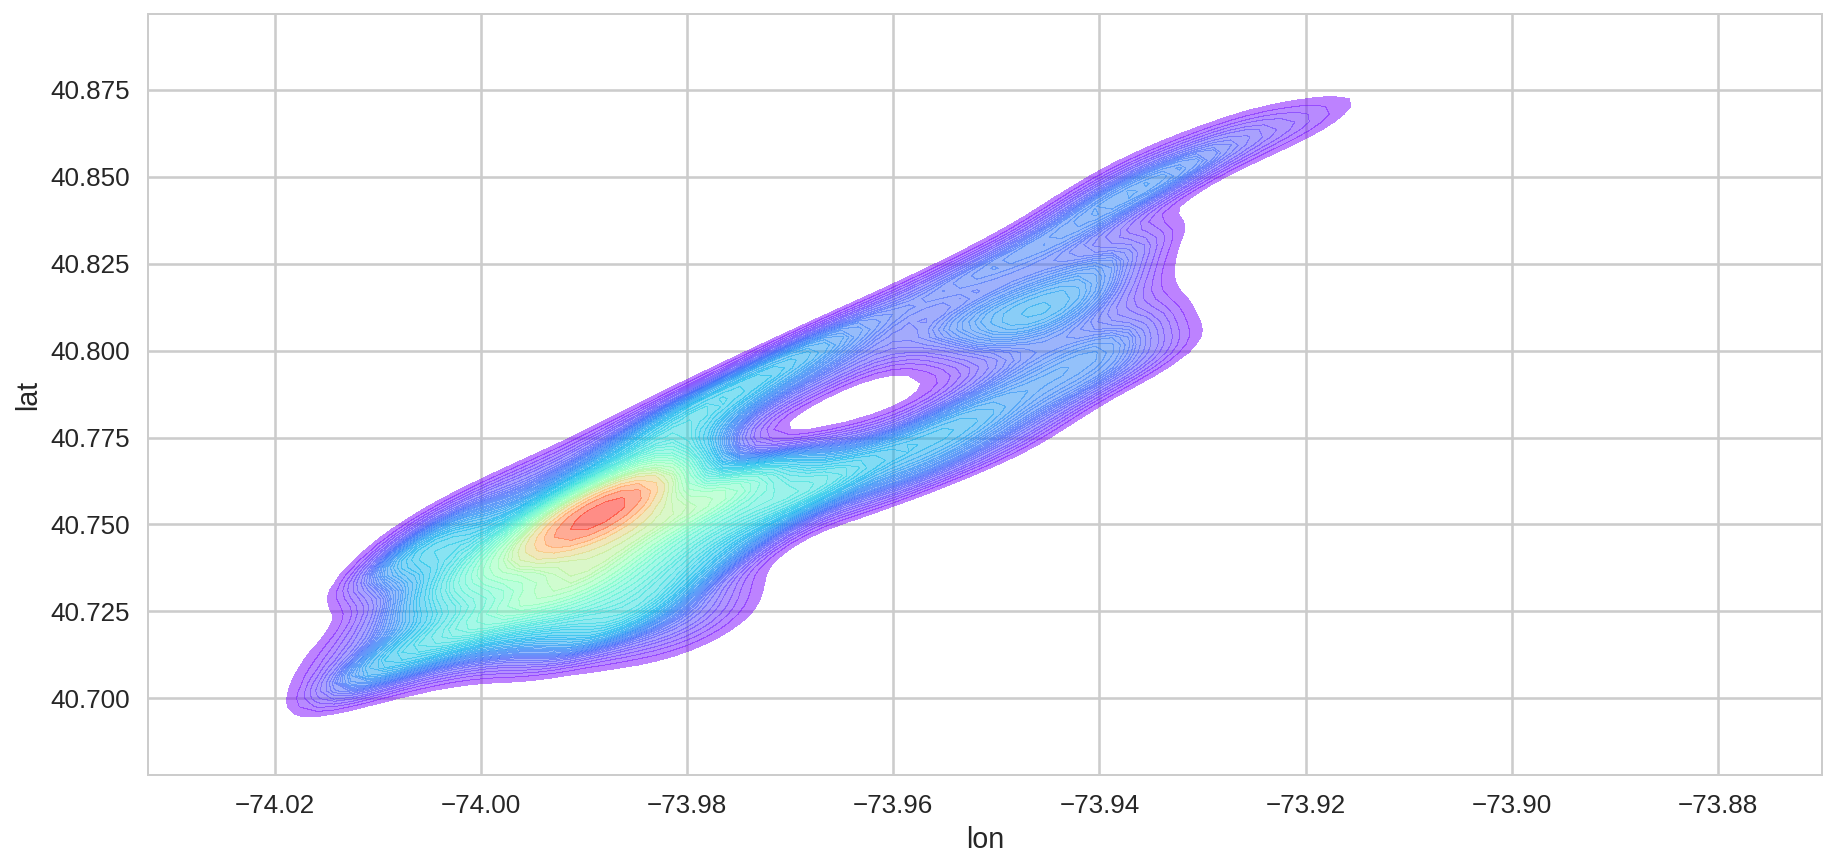

In [ ]:
sample = complaints.sample(10000)

sns.kdeplot(
    sample.lon,
    sample.lat,
    gridsize=100,  # controls the resolution
    cmap=plt.cm.rainbow,  # color scheme
    shade=  # whether to have a density plot (True), or just the contours (False)
    True,
    alpha=0.5,
    figsize=(15,15),
    shade_lowest=False,
    n_levels=50  # How many contours/levels to have
)

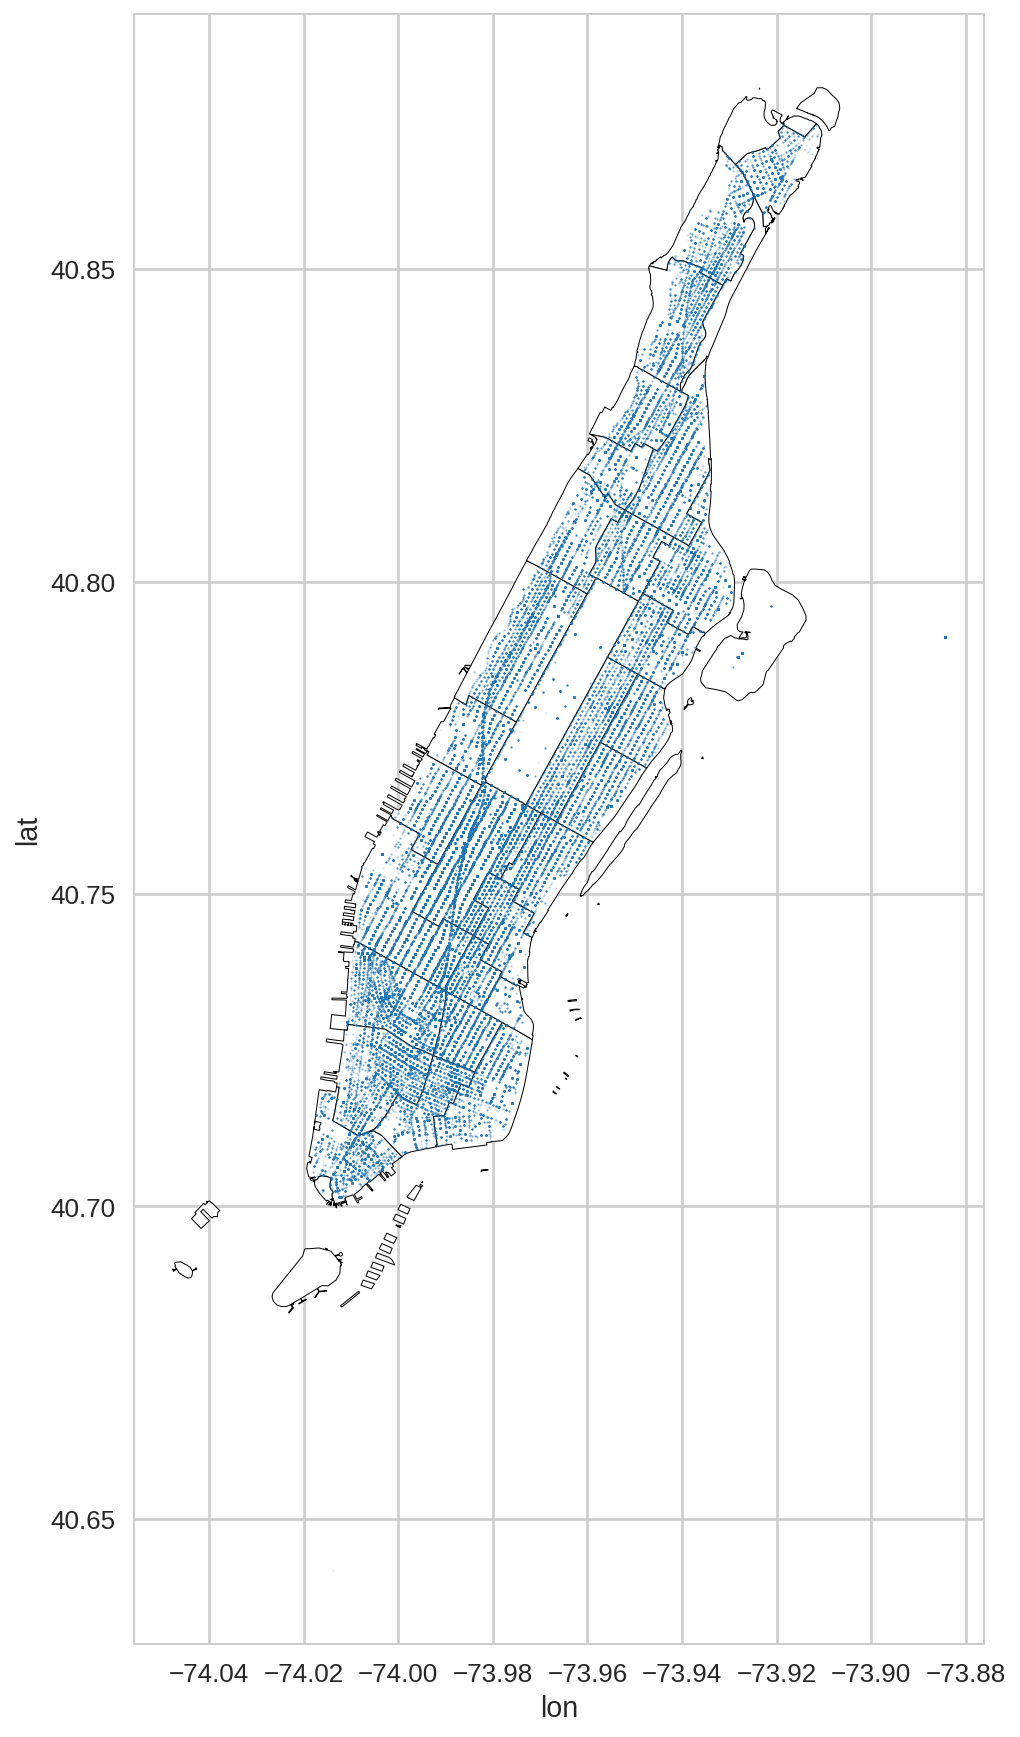

In [ ]:
base = df_manhattan.plot(
    linewidth=0.5,
    color='White',
    edgecolor='Black',
    figsize=(15, 10)
    )

scatterplot = complaints.plot(
    kind='scatter',
    x='lon',
    y='lat',
    figsize=(20, 15),
    s=0.5,
    alpha=0.1,
    ax=base)
